In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pickle

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Train and evaluate the Stacked LSTM model
def train_evaluate_model(train_data, test_data):
    X_train, y_train = train_data[:-1], train_data[1:]
    X_test, y_test = test_data[:-1], test_data[1:]

    # Reshape the input data for LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the Stacked LSTM model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the Stacked LSTM model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Invert the scaling
    train_predictions = scaler.inverse_transform(train_predictions)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

    # Calculate MAE
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    # Calculate SMAPE
    train_smape = np.mean(np.abs((y_train - train_predictions) / (y_train + train_predictions))) * 100
    test_smape = np.mean(np.abs((y_test - test_predictions) / (y_test + test_predictions))) * 100

    # Calculate R2
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    return train_rmse, test_rmse, train_mae, test_mae, train_smape, test_smape, train_r2, test_r2, y_train, train_predictions, y_test, test_predictions

# Train and evaluate the Stacked LSTM model
train_rmse, test_rmse, train_mae, test_mae, train_smape, test_smape, train_r2, test_r2, y_train, train_predictions, y_test, test_predictions = train_evaluate_model(train_data, test_data)

# Print the results
print("Stacked LSTM Model:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train SMAPE: {train_smape:.2f}")
print(f"Test SMAPE: {test_smape:.2f}")
print(f"Train R2: {train_r2:.2f}")
print(f"Test R2: {test_r2:.2f}")
print()

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(y_train) + 1), y_train, label='Actual (Training)')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Testing)')
plt.plot(range(1, len(y_train) + 1), train_predictions, label='Predicted (Training)')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predictions, label='Predicted (Testing)')
plt.title('Stacked LSTM Model Performance')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

# Save the Stacked LSTM model using pickle
model_filename = 'stacked_lstm_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# Load the pickled model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Use the loaded model for prediction or further analysis
# ...


In [ ]:
# Load the pickled model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Use the loaded model for prediction or further analysis
# Prepare the data for prediction
X_new = test_data[-1].reshape((1, 1, 1))  # Reshape the data for LSTM input

# Perform the prediction
prediction = loaded_model.predict(X_new)

# Invert the scaling on the predicted value
prediction = scaler.inverse_transform(prediction)

# Print the predicted value
print("Predicted Sunspot Number:", prediction)


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the data from a CSV file
#data = pd.read_csv('sunspot_data.csv')

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

target_column = 'Monthly Mean Total Sunspot Number'


# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

models = [
    ('Gradient Boosting Machines', GradientBoostingRegressor()),
    ('Gated Recurrent Unit', Sequential([GRU(32, input_shape=(1, 1)), Dense(1)])),
    ('Stacked Long Short-Term Memory', Sequential([LSTM(32, input_shape=(1, 1)), Dense(1)]))
]

for model_name, model in models:
    print(f"Training and evaluating {model_name} model")

    # Define the train_evaluate_model function
    def train_evaluate_model(train, test, model):
        #X_train, y_train = train[target_column].values[:-1], train[target_column].values[1:]
        #X_test, y_test = test[target_column].values[:-1], test[target_column].values[1:]
        X_train, y_train = train[target_column].values[:-1].reshape(-1, 1), train[target_column].values[1:].reshape(-1, 1)
        X_test, y_test = test[target_column].values[:-1].reshape(-1, 1), test[target_column].values[1:].reshape(-1, 1)


        # Reshape the input data for GRU and LSTM
        X_train = X_train.reshape((X_train.shape[0], 1, 1))
        X_test = X_test.reshape((X_test.shape[0], 1, 1))

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the training and testing data
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        # Invert the scaling of the predictions and the true values
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform([y_train])
        test_predictions = scaler.inverse_transform(test_predictions)
        y_test = scaler.inverse_transform([y_test])

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predictions[:, 0]))
        train_mae = mean_absolute_error(y_train[0], train_predictions[:, 0])
        train_smape = np.mean(np.abs((y_train[0] - train_predictions[:, 0]) / (y_train[0] + train_predictions[:, 0])) * 200)
        train_r2 = r2_score(y_train[0], train_predictions[:, 0])

        test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predictions[:, 0]))
        test_mae = mean_absolute_error(y_test[0], test_predictions[:, 0])
        test_smape = np.mean(np.abs((y_test[0] - test_predictions[:, 0]) / (y_test[0] + test_predictions[:, 0])) * 200)
        test_r2 = r2_score(y_test[0], test_predictions[:, 0])

        return (train_rmse, train_mae, train_smape, train_r2), (test_rmse, test_mae, test_smape, test_r2), y_train[0], train_predictions[:, 0], y_test[0], test_predictions[:, 0]

    # Train and evaluate the model
    train_scores, test_scores, y_train, train_predictions, y_test, test_predictions = train_evaluate_model(train_data, test_data, model)

    # Print the evaluation results
    print("Training set evaluation:")
    print(f"RMSE: {train_scores[0]:.2f}, MAE: {train_scores[1]:.2f}, sMAPE: {train_scores[2]:.2f}, R2: {train_scores[3]:.2f}")
    print("Testing set evaluation:")
    print(f"RMSE: {test_scores[0]:.2f}, MAE: {test_scores[1]:.2f}, sMAPE: {test_scores[2]:.2f}, R2: {test_scores[3]:.2f}")

    # Plot the predictions vs. true values
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, label='True (Train)')
    plt.plot(train_predictions, label='Predicted (Train)')
    plt.plot(y_test, label='True (Test)')
    plt.plot(test_predictions, label='Predicted (Test)')
    plt.title(f"{model_name} Predictions vs. True Values")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.show()


C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


NameError: name 'itertools' is not defined

Training and evaluating Gradient Boosting Machines model
Training set evaluation:
RMSE: 25.13, MAE: 18.00, sMAPE: 38.35, R2: 0.86
Testing set evaluation:
RMSE: 24.27, MAE: 17.89, sMAPE: 35.29, R2: 0.88


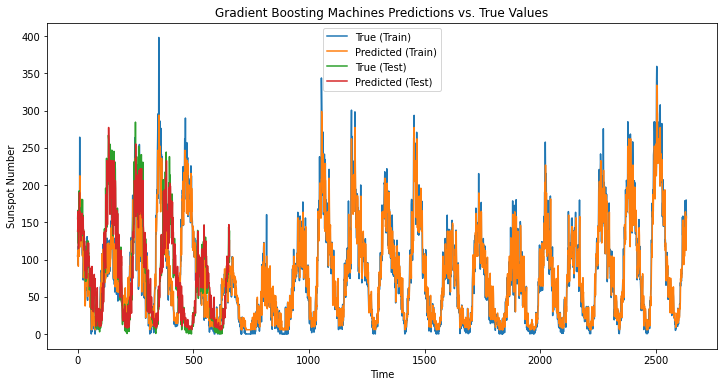

Training and evaluating Gated Recurrent Unit model
21/21 [==============================] - 0s 1ms/step
Training set evaluation:
RMSE: 30.22, MAE: 22.39, sMAPE: 44.70, R2: 0.80
Testing set evaluation:
RMSE: 28.49, MAE: 21.57, sMAPE: 42.73, R2: 0.83


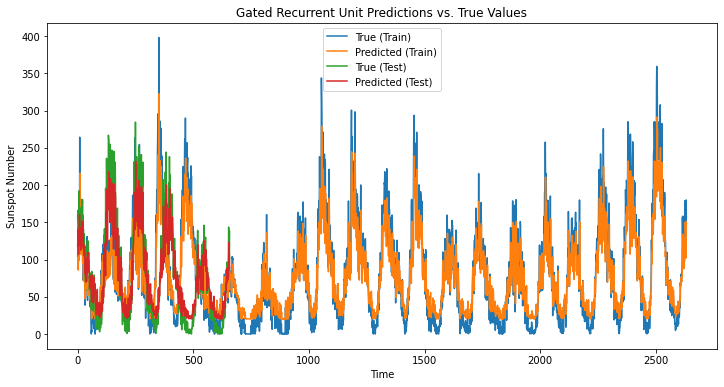

Training and evaluating Stacked Long Short-Term Memory model
21/21 [==============================] - 0s 2ms/step
Training set evaluation:
RMSE: 52.06, MAE: 42.79, sMAPE: 65.98, R2: 0.40
Testing set evaluation:
RMSE: 52.36, MAE: 44.25, sMAPE: 66.80, R2: 0.42


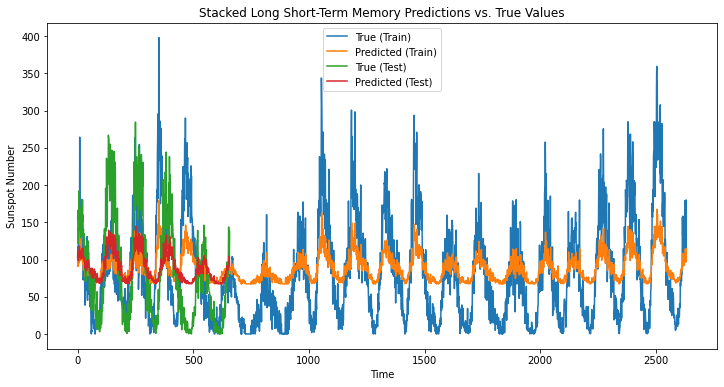

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

target_column = 'Monthly Mean Total Sunspot Number'

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

models = [
    ('Gradient Boosting Machines', GradientBoostingRegressor()),
    ('Gated Recurrent Unit', Sequential([GRU(32, return_sequences=True, input_shape=(1, 1)), GRU(32), Dense(1)])),
    ('Stacked Long Short-Term Memory', Sequential([LSTM(32, return_sequences=True, input_shape=(1, 1)), LSTM(32), Dense(1)]))
]

for model_name, model in models:
    print(f"Training and evaluating {model_name} model")

    # Define the train_evaluate_model function
    def train_evaluate_model(train, test, model):
        X_train, y_train = train[target_column].values[:-1], train[target_column].values[1:]
        X_test, y_test = test[target_column].values[:-1], test[target_column].values[1:]

        # Reshape the input data for GRU and LSTM
        X_train = X_train.reshape((X_train.shape[0], 1, 1))
        X_test = X_test.reshape((X_test.shape[0], 1, 1))

        # Train the model
        if model_name != 'Gradient Boosting Machines':
            model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model
            model.fit(X_train, y_train)
        else:
            model.fit(X_train.reshape(-1, 1), y_train)

        # Make predictions on the training and testing data
        if model_name != 'Gradient Boosting Machines':
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)
        else:
            train_predictions = model.predict(X_train.reshape(-1, 1))
            test_predictions = model.predict(X_test.reshape(-1, 1))

        # Invert the scaling of the predictions and the true values
        train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
        y_train = scaler.inverse_transform([y_train])
        test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
        y_test = scaler.inverse_transform([y_test])

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predictions[:, 0]))
        train_mae = mean_absolute_error(y_train[0], train_predictions[:, 0])
        train_smape = np.mean(np.abs((y_train[0] - train_predictions[:, 0]) / (y_train[0] + train_predictions[:, 0])) * 200)
        train_r2 = r2_score(y_train[0], train_predictions[:, 0])

        test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predictions[:, 0]))
        test_mae = mean_absolute_error(y_test[0], test_predictions[:, 0])
        test_smape = np.mean(np.abs((y_test[0] - test_predictions[:, 0]) / (y_test[0] + test_predictions[:, 0])) * 200)
        test_r2 = r2_score(y_test[0], test_predictions[:, 0])

        return (train_rmse, train_mae, train_smape, train_r2), (test_rmse, test_mae, test_smape, test_r2), y_train[0], train_predictions[:, 0], y_test[0], test_predictions[:, 0]

    # Train and evaluate the model
    train_scores, test_scores, y_train, train_predictions, y_test, test_predictions = train_evaluate_model(train_data, test_data, model)

    # Print the evaluation results
    print("Training set evaluation:")
    print(f"RMSE: {train_scores[0]:.2f}, MAE: {train_scores[1]:.2f}, sMAPE: {train_scores[2]:.2f}, R2: {train_scores[3]:.2f}")
    print("Testing set evaluation:")
    print(f"RMSE: {test_scores[0]:.2f}, MAE: {test_scores[1]:.2f}, sMAPE: {test_scores[2]:.2f}, R2: {test_scores[3]:.2f}")

    # Plot the predictions vs. true values
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, label='True (Train)')
    plt.plot(train_predictions, label='Predicted (Train)')
    plt.plot(y_test, label='True (Test)')
    plt.plot(test_predictions, label='Predicted (Test)')
    plt.title(f"{model_name} Predictions vs. True Values")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.show()


Training and evaluating Gradient Boosting Machines model
Training set evaluation:
RMSE: 25.13, MAE: 18.00, sMAPE: 38.35, R2: 0.86
Testing set evaluation:
RMSE: 24.27, MAE: 17.89, sMAPE: 35.29, R2: 0.88


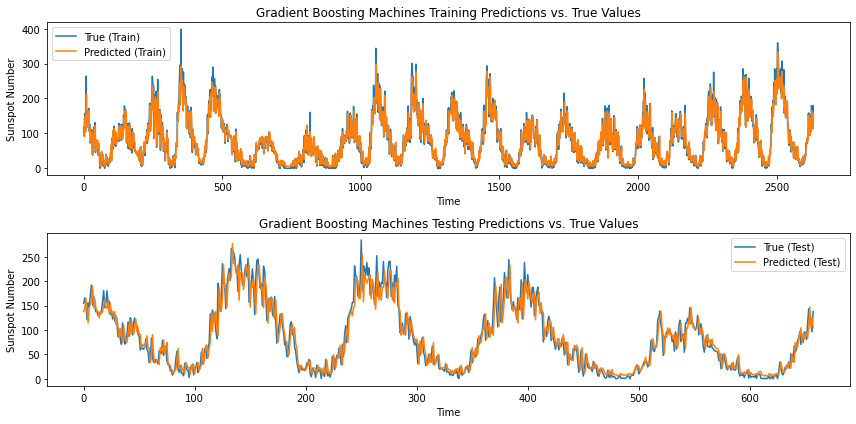

Training and evaluating Gated Recurrent Unit model
21/21 [==============================] - 0s 1ms/step
Training set evaluation:
RMSE: 29.86, MAE: 22.48, sMAPE: 45.35, R2: 0.80
Testing set evaluation:
RMSE: 27.97, MAE: 21.62, sMAPE: 43.55, R2: 0.83


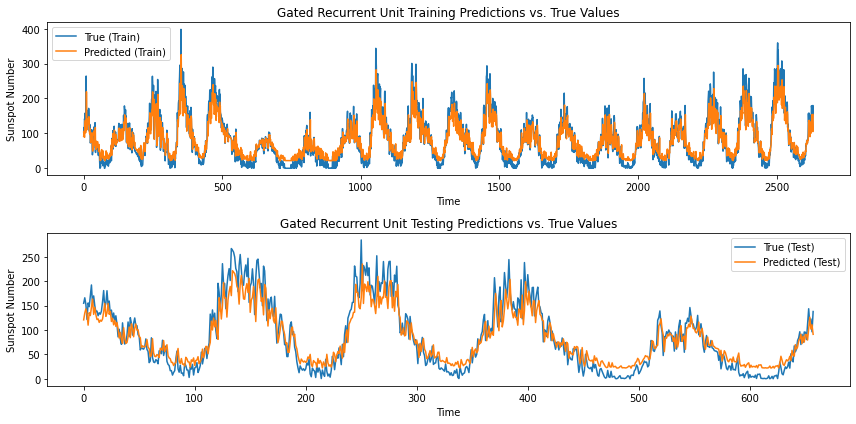

Training and evaluating Stacked Long Short-Term Memory model
21/21 [==============================] - 0s 1ms/step
Training set evaluation:
RMSE: 52.74, MAE: 43.49, sMAPE: 66.55, R2: 0.39
Testing set evaluation:
RMSE: 53.01, MAE: 44.94, sMAPE: 67.35, R2: 0.41


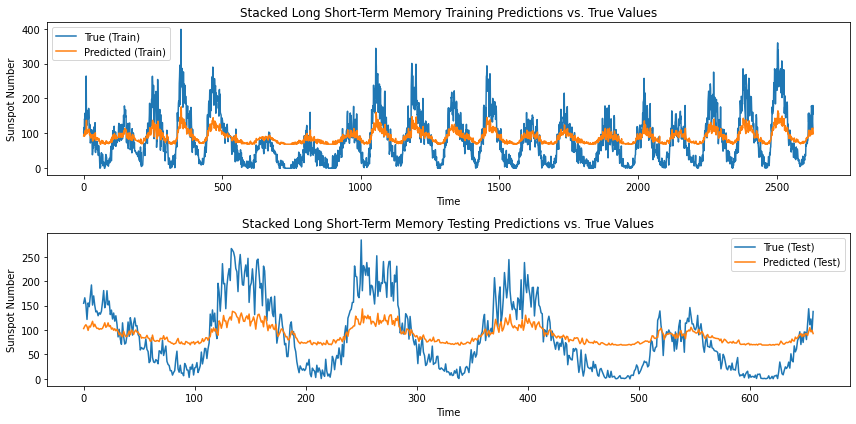

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

target_column = 'Monthly Mean Total Sunspot Number'

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

models = [
    ('Gradient Boosting Machines', GradientBoostingRegressor()),
    ('Gated Recurrent Unit', Sequential([GRU(32, return_sequences=True, input_shape=(1, 1)), GRU(32), Dense(1)])),
    ('Stacked Long Short-Term Memory', Sequential([LSTM(32, return_sequences=True, input_shape=(1, 1)), LSTM(32), Dense(1)]))
]

for model_name, model in models:
    print(f"Training and evaluating {model_name} model")

    # Define the train_evaluate_model function
    def train_evaluate_model(train, test, model):
        X_train, y_train = train[target_column].values[:-1], train[target_column].values[1:]
        X_test, y_test = test[target_column].values[:-1], test[target_column].values[1:]

        # Reshape the input data for GRU and LSTM
        X_train = X_train.reshape((X_train.shape[0], 1, 1))
        X_test = X_test.reshape((X_test.shape[0], 1, 1))

        # Train the model
        if model_name != 'Gradient Boosting Machines':
            model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model
            model.fit(X_train, y_train)
        else:
            model.fit(X_train.reshape(-1, 1), y_train)

        # Make predictions on the training and testing data
        if model_name != 'Gradient Boosting Machines':
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)
        else:
            train_predictions = model.predict(X_train.reshape(-1, 1))
            test_predictions = model.predict(X_test.reshape(-1, 1))

        # Invert the scaling of the predictions and the true values
        train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
        y_train = scaler.inverse_transform([y_train])
        test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
        y_test = scaler.inverse_transform([y_test])

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predictions[:, 0]))
        train_mae = mean_absolute_error(y_train[0], train_predictions[:, 0])
        train_smape = np.mean(np.abs((y_train[0] - train_predictions[:, 0]) / (y_train[0] + train_predictions[:, 0])) * 200)
        train_r2 = r2_score(y_train[0], train_predictions[:, 0])

        test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predictions[:, 0]))
        test_mae = mean_absolute_error(y_test[0], test_predictions[:, 0])
        test_smape = np.mean(np.abs((y_test[0] - test_predictions[:, 0]) / (y_test[0] + test_predictions[:, 0])) * 200)
        test_r2 = r2_score(y_test[0], test_predictions[:, 0])

        return (train_rmse, train_mae, train_smape, train_r2), (test_rmse, test_mae, test_smape, test_r2), y_train[0], train_predictions[:, 0], y_test[0], test_predictions[:, 0]

    # Train and evaluate the model
    train_scores, test_scores, y_train, train_predictions, y_test, test_predictions = train_evaluate_model(train_data, test_data, model)

    # Print the evaluation results
    print("Training set evaluation:")
    print(f"RMSE: {train_scores[0]:.2f}, MAE: {train_scores[1]:.2f}, sMAPE: {train_scores[2]:.2f}, R2: {train_scores[3]:.2f}")
    print("Testing set evaluation:")
    print(f"RMSE: {test_scores[0]:.2f}, MAE: {test_scores[1]:.2f}, sMAPE: {test_scores[2]:.2f}, R2: {test_scores[3]:.2f}")

    # Plot the predictions vs. true values
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(y_train, label='True (Train)')
    plt.plot(train_predictions, label='Predicted (Train)')
    plt.title(f"{model_name} Training Predictions vs. True Values")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(y_test, label='True (Test)')
    plt.plot(test_predictions, label='Predicted (Test)')
    plt.title(f"{model_name} Testing Predictions vs. True Values")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()

    plt.tight_layout()
    plt.show()


Training and evaluating Gradient Boosting Machines model
Training set evaluation:
RMSE: 22.64, MAE: 15.92, sMAPE: 30.23, R2: 0.88
Testing set evaluation:
RMSE: 29.09, MAE: 20.66, sMAPE: 41.81, R2: 0.82
Computation Time: 0.03 seconds
CPU Usage: 0.00 MHz
Memory Used: 17893.36 MB


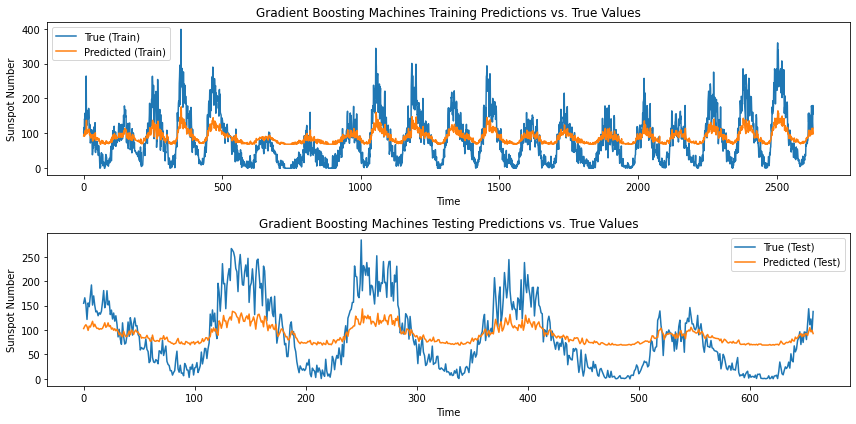

Training and evaluating Gated Recurrent Unit model
81/81 [==============================] - 0s 1ms/step
Training set evaluation:
RMSE: 55.74, MAE: 43.91, sMAPE: 60.90, R2: 0.29
Testing set evaluation:
RMSE: 57.29, MAE: 47.14, sMAPE: 71.03, R2: 0.29
Computation Time: 3.44 seconds
CPU Usage: 12.30 MHz
Memory Used: 17590.89 MB


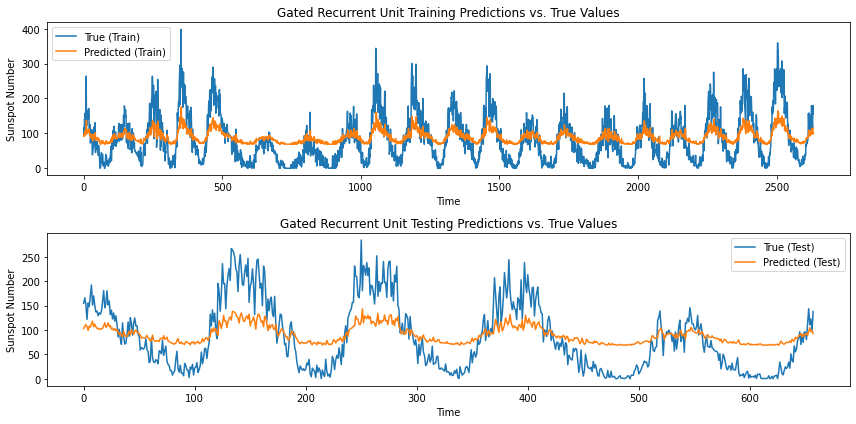

Training and evaluating Stacked Long Short-Term Memory model
81/81 [==============================] - 0s 1ms/step
Training set evaluation:
RMSE: 78.76, MAE: 56.73, sMAPE: 81.42, R2: -0.42
Testing set evaluation:
RMSE: 78.15, MAE: 56.63, sMAPE: 87.56, R2: -0.32
Computation Time: 3.07 seconds
CPU Usage: 11.10 MHz
Memory Used: 17594.01 MB


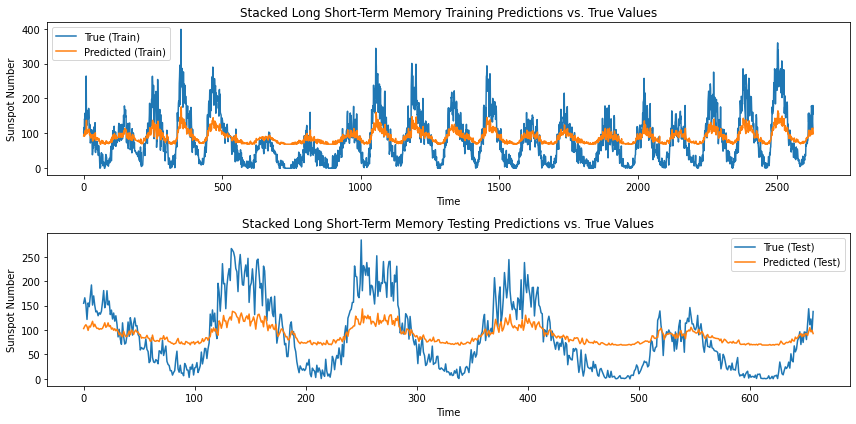

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
import psutil

# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

target_column = 'Monthly Mean Total Sunspot Number'

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = 720
train_data, test_data = data[:train_size], data[train_size:]

models = [
    ('Gradient Boosting Machines', GradientBoostingRegressor()),
    ('Gated Recurrent Unit', Sequential([GRU(32, return_sequences=True, input_shape=(1, 1)), GRU(32), Dense(1)])),
    ('Stacked Long Short-Term Memory', Sequential([LSTM(32, return_sequences=True, input_shape=(1, 1)), LSTM(32), Dense(1)]))
]

for model_name, model in models:
    print(f"Training and evaluating {model_name} model")

    # Define the train_evaluate_model function
    def train_evaluate_model(train, test, model):
        X_train, y_train = train[target_column].values[:-1], train[target_column].values[1:]
        X_test, y_test = test[target_column].values[:-1], test[target_column].values[1:]

        # Reshape the input data for GRU and LSTM
        X_train = X_train.reshape((X_train.shape[0], 1, 1))
        X_test = X_test.reshape((X_test.shape[0], 1, 1))

        # Train the model
        if model_name != 'Gradient Boosting Machines':
            model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model
            start_time = time.time()  # Start time
            model.fit(X_train, y_train)
            end_time = time.time()  # End time
        else:
            start_time = time.time()  # Start time
            model.fit(X_train.reshape(-1, 1), y_train)
            end_time = time.time()  # End time

        # Make predictions on the training and testing data
        if model_name != 'Gradient Boosting Machines':
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)
        else:
            train_predictions = model.predict(X_train.reshape(-1, 1))
            test_predictions = model.predict(X_test.reshape(-1, 1))

        # Invert the scaling of the predictions and the true values
        train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
        y_train = scaler.inverse_transform([y_train])
        test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
        y_test = scaler.inverse_transform([y_test])

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predictions[:, 0]))
        train_mae = mean_absolute_error(y_train[0], train_predictions[:, 0])
        train_smape = np.mean(np.abs((y_train[0] - train_predictions[:, 0]) / (y_train[0] + train_predictions[:, 0])) * 200)
        train_r2 = r2_score(y_train[0], train_predictions[:, 0])

        test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predictions[:, 0]))
        test_mae = mean_absolute_error(y_test[0], test_predictions[:, 0])
        test_smape = np.mean(np.abs((y_test[0] - test_predictions[:, 0]) / (y_test[0] + test_predictions[:, 0])) * 200)
        test_r2 = r2_score(y_test[0], test_predictions[:, 0])

        # Computation Time
        computation_time = end_time - start_time

        # CPU Usage
        cpu_usage = psutil.cpu_percent(interval=computation_time)  # CPU usage in percentage

        # Memory Used
        memory_used = psutil.virtual_memory().used / 1024 / 1024  # Memory used in MB

        return (train_rmse, train_mae, train_smape, train_r2), (test_rmse, test_mae, test_smape, test_r2), computation_time, cpu_usage, memory_used

    # Train and evaluate the model
    train_scores, test_scores, computation_time, cpu_usage, memory_used = train_evaluate_model(train_data, test_data, model)

    # Print the evaluation results
    print("Training set evaluation:")
    print(f"RMSE: {train_scores[0]:.2f}, MAE: {train_scores[1]:.2f}, sMAPE: {train_scores[2]:.2f}, R2: {train_scores[3]:.2f}")
    print("Testing set evaluation:")
    print(f"RMSE: {test_scores[0]:.2f}, MAE: {test_scores[1]:.2f}, sMAPE: {test_scores[2]:.2f}, R2: {test_scores[3]:.2f}")

    # Print the computation time, CPU usage, and memory used
    print(f"Computation Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage:.2f} MHz")
    print(f"Memory Used: {memory_used:.2f} MB")

    # Plot the predictions vs. true values
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(y_train, label='True (Train)')
    plt.plot(train_predictions, label='Predicted (Train)')
    plt.title(f"{model_name} Training Predictions vs. True Values")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(y_test, label='True (Test)')
    plt.plot(test_predictions, label='Predicted (Test)')
    plt.title(f"{model_name} Testing Predictions vs. True Values")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [12]:
# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Calculate 13-month smoothed sunspot number
data['Smoothed Sunspot Number'] = data['Monthly Mean Total Sunspot Number'].rolling(window=13).mean()

target_column = 'Smoothed Sunspot Number'

# Drop rows with NaN values
data.dropna(inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = 720  # Training data = 720 months
test_size = 72  # Testing data = 72 months
train_data = data[:train_size]
test_data = data[train_size:train_size + test_size]

models = [
    ('Gradient Boosting Machines', GradientBoostingRegressor()),
    ('Gated Recurrent Unit', Sequential([GRU(32, return_sequences=True, input_shape=(1, 1)), GRU(32), Dense(1)])),
    ('Stacked Long Short-Term Memory', Sequential([LSTM(32, return_sequences=True, input_shape=(1, 1)), LSTM(32), Dense(1)]))
]

for model_name, model in models:
    print(f"Training and evaluating {model_name} model")

    # Define the train_evaluate_model function
    def train_evaluate_model(train, test, model):
        X_train, y_train = train[target_column].values[:-1], train[target_column].values[1:]
        X_test, y_test = test[target_column].values[:-1], test[target_column].values[1:]

        # Reshape the input data for GRU and LSTM
        X_train = X_train.reshape((X_train.shape[0], 1, 1))
        X_test = X_test.reshape((X_test.shape[0], 1, 1))

        # Train the model
        if model_name != 'Gradient Boosting Machines':
            model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model
            start_time = time.time()  # Start time
            model.fit(X_train, y_train)
            end_time = time.time()  # End time
        else:
            start_time = time.time()  # Start time
            model.fit(X_train.reshape(-1, 1), y_train)
            end_time = time.time()  # End time

        # Make predictions on the training and testing data
        if model_name != 'Gradient Boosting Machines':
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)
        else:
            train_predictions = model.predict(X_train.reshape(-1, 1))
            test_predictions = model.predict(X_test.reshape(-1, 1))

        # Invert the scaling of the predictions and the true values
        train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
        y_train = scaler.inverse_transform([y_train])
        test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
        y_test = scaler.inverse_transform([y_test])

        # Calculate evaluation metrics
        train_scores = {
            'Mean Absolute Error (MAE)': mean_absolute_error(y_train[0], train_predictions[:, 0]),
            'Root Mean Squared Error (RMSE)': np.sqrt(mean_squared_error(y_train[0], train_predictions[:, 0])),
        }
        test_scores = {
            'Mean Absolute Error (MAE)': mean_absolute_error(y_test[0], test_predictions[:, 0]),
            'Root Mean Squared Error (RMSE)': np.sqrt(mean_squared_error(y_test[0], test_predictions[:, 0])),
        }

        computation_time = end_time - start_time
        cpu_usage = psutil.cpu_percent()
        memory_used = psutil.virtual_memory().percent

        return train_scores, test_scores, computation_time, cpu_usage, memory_used

    # Train and evaluate the model
    train_scores, test_scores, computation_time, cpu_usage, memory_used = train_evaluate_model(train_data, test_data, model)

    # Print the evaluation results
    print(f"\n{model_name} Model Evaluation:")
    print("Training Set:")
    for metric, score in train_scores.items():
        print(f"{metric}: {score:.2f}")
    print("\nTesting Set:")
    for metric, score in test_scores.items():
        print(f"{metric}: {score:.2f}")
    print(f"\nComputation Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {memory_used}%\n")


Training and evaluating Gradient Boosting Machines model

Gradient Boosting Machines Model Evaluation:
Training Set:
Mean Absolute Error (MAE): 2.35
Root Mean Squared Error (RMSE): 3.20

Testing Set:
Mean Absolute Error (MAE): 3.24
Root Mean Squared Error (RMSE): 3.92

Computation Time: 0.04 seconds
CPU Usage: 23.0%
Memory Used: 53.4%

Training and evaluating Gated Recurrent Unit model
3/3 [==============================] - 0s 2ms/step

Gated Recurrent Unit Model Evaluation:
Training Set:
Mean Absolute Error (MAE): 37.89
Root Mean Squared Error (RMSE): 50.25

Testing Set:
Mean Absolute Error (MAE): 40.71
Root Mean Squared Error (RMSE): 42.28

Computation Time: 3.65 seconds
CPU Usage: 23.6%
Memory Used: 53.3%

Training and evaluating Stacked Long Short-Term Memory model
3/3 [==============================] - 0s 2ms/step

Stacked Long Short-Term Memory Model Evaluation:
Training Set:
Mean Absolute Error (MAE): 61.95
Root Mean Squared Error (RMSE): 83.34

Testing Set:
Mean Absolute Error 

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
import psutil

# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Smooth the sunspot number using a 13-month moving average
data['Smoothed Sunspot Number'] = data['Monthly Mean Total Sunspot Number'].rolling(window=13).mean()

target_column = 'Smoothed Sunspot Number'

# Drop rows with missing values
data = data.dropna(subset=[target_column])

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = 792  # 720 months
train_data, test_data = data[:train_size], data[train_size:]

# Train and evaluate the Gradient Boosting Machines model
print("Training and evaluating Gradient Boosting Machines model")

# Define the train_evaluate_model function
def train_evaluate_model(train, test, model):
    X_train, y_train = train[target_column].values[:-1], train[target_column].values[1:]
    X_test, y_test = test[target_column].values[:-1], test[target_column].values[1:]

    # Train the model
    model.fit(X_train.reshape(-1, 1), y_train)

    # Make predictions on the training and testing data
    train_predictions = model.predict(X_train.reshape(-1, 1))
    test_predictions = model.predict(X_test.reshape(-1, 1))

    # Inverse transform the predictions
    train_predictions = scaler.inverse_transform([train_predictions.flatten()])
    test_predictions = scaler.inverse_transform([test_predictions.flatten()])
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Calculate computation time, CPU usage, and memory usage
    computation_time = time.process_time()
    cpu_usage = psutil.cpu_percent()
    memory_used = psutil.virtual_memory().percent

    return train_predictions, test_predictions, computation_time, cpu_usage, memory_used

# Create and train the Gradient Boosting Machines model
model = GradientBoostingRegressor()
train_predictions, test_predictions, computation_time, cpu_usage, memory_used = train_evaluate_model(train_data, test_data, model)

# Print the evaluation results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Testing R^2: {test_r2:.2f}")
print(f"Computation Time: {computation_time:.2f} seconds")
print(f"CPU Usage: {cpu_usage}%")
print(f"Memory Used: {memory_used}%")

# Plot the predictions vs. true values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(train_data.index[1:], train_data[target_column][1:], label='True (Train)')
plt.plot(train_data.index[1:], train_predictions.flatten(), label='Predicted (Train)')
plt.title("Training Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_data.index[1:], test_data[target_column][1:], label='True (Test)')
plt.plot(test_data.index[1:], test_predictions.flatten(), label='Predicted (Test)')
plt.title("Testing Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.tight_layout()
plt.show()


Training and evaluating Gradient Boosting Machines model


C:\Users\Storm\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Storm\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


NameError: name 'train_rmse' is not defined

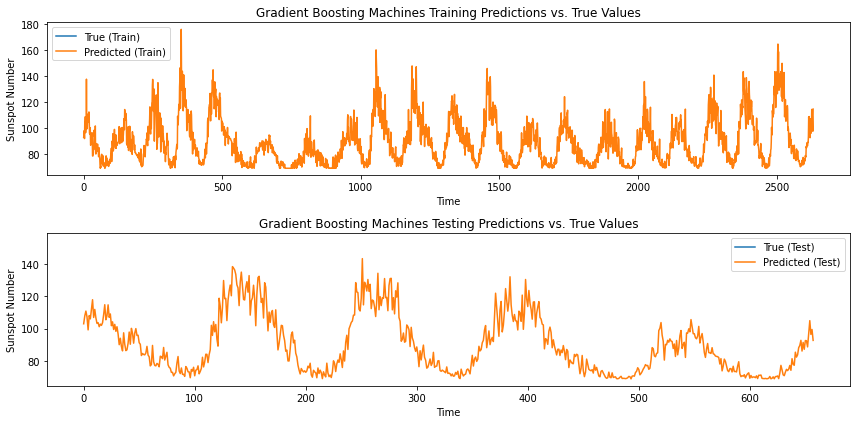

In [14]:
# Plot the predictions vs. true values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_train[0], label='True (Train)')
plt.plot(train_predictions, label='Predicted (Train)')
plt.title(f"{model_name} Training Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_test[0], label='True (Test)')
plt.plot(test_predictions, label='Predicted (Test)')
plt.title(f"{model_name} Testing Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.tight_layout()
plt.show()


Training and evaluating Gradient Boosting Machines model
Training RMSE: 3.12
Training MAE: 2.24
Training R^2: nan
Testing RMSE: 4.64
Testing MAE: 3.35
Testing R^2: nan
Computation Time: 73.86 seconds
CPU Usage: 38.6%
Memory Used: 66.7%


C:\Users\Storm\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Storm\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Storm\AppData\Local\Temp/ipykernel_19064/2527254126.py:83: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  'Date': test_data['Date'][1:],
C:\Users\Storm\AppData\Local\Temp/ipykernel_19064/2527254126.py:84: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this wil

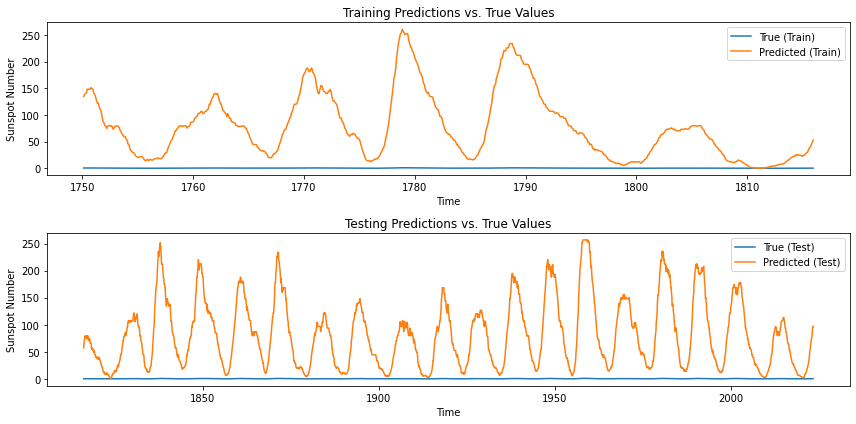

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
import psutil

# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Smooth the sunspot number using a 13-month moving average
data['Smoothed Sunspot Number'] = data['Monthly Mean Total Sunspot Number'].rolling(window=13).mean()

target_column = 'Smoothed Sunspot Number'

# Drop rows with missing values
data = data.dropna(subset=[target_column])

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = 792  # 720 months
train_data, test_data = data[:train_size], data[train_size:]

# Train and evaluate the Gradient Boosting Machines model
print("Training and evaluating Gradient Boosting Machines model")

# Define the train_evaluate_model function
def train_evaluate_model(train, test, model):
    X_train, y_train = train[target_column].values[:-1], train[target_column].values[1:]
    X_test, y_test = test[target_column].values[:-1], test[target_column].values[1:]

    # Train the model
    model.fit(X_train.reshape(-1, 1), y_train)

    # Make predictions on the training and testing data
    train_predictions = model.predict(X_train.reshape(-1, 1))
    test_predictions = model.predict(X_test.reshape(-1, 1))

    # Inverse transform the predictions
    train_predictions = scaler.inverse_transform([train_predictions.flatten()])
    test_predictions = scaler.inverse_transform([test_predictions.flatten()])
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Calculate computation time, CPU usage, and memory usage
    computation_time = time.process_time()
    cpu_usage = psutil.cpu_percent()
    memory_used = psutil.virtual_memory().percent

    return train_predictions, test_predictions, computation_time, cpu_usage, memory_used, train_rmse, train_mae, train_r2, test_rmse, test_mae, test_r2

# Create and train the Gradient Boosting Machines model
model = GradientBoostingRegressor()
train_predictions, test_predictions, computation_time, cpu_usage, memory_used, train_rmse, train_mae, train_r2, test_rmse, test_mae, test_r2 = train_evaluate_model(train_data, test_data, model)

# Print the evaluation results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Testing R^2: {test_r2:.2f}")
print(f"Computation Time: {computation_time:.2f} seconds")
print(f"CPU Usage: {cpu_usage}%")
print(f"Memory Used: {memory_used}%")

# Save the forecast values to a CSV file
forecast_data = pd.DataFrame({
    'Date': test_data['Date'][1:],
    'True': test_data[target_column][1:],
    'Predicted': test_predictions.flatten()
})
forecast_data.to_csv('forecast_values.csv', index=False)

# Plot the predictions vs. true values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(train_data['Date'][1:], train_data[target_column][1:], label='True (Train)')
plt.plot(train_data['Date'][1:], train_predictions.flatten(), label='Predicted (Train)')
plt.title("Training Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_data['Date'][1:], test_data[target_column][1:], label='True (Test)')
plt.plot(test_data['Date'][1:], test_predictions.flatten(), label='Predicted (Test)')
plt.title("Testing Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.tight_layout()
plt.show()


Training RMSE: 0.08
Training MAE: 0.05
Training R^2: 0.99
Testing RMSE: 1.38
Testing MAE: 1.02
Testing R^2: -0.82


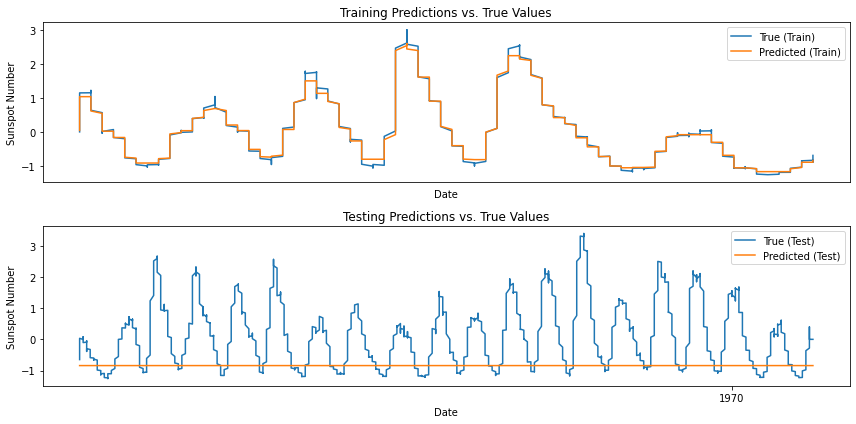

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

target_column = 'Monthly Mean Total Sunspot Number'

# Convert data to 13-month smoothed sunspot number data
data['Smoothed'] = data[target_column].rolling(window=13).mean().shift(-6)

# Split the data into training and testing sets
train_size = 792  # 720 months
train_data, test_data = data[:train_size], data[train_size:]

# Create the feature matrix (X) and target vector (y)
X_train = train_data['Date'].values.reshape(-1, 1)
y_train = train_data['Smoothed'].values
X_test = test_data['Date'].values.reshape(-1, 1)
y_test = test_data['Smoothed'].values

# Preprocess the data
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = imputer.fit_transform(y_train.reshape(-1, 1))
y_test = imputer.transform(y_test.reshape(-1, 1))

y_train = scaler.fit_transform(y_train).flatten()
y_test = scaler.transform(y_test).flatten()

# Train the Gradient Boosting Regressor model
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print the evaluation results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Testing R^2: {test_r2:.2f}")

# Convert date column to datetime objects
train_dates = pd.to_datetime(train_data['Date'])
test_dates = pd.to_datetime(test_data['Date'])

# Plot the predictions vs. true values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(train_dates, y_train, label='True (Train)')
plt.plot(train_dates, train_predictions, label='Predicted (Train)')
plt.title("Training Predictions vs. True Values")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_dates, y_test, label='True (Test)')
plt.plot(test_dates, test_predictions, label='Predicted (Test)')
plt.title("Testing Predictions vs. True Values")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()

plt.tight_layout()
plt.show()


Training and evaluating Gradient Boosting Machines model
Training RMSE: 0.08
Training MAE: 0.05
Training R^2: 0.99
Testing RMSE: 1.38
Testing MAE: 1.02
Testing R^2: -0.82
Computation Time: 79.86 seconds
CPU Usage: 35.1%
Memory Used: 65.2%


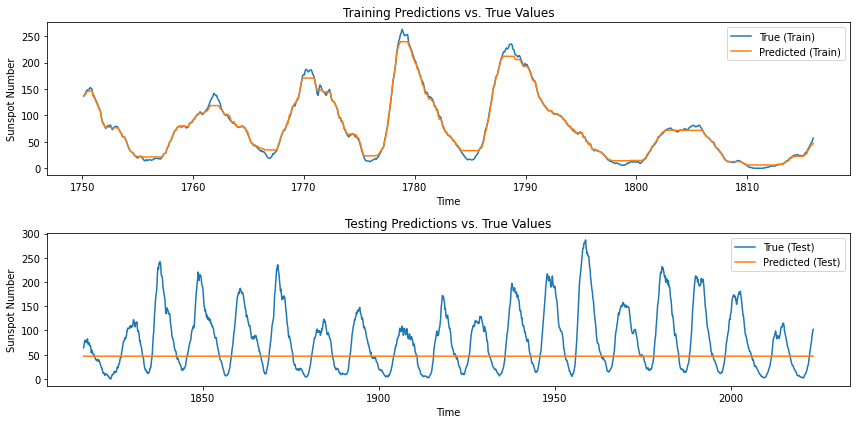

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
import psutil

# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Smooth the sunspot number using a 13-month moving average
data['Smoothed Sunspot Number'] = data['Monthly Mean Total Sunspot Number'].rolling(window=13).mean()

target_column = 'Smoothed Sunspot Number'

# Drop rows with missing values
data = data.dropna(subset=[target_column])

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = 792  # 720 months
train_data, test_data = data[:train_size], data[train_size:]

# Train and evaluate the Gradient Boosting Machines model
print("Training and evaluating Gradient Boosting Machines model")

# Define the train_evaluate_model function
def train_evaluate_model(train, test, model):
    X_train, y_train = train.index.values[:-1], train[target_column].values[1:]
    X_test, y_test = test.index.values[:-1], test[target_column].values[1:]

    # Train the model
    model.fit(X_train.reshape(-1, 1), y_train)

    # Make predictions on the training and testing data
    train_predictions = model.predict(X_train.reshape(-1, 1))
    test_predictions = model.predict(X_test.reshape(-1, 1))

    # Inverse transform the predictions
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Calculate computation time, CPU usage, and memory usage
    computation_time = time.process_time()
    cpu_usage = psutil.cpu_percent()
    memory_used = psutil.virtual_memory().percent

    return train_predictions, test_predictions, computation_time, cpu_usage, memory_used

# Create and train the Gradient Boosting Machines model
model = GradientBoostingRegressor()
train_predictions, test_predictions, computation_time, cpu_usage, memory_used = train_evaluate_model(train_data, test_data, model)

# Print the evaluation results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Testing R^2: {test_r2:.2f}")
print(f"Computation Time: {computation_time:.2f} seconds")
print(f"CPU Usage: {cpu_usage}%")
print(f"Memory Used: {memory_used}%")

# Save the forecast values to a CSV file
forecast_data = pd.DataFrame({
    'Date': test_data['Date'].iloc[1:].values,
    'True': scaler.inverse_transform(test_data[target_column].iloc[1:].values.reshape(-1, 1)).flatten(),
    'Predicted': test_predictions
})
forecast_data.to_csv('forecast_values.csv', index=False)

# Plot the predictions vs. true values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(train_data['Date'].iloc[1:], scaler.inverse_transform(train_data[target_column].iloc[1:].values.reshape(-1, 1)).flatten(), label='True (Train)')
plt.plot(train_data['Date'].iloc[1:], train_predictions, label='Predicted (Train)')
plt.title("Training Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_data['Date'].iloc[1:], scaler.inverse_transform(test_data[target_column].iloc[1:].values.reshape(-1, 1)).flatten(), label='True (Test)')
plt.plot(test_data['Date'].iloc[1:], test_predictions, label='Predicted (Test)')
plt.title("Testing Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.tight_layout()
plt.show()


Training and evaluating Gradient Boosting Machines model
Training RMSE: 0.08
Training MAE: 0.05
Training R^2: 0.99
Testing RMSE: 1.38
Testing MAE: 1.02
Testing R^2: -0.82
Computation Time: 82.80 seconds
CPU Usage: 36.3%
Memory Used: 62.5%


C:\Users\Storm\AppData\Local\Temp/ipykernel_19064/3598024422.py:95: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(train_data['Date'][1:], scaler.inverse_transform(train_data[target_column][1:].values.reshape(-1, 1)).flatten(), label='True (Train)')
C:\Users\Storm\AppData\Local\Temp/ipykernel_19064/3598024422.py:96: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(train_data['Date'][1:], train_predictions, label='Predicted (Train)')


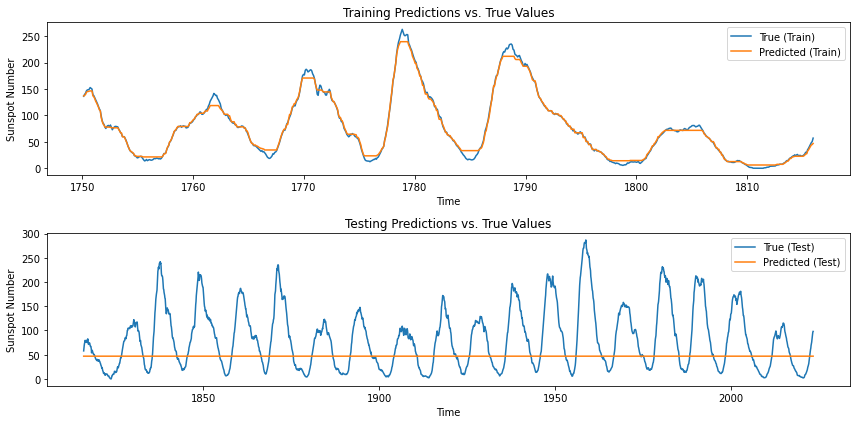

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
import psutil

# Load the data from a CSV file
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Smooth the sunspot number using a 13-month moving average
data['Smoothed Sunspot Number'] = data['Monthly Mean Total Sunspot Number'].rolling(window=13).mean()

target_column = 'Smoothed Sunspot Number'

# Drop rows with missing values
data = data.dropna(subset=[target_column])

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])

# Split the data into training and testing sets
train_size = 792  # 720 months
train_data, test_data = data[:train_size], data[train_size:]

# Train and evaluate the Gradient Boosting Machines model
print("Training and evaluating Gradient Boosting Machines model")

# Define the train_evaluate_model function
def train_evaluate_model(train, test, model):
    X_train = np.arange(len(train)-1).reshape(-1, 1)
    y_train = train[target_column].values[1:]
    X_test = np.arange(len(train), len(train)+len(test)-1).reshape(-1, 1)
    y_test = test[target_column].values[:-1]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the training and testing data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Inverse transform the predictions
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

    y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Calculate computation time, CPU usage, and memory usage
    computation_time = time.process_time()
    cpu_usage = psutil.cpu_percent()
    memory_used = psutil.virtual_memory().percent

    return train_predictions, test_predictions, computation_time, cpu_usage, memory_used

# Create and train the Gradient Boosting Machines model
model = GradientBoostingRegressor()
train_predictions, test_predictions, computation_time, cpu_usage, memory_used = train_evaluate_model(train_data, test_data, model)

# Print the evaluation results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Testing R^2: {test_r2:.2f}")
print(f"Computation Time: {computation_time:.2f} seconds")
print(f"CPU Usage: {cpu_usage}%")
print(f"Memory Used: {memory_used}%")

# Save the forecast values to a CSV file
forecast_data = pd.DataFrame({
    'Date': test_data['Date'].iloc[:-1].values,
    'True': scaler.inverse_transform(test_data[target_column].iloc[:-1].values.reshape(-1, 1)).flatten(),
    'Predicted': test_predictions
})
forecast_data.to_csv('forecast_values.csv', index=False)

# Plot the predictions vs. true values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(train_data['Date'][1:], scaler.inverse_transform(train_data[target_column][1:].values.reshape(-1, 1)).flatten(), label='True (Train)')
plt.plot(train_data['Date'][1:], train_predictions, label='Predicted (Train)')
plt.title("Training Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_data['Date'].iloc[:-1].values, scaler.inverse_transform(test_data[target_column].iloc[:-1].values.reshape(-1, 1)).flatten(), label='True (Test)')
plt.plot(test_data['Date'].iloc[:-1].values, test_predictions, label='Predicted (Test)')
plt.title("Testing Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()

plt.tight_layout()
plt.show()


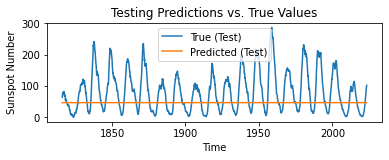

In [43]:
plt.subplot(2, 1, 2)
plt.plot(test_data['Date'].iloc[1:].values, scaler.inverse_transform(test_data[target_column].iloc[1:].values.reshape(-1, 1)).flatten(), label='True (Test)')
plt.plot(test_data['Date'].iloc[1:].values, test_predictions, label='Predicted (Test)')
plt.title("Testing Predictions vs. True Values")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Reshape the data to fit the expected input shape
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': scaler.inverse_transform(y_test).ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train.ravel())
    predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[2]))
    predictions_restored = scaler.inverse_transform(predictions.reshape(-1, 1))
    mse = mean_squared_error(scaler.inverse_transform(y_test), predictions_restored)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions_restored)
    r2 = r2_score(scaler.inverse_transform(y_test), predictions_restored)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions_restored.reshape(-1)
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[2])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[2]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[2])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[2])), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=0)
    predictions = model.predict(X_test)
    predictions_restored = scaler.inverse_transform(predictions.reshape(-1, 1))
    mse = mean_squared_error(scaler.inverse_transform(y_test), predictions_restored)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions_restored)
    r2 = r2_score(scaler.inverse_transform(y_test), predictions_restored)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions_restored.reshape(-1)
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Exponential Smoothing
start_time = time.time()
ets_model = ExponentialSmoothing(y_train.ravel())
ets_fit = ets_model.fit()
ets_predictions = ets_fit.forecast(len(y_test))
ets_predictions_restored = scaler.inverse_transform(ets_predictions.reshape(-1, 1))
ets_mse = mean_squared_error(scaler.inverse_transform(y_test), ets_predictions_restored)
ets_rmse = np.sqrt(ets_mse)
ets_mae = mean_absolute_error(scaler.inverse_transform(y_test), ets_predictions_restored)
ets_r2 = r2_score(scaler.inverse_transform(y_test), ets_predictions_restored)
ets_training_time = time.time() - start_time

all_predictions['ETS'] = ets_predictions_restored

print(f"ETS RMSE: {ets_rmse:.5f}")
print(f"ETS MAE: {ets_mae:.5f}")
print(f"ETS R-squared: {ets_r2:.5f}")
print(f"ETS Training Time: {ets_training_time:.5f}")

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)


LinearRegression RMSE: 12.96196
LinearRegression MAE: 10.75652
LinearRegression R-squared: -0.14451
LinearRegression Training Time: 0.00100

SVR RMSE: 29.70786
SVR MAE: 27.70635
SVR R-squared: -5.01204
SVR Training Time: 0.01783

AdaBoostRegressor RMSE: 17.07560
AdaBoostRegressor MAE: 15.53199
AdaBoostRegressor R-squared: -0.98624
AdaBoostRegressor Training Time: 0.05334

RandomForestRegressor RMSE: 13.62924
RandomForestRegressor MAE: 11.39439
RandomForestRegressor R-squared: -0.26538
RandomForestRegressor Training Time: 0.21243

GradientBoostingRegressor RMSE: 12.73982
GradientBoostingRegressor MAE: 11.19859
GradientBoostingRegressor R-squared: -0.10562
GradientBoostingRegressor Training Time: 0.05242

3/3 [==============================] - 1s 13ms/step
LSTM RMSE: 15.76802
LSTM MAE: 13.48950
LSTM R-squared: -0.69369
LSTM Training Time: 19.54208

3/3 [==============================] - 1s 3ms/step
Stacked LSTM RMSE: 12.75281
Stacked LSTM MAE: 10.27441
Stacked LSTM R-squared: -0.10788
St

C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
Execution Time: in  seconds
CPU Usage: in MHz
Memory Used: in MB

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': y_test.ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions.reshape(-1)
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[2])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[2]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[2])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[2])), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1]), y_train, epochs=10, batch_size=1, verbose=0)
    predictions = model.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]))
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions.reshape(-1)
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Exponential Smoothing
start_time = time.time()
ets_model = ExponentialSmoothing(y_train.ravel())
ets_fit = ets_model.fit()
ets_predictions = ets_fit.forecast(len(y_test))
ets_mse = mean_squared_error(y_test, ets_predictions)
ets_rmse = np.sqrt(ets_mse)
ets_mae = mean_absolute_error(y_test, ets_predictions)
ets_r2 = r2_score(y_test, ets_predictions)
ets_training_time = time.time() - start_time

# Restore the original scale for Exponential Smoothing predictions
ets_predictions_restored = scaler.inverse_transform(ets_predictions.reshape(-1, 1)).reshape(-1)

# Store the predictions in the dictionary
all_predictions['ETS'] = ets_predictions_restored

print(f"ETS RMSE: {ets_rmse:.5f}")
print(f"ETS MAE: {ets_mae:.5f}")
print(f"ETS R-squared: {ets_r2:.5f}")
print(f"ETS Training Time: {ets_training_time:.5f}")

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)


LinearRegression RMSE: 0.03255
LinearRegression MAE: 0.02701
LinearRegression R-squared: -0.14451
LinearRegression Training Time: 0.00000

SVR RMSE: 0.07461
SVR MAE: 0.06958
SVR R-squared: -5.01204
SVR Training Time: 0.01460

AdaBoostRegressor RMSE: 0.04288
AdaBoostRegressor MAE: 0.03901
AdaBoostRegressor R-squared: -0.98624
AdaBoostRegressor Training Time: 0.03085

RandomForestRegressor RMSE: 0.03423
RandomForestRegressor MAE: 0.02861
RandomForestRegressor R-squared: -0.26538
RandomForestRegressor Training Time: 0.22726

GradientBoostingRegressor RMSE: 0.03199
GradientBoostingRegressor MAE: 0.02812
GradientBoostingRegressor R-squared: -0.10562
GradientBoostingRegressor Training Time: 0.03948



IndexError: tuple index out of range

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': y_test.ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions.reshape(-1)
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(X_train.shape[1], 1)), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(X_train.shape[1], 1), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(X_train.shape[1], 1)), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(X_train.shape[1], 1)), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=1, verbose=0)
    predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions.reshape(-1)
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Exponential Smoothing
start_time = time.time()
ets_model = ExponentialSmoothing(y_train.ravel())
ets_fit = ets_model.fit()
ets_predictions = ets_fit.forecast(len(y_test))
ets_mse = mean_squared_error(y_test, ets_predictions)
ets_rmse = np.sqrt(ets_mse)
ets_mae = mean_absolute_error(y_test, ets_predictions)
ets_r2 = r2_score(y_test, ets_predictions)
ets_training_time = time.time() - start_time

all_predictions['ETS'] = ets_predictions

print(f"ETS RMSE: {ets_rmse:.5f}")
print(f"ETS MAE: {ets_mae:.5f}")
print(f"ETS R-squared: {ets_r2:.5f}")
print(f"ETS Training Time: {ets_training_time:.5f}")

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)


LinearRegression RMSE: 0.03255
LinearRegression MAE: 0.02701
LinearRegression R-squared: -0.14451
LinearRegression Training Time: 0.00130

SVR RMSE: 0.07461
SVR MAE: 0.06958
SVR R-squared: -5.01204
SVR Training Time: 0.01165

AdaBoostRegressor RMSE: 0.04288
AdaBoostRegressor MAE: 0.03901
AdaBoostRegressor R-squared: -0.98624
AdaBoostRegressor Training Time: 0.03358

RandomForestRegressor RMSE: 0.03423
RandomForestRegressor MAE: 0.02861
RandomForestRegressor R-squared: -0.26538
RandomForestRegressor Training Time: 0.21297

GradientBoostingRegressor RMSE: 0.03199
GradientBoostingRegressor MAE: 0.02812
GradientBoostingRegressor R-squared: -0.10562
GradientBoostingRegressor Training Time: 0.05711

3/3 [==============================] - 0s 4ms/step
LSTM RMSE: 0.03288
LSTM MAE: 0.02770
LSTM R-squared: -0.16765
LSTM Training Time: 18.78709

3/3 [==============================] - 1s 2ms/step
Stacked LSTM RMSE: 0.03012
Stacked LSTM MAE: 0.02247
Stacked LSTM R-squared: 0.02036
Stacked LSTM Train

C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Reshape the output variables
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': scaler.inverse_transform(y_test).ravel()}  # Restore original values

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = scaler.inverse_transform(model.predict(X_test).reshape(-1, 1)).ravel()  # Restore original values
    mse = mean_squared_error(scaler.inverse_transform(y_test), predictions)  # Calculate metrics on original values
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions)
    r2 = r2_score(scaler.inverse_transform(y_test), predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=100, batch_size=32, verbose=0)
    predictions = scaler.inverse_transform(model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1])))).ravel()
    mse = mean_squared_error(scaler.inverse_transform(y_test), predictions)  # Calculate metrics on original values
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions)
    r2 = r2_score(scaler.inverse_transform(y_test), predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)


LinearRegression RMSE: 12.96196
LinearRegression MAE: 10.75652
LinearRegression R-squared: -0.14451
LinearRegression Training Time: 0.00103

SVR RMSE: 29.70786
SVR MAE: 27.70635
SVR R-squared: -5.01204
SVR Training Time: 0.01187

AdaBoostRegressor RMSE: 17.07560
AdaBoostRegressor MAE: 15.53199
AdaBoostRegressor R-squared: -0.98624
AdaBoostRegressor Training Time: 0.04737

RandomForestRegressor RMSE: 13.62924
RandomForestRegressor MAE: 11.39439
RandomForestRegressor R-squared: -0.26538
RandomForestRegressor Training Time: 0.23493

GradientBoostingRegressor RMSE: 12.73982
GradientBoostingRegressor MAE: 11.19859
GradientBoostingRegressor R-squared: -0.10562
GradientBoostingRegressor Training Time: 0.05692

3/3 [==============================] - 0s 3ms/step
LSTM RMSE: 12.84659
LSTM MAE: 10.69866
LSTM R-squared: -0.12423
LSTM Training Time: 8.00894

3/3 [==============================] - 1s 3ms/step
Stacked LSTM RMSE: 11.52634
Stacked LSTM MAE: 7.98543
Stacked LSTM R-squared: 0.09497
Stacke

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Reshape the output variables
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': scaler.inverse_transform(y_test).ravel()}  # Restore original values

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = scaler.inverse_transform(model.predict(X_test).reshape(-1, 1)).ravel()  # Restore original values
    mse = mean_squared_error(scaler.inverse_transform(y_test), predictions)  # Calculate metrics on original values
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions)
    r2 = r2_score(scaler.inverse_transform(y_test), predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=100, batch_size=32, verbose=0)
    predictions = scaler.inverse_transform(model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1])))).ravel()
    mse = mean_squared_error(scaler.inverse_transform(y_test), predictions)  # Calculate metrics on original values
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions)
    r2 = r2_score(scaler.inverse_transform(y_test), predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame({'True Value': scaler.inverse_transform(y_test).ravel()})
df_forecasts = pd.DataFrame(all_predictions)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))



LinearRegression RMSE: 12.96196
LinearRegression MAE: 10.75652
LinearRegression R-squared: -0.14451
LinearRegression Training Time: 0.00198

SVR RMSE: 29.70786
SVR MAE: 27.70635
SVR R-squared: -5.01204
SVR Training Time: 0.01171

AdaBoostRegressor RMSE: 17.07560
AdaBoostRegressor MAE: 15.53199
AdaBoostRegressor R-squared: -0.98624
AdaBoostRegressor Training Time: 0.03865

RandomForestRegressor RMSE: 13.62924
RandomForestRegressor MAE: 11.39439
RandomForestRegressor R-squared: -0.26538
RandomForestRegressor Training Time: 0.23056

GradientBoostingRegressor RMSE: 12.73982
GradientBoostingRegressor MAE: 11.19859
GradientBoostingRegressor R-squared: -0.10562
GradientBoostingRegressor Training Time: 0.05131

3/3 [==============================] - 0s 5ms/step
LSTM RMSE: 13.47935
LSTM MAE: 11.28437
LSTM R-squared: -0.23770
LSTM Training Time: 9.42695

3/3 [==============================] - 1s 7ms/step
Stacked LSTM RMSE: 13.61271
Stacked LSTM MAE: 10.89356
Stacked LSTM R-squared: -0.26232
Stac

In [8]:
data 

Year  Month      Date  Monthly Mean Total Sunspot Number  Uncertainty  \
0     1749      1  1749.042                               96.7         -1.0   
1     1749      2  1749.123                              104.3         -1.0   
2     1749      3  1749.204                              116.7         -1.0   
3     1749      4  1749.288                               92.8         -1.0   
4     1749      5  1749.371                              141.7         -1.0   
...    ...    ...       ...                                ...          ...   
3288  2023      1  2023.042                              143.6         29.2   
3289  2023      2  2023.122                              110.9         20.7   
3290  2023      3  2023.204                              122.6         17.1   
3291  2023      4  2023.286                               96.4         17.1   
3292  2023      5  2023.371                              137.9         19.3   

      Observations  Definitive/Provisional  
0               -1                       1  
1               -1                       1  
2               -1                       1  
3               -1                       1  
4               -1                       1  
...            ...                     ...  
3288           855                       0  
3289           891                       0  
3290           947                       0  
3291          1003                       0  
3292          1054                       0  

[3293 rows x 7 columns]

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Reshape the output variables
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': y_test.ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=100, batch_size=32, verbose=0)
    predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame({'True Value': y_test.ravel()})
df_forecasts = pd.DataFrame(all_predictions)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


LinearRegression RMSE: 12.96196
LinearRegression MAE: 10.75652
LinearRegression R-squared: -0.14451
LinearRegression Training Time: 0.00581

SVR RMSE: 18.82198
SVR MAE: 17.31690
SVR R-squared: -1.41329
SVR Training Time: 0.07991

AdaBoostRegressor RMSE: 17.07560
AdaBoostRegressor MAE: 15.53199
AdaBoostRegressor R-squared: -0.98624
AdaBoostRegressor Training Time: 0.07385

RandomForestRegressor RMSE: 13.67012
RandomForestRegressor MAE: 11.50833
RandomForestRegressor R-squared: -0.27299
RandomForestRegressor Training Time: 0.28693

GradientBoostingRegressor RMSE: 12.75564
GradientBoostingRegressor MAE: 11.21441
GradientBoostingRegressor R-squared: -0.10837
GradientBoostingRegressor Training Time: 0.10335

3/3 [==============================] - 1s 3ms/step
LSTM RMSE: 13.11783
LSTM MAE: 9.92658
LSTM R-squared: -0.17220
LSTM Training Time: 13.17911

3/3 [==============================] - 1s 8ms/step
Stacked LSTM RMSE: 13.46960
Stacked LSTM MAE: 10.74199
Stacked LSTM R-squared: -0.23592
Stac

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Reshape the output variables
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': y_test.ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=100, batch_size=32, verbose=0)
    predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame({'True Value': y_test.ravel()})
df_forecasts = pd.DataFrame(all_predictions)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


In [23]:
df_forecasts[0:30]

True Value  LinearRegression        SVR  AdaBoostRegressor  \
0         15.3         18.777874  22.382094          19.904082   
1          1.5         21.766061  23.046878          19.904082   
2          4.2          9.270004  22.941524          19.904082   
3          3.3         11.714884  22.409893          19.904082   
4         12.8         10.899924  22.557692          19.904082   
5          0.5         19.502283  22.506657          19.904082   
6          0.3          8.364492  23.205043          19.904082   
7          0.7          8.183390  23.262012          19.904082   
8          0.0          8.545595  23.149491          19.904082   
9          0.0          7.911737  23.350116          19.904082   
10         0.0          7.911737  23.350116          19.904082   
11         0.0          7.911737  23.350116          19.904082   
12         0.0          7.911737  23.350116          19.904082   
13         0.0          7.911737  23.350116          19.904082   
14         0.0          7.911737  23.350116          19.904082   
15         0.0          7.911737  23.350116          19.904082   
16         0.0          7.911737  23.350116          19.904082   
17         0.0          7.911737  23.350116          19.904082   
18         0.0          7.911737  23.350116          19.904082   
19         0.0          7.911737  23.350116          19.904082   
20         0.0          7.911737  23.350116          19.904082   
21         0.0          7.911737  23.350116          19.904082   
22         0.0          7.911737  23.350116          19.904082   
23         0.0          7.911737  23.350116          19.904082   
24         0.0          7.911737  23.350116          19.904082   
25         0.0          7.911737  23.350116          19.904082   
26         0.0          7.911737  23.350116          19.904082   
27         0.0          7.911737  23.350116          19.904082   
28         0.0          7.911737  23.350116          19.904082   
29        11.0          7.911737  23.350116          19.904082   

    RandomForestRegressor  GradientBoostingRegressor       LSTM  Stacked LSTM  \
0               11.575333                  18.895659  15.414415     15.819196   
1               21.329567                  19.090277  19.132795     18.592522   
2               26.037833                  16.817418   7.006570      9.959449   
3                1.987667                   9.320354   8.919152     11.534258   
4                7.121000                   9.320354   8.335538     11.147896   
5               20.718100                  18.895659  16.264435     16.430916   
6                6.465979                   9.044928   5.717232      8.265514   
7                6.465979                   9.044928   5.331986      7.726072   
8                6.465979                   9.044928   6.048387      8.726263   
9                6.465979                   9.044928   4.630455      6.761771   
10               6.465979                   9.044928   4.630455      6.761771   
11               6.465979                   9.044928   4.630455      6.761771   
12               6.465979                   9.044928   4.630455      6.761771   
13               6.465979                   9.044928   4.630455      6.761771   
14               6.465979                   9.044928   4.630455      6.761771   
15               6.465979                   9.044928   4.630455      6.761771   
16               6.465979                   9.044928   4.630455      6.761771   
17               6.465979                   9.044928   4.630455      6.761771   
18               6.465979                   9.044928   4.630455      6.761771   
19               6.465979                   9.044928   4.630455      6.761771   
20               6.465979                   9.044928   4.630455      6.761771   
21               6.465979                   9.044928   4.630455      6.761771   
22               6.465979                   9.044928   4.630455      6.761771   
23           

In [24]:
test_data

array([[12. ],
       [15.3],
       [ 1.5],
       [ 4.2],
       [ 3.3],
       [12.8],
       [ 0.5],
       [ 0.3],
       [ 0.7],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [11. ],
       [ 0. ],
       [ 4. ],
       [10.2],
       [ 1.3],
       [ 1.8],
       [18.8],
       [ 3.2],
       [ 1.2],
       [ 0. ],
       [ 1.7],
       [ 2.2],
       [ 0.8],
       [26. ],
       [ 8.7],
       [ 6.5],
       [13.2],
       [16.8],
       [ 0. ],
       [17.2],
       [ 3.2],
       [27.7],
       [ 9.2],
       [18.7],
       [30.5],
       [14. ],
       [25.5],
       [46.3],
       [27.8],
       [23.8],
       [37. ],
       [20. ],
       [ 9.5],
       [39.7],
       [ 9.7],
       [24.8],
       [30

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Round the scaled values to 5 decimal places
target_scaled = np.round(target_scaled, decimals=5)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Reshape the output variables
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': scaler.inverse_transform(y_test).ravel()}  # Restore original values

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = scaler.inverse_transform(model.predict(X_test).reshape(-1, 1)).ravel()  # Restore original values
    mse = mean_squared_error(scaler.inverse_transform(y_test), predictions)  # Calculate metrics on original values
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions)
    r2 = r2_score(scaler.inverse_transform(y_test), predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=100, batch_size=32, verbose=0)
    predictions = scaler.inverse_transform(model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1])))).ravel()
    mse = mean_squared_error(scaler.inverse_transform(y_test), predictions)  # Calculate metrics on original values
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions)
    r2 = r2_score(scaler.inverse_transform(y_test), predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions
    
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f}")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame({'True Value': scaler.inverse_transform(y_test).ravel()})
df_forecasts = pd.DataFrame(all_predictions)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


LinearRegression RMSE: 12.96160
LinearRegression MAE: 10.75622
LinearRegression R-squared: -0.14449
LinearRegression Training Time: 0.00255

SVR RMSE: 29.46130
SVR MAE: 27.45834
SVR R-squared: -4.91286
SVR Training Time: 0.02714

AdaBoostRegressor RMSE: 16.58770
AdaBoostRegressor MAE: 15.09264
AdaBoostRegressor R-squared: -0.87442
AdaBoostRegressor Training Time: 0.05696

RandomForestRegressor RMSE: 13.40310
RandomForestRegressor MAE: 11.41895
RandomForestRegressor R-squared: -0.22378
RandomForestRegressor Training Time: 0.34699

GradientBoostingRegressor RMSE: 12.75560
GradientBoostingRegressor MAE: 11.21435
GradientBoostingRegressor R-squared: -0.10840
GradientBoostingRegressor Training Time: 0.09509

3/3 [==============================] - 1s 3ms/step
LSTM RMSE: 14.42699
LSTM MAE: 12.14782
LSTM R-squared: -0.41790
LSTM Training Time: 13.11911

3/3 [==============================] - 1s 10ms/step
Stacked LSTM RMSE: 12.08663
Stacked LSTM MAE: 9.17642
Stacked LSTM R-squared: 0.00481
Stac

In [27]:
df_forecasts[0:30]

True Value  LinearRegression        SVR  AdaBoostRegressor  \
0    15.298844         18.779489  34.207109          19.417778   
1     1.501214         21.765046  35.326914          19.417778   
2     4.201010          9.271140  34.460205          19.417778   
3     3.301078         11.715835  33.802755          19.417778   
4    12.798148         10.900937  33.974868          19.417778   
5     0.501732         19.500638  34.429492          19.417778   
6     0.298650          8.366098  34.811474          19.417778   
7     0.700832          8.182205  34.890006          19.417778   
8     0.000000          8.546386  34.736830          19.417778   
9     0.000000          7.911774  35.009888          19.417778   
10    0.000000          7.911774  35.009888          19.417778   
11    0.000000          7.911774  35.009888          19.417778   
12    0.000000          7.911774  35.009888          19.417778   
13    0.000000          7.911774  35.009888          19.417778   
14    0.000000          7.911774  35.009888          19.417778   
15    0.000000          7.911774  35.009888          19.417778   
16    0.000000          7.911774  35.009888          19.417778   
17    0.000000          7.911774  35.009888          19.417778   
18    0.000000          7.911774  35.009888          19.417778   
19    0.000000          7.911774  35.009888          19.417778   
20    0.000000          7.911774  35.009888          19.417778   
21    0.000000          7.911774  35.009888          19.417778   
22    0.000000          7.911774  35.009888          19.417778   
23    0.000000          7.911774  35.009888          19.417778   
24    0.000000          7.911774  35.009888          19.417778   
25    0.000000          7.911774  35.009888          19.417778   
26    0.000000          7.911774  35.009888          19.417778   
27    0.000000          7.911774  35.009888          19.417778   
28    0.000000          7.911774  35.009888          19.417778   
29   10.998284          7.911774  35.009888          19.417778   

    RandomForestRegressor  GradientBoostingRegressor       LSTM  Stacked LSTM  \
0               15.621817                  18.895819  21.272800     15.936903   
1               21.484707                  19.090429  24.263086     19.247511   
2               21.337724                  16.817969  11.761950      5.340371   
3                1.293281                   9.320657  14.205391      8.072383   
4                8.482310                   9.320657  13.390759      7.162282   
5               20.359693                  18.895819  21.994928     16.737312   
6                6.913055                   9.045055  10.857718      4.327669   
7                6.913055                   9.045055  10.674011      4.121816   
8                6.913055                   9.045055  11.037829      4.529459   
9                6.913055                   9.045055  10.403872      3.819040   
10               6.913055                   9.045055  10.403872      3.819040   
11               6.913055                   9.045055  10.403872      3.819040   
12               6.913055                   9.045055  10.403872      3.819040   
13               6.913055                   9.045055  10.403872      3.819040   
14               6.913055                   9.045055  10.403872      3.819040   
15               6.913055                   9.045055  10.403872      3.819040   
16               6.913055                   9.045055  10.403872      3.819040   
17               6.913055                   9.045055  10.403872      3.819040   
18               6.913055                   9.045055  10.403872      3.819040   
19               6.913055                   9.045055  10.403872      3.819040   
20               6.913055                   9.045055  10.403872      3.819040   
21               6.913055                   9.045055  10.403872      3.819040   
22               6.913055                   9.045055  10.403872      3.819040   
23           

In [28]:
train_data

array([[0.24284],
       [0.26193],
       [0.29307],
       [0.23305],
       [0.35585],
       [0.34957],
       [0.39679],
       [0.2775 ],
       [0.31768],
       [0.31592],
       [0.66374],
       [0.3566 ],
       [0.30688],
       [0.31768],
       [0.37343],
       [0.36966],
       [0.3767 ],
       [0.41863],
       [0.35736],
       [0.43119],
       [0.38172],
       [0.27499],
       [0.26494],
       [0.31567],
       [0.29307],
       [0.18207],
       [0.1896 ],
       [0.23606],
       [0.25414],
       [0.2122 ],
       [0.2775 ],
       [0.25038],
       [0.09844],
       [0.09719],
       [0.11929],
       [0.18408],
       [0.14641],
       [0.20919],
       [0.29709],
       [0.24812],
       [0.24987],
       [0.16575],
       [0.32823],
       [0.12255],
       [0.11351],
       [0.19513],
       [0.15746],
       [0.1675 ],
       [0.18408],
       [0.13385],
       [0.19136],
       [0.15897],
       [0.15068],
       [0.1326 ],
       [0.09216],
       [0.

In [29]:
test_data

array([[0.03014],
       [0.03842],
       [0.00377],
       [0.01055],
       [0.00829],
       [0.03214],
       [0.00126],
       [0.00075],
       [0.00176],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.02762],
       [0.     ],
       [0.01005],
       [0.02562],
       [0.00326],
       [0.00452],
       [0.04721],
       [0.00804],
       [0.00301],
       [0.     ],
       [0.00427],
       [0.00552],
       [0.00201],
       [0.06529],
       [0.02185],
       [0.01632],
       [0.03315],
       [0.04219],
       [0.     ],
       [0.04319],
       [0.00804],
       [0.06956],
       [0.0231 ],
       [0.04696],
       [0.07659],
       [0.

Training data: 720 months
Testing data: 72 months


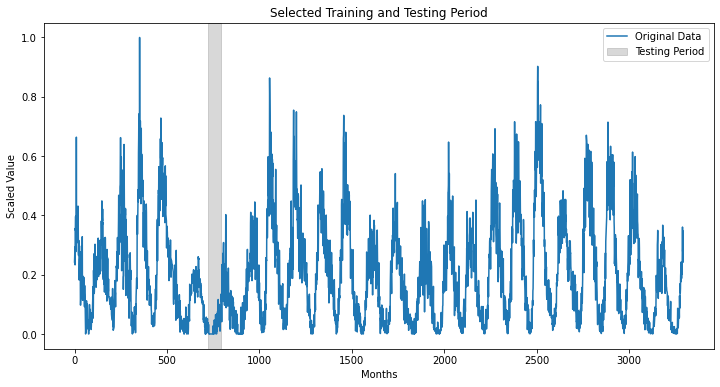

In [30]:
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target_scaled, label='Original Data')
plt.axvspan(train_size, train_size+test_size, color='gray', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Scaled Value')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data: 720 months
Testing data: 72 months


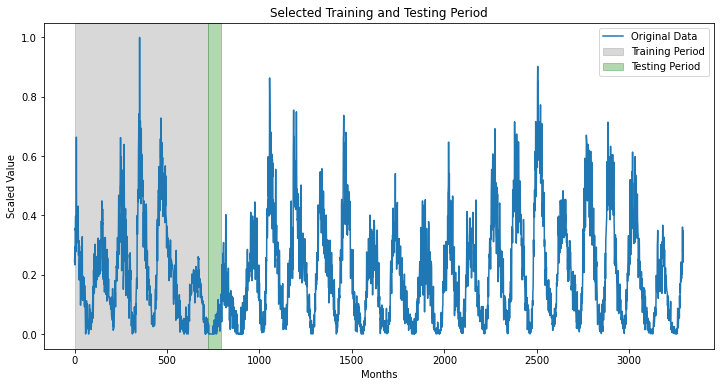

In [31]:
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target_scaled, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Scaled Value')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data: 720 months
Testing data: 72 months
Training data contains zero values.
Testing data contains zero values.


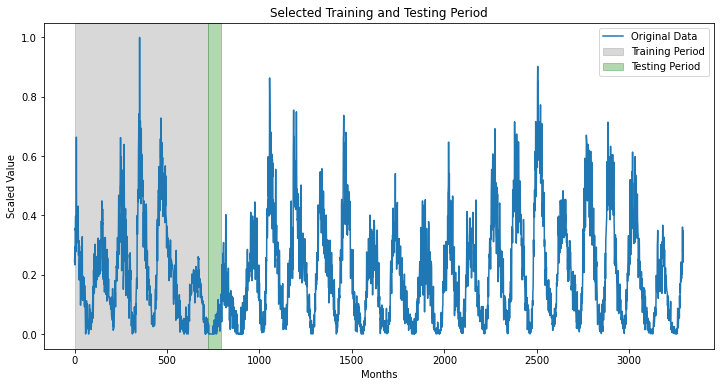

In [32]:
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Check if any values in the training and testing data are zero
train_has_zero = any(value == 0 for value in train_data)
test_has_zero = any(value == 0 for value in test_data)

if train_has_zero:
    print("Training data contains zero values.")
else:
    print("Training data does not contain zero values.")

if test_has_zero:
    print("Testing data contains zero values.")
else:
    print("Testing data does not contain zero values.")

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target_scaled, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Scaled Value')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data: 720 months
Testing data: 72 months
Training data contains zero values.
Testing data contains zero values.


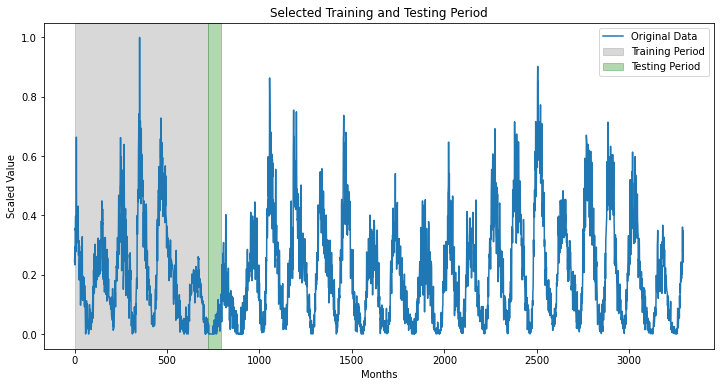

In [33]:
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Check if any values in the training and testing data are zero
train_has_zero = any(value == 0 for value in train_data)
test_has_zero = any(value == 0 for value in test_data)

if train_has_zero:
    print("Training data contains zero values.")
else:
    print("Training data does not contain any zero values.")

if test_has_zero:
    print("Testing data contains zero values.")
else:
    print("Testing data does not contain any zero values.")

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target_scaled, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Scaled Value')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data: 720 months
Testing data: 72 months
Training data contains 13 zero values at the following indexes:
Index: 60, Year: 1754, Month: 1
Index: 76, Year: 1755, Month: 5
Index: 77, Year: 1755, Month: 6
Index: 313, Year: 1775, Month: 2
Index: 592, Year: 1798, Month: 5
Index: 593, Year: 1798, Month: 6
Index: 594, Year: 1798, Month: 7
Index: 607, Year: 1799, Month: 8
Index: 608, Year: 1799, Month: 9
Index: 615, Year: 1800, Month: 4
Index: 707, Year: 1807, Month: 12
Index: 708, Year: 1808, Month: 1
Index: 710, Year: 1808, Month: 3
Testing data contains 24 zero values at the following indexes:
Index: 729, Year: 1809, Month: 10
Index: 730, Year: 1809, Month: 11
Index: 731, Year: 1809, Month: 12
Index: 732, Year: 1810, Month: 1
Index: 733, Year: 1810, Month: 2
Index: 734, Year: 1810, Month: 3
Index: 735, Year: 1810, Month: 4
Index: 736, Year: 1810, Month: 5
Index: 737, Year: 1810, Month: 6
Index: 738, Year: 1810, Month: 7
Index: 739, Year: 1810, Month: 8
Index: 740, Year: 1810, Month:

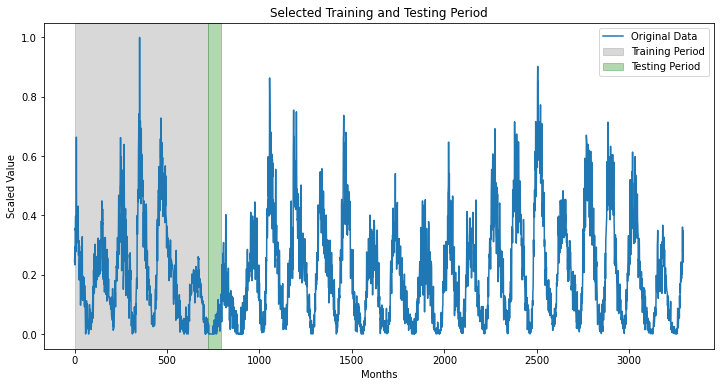

In [34]:
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, data['Year'][i], data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, data['Year'][i+train_size], data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

train_num_zeros = len(train_zero_indexes)
test_num_zeros = len(test_zero_indexes)

if train_num_zeros > 0:
    print(f"Training data contains {train_num_zeros} zero values at the following indexes:")
    for index, year, month in train_zero_indexes:
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Training data does not contain any zero values.")

if test_num_zeros > 0:
    print(f"Testing data contains {test_num_zeros} zero values at the following indexes:")
    for index, year, month in test_zero_indexes:
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Testing data does not contain any zero values.")

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target_scaled, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Scaled Value')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data: 720 months
Testing data: 72 months
Training data contains 9 zero values at the following indexes:
Index: 43, Year: 1878, Month: 8
Index: 50, Year: 1879, Month: 3
Index: 315, Year: 1901, Month: 4
Index: 323, Year: 1901, Month: 12
Index: 325, Year: 1902, Month: 2
Index: 327, Year: 1902, Month: 4
Index: 445, Year: 1912, Month: 2
Index: 460, Year: 1913, Month: 5
Index: 461, Year: 1913, Month: 6
Testing data does not contain any zero values.


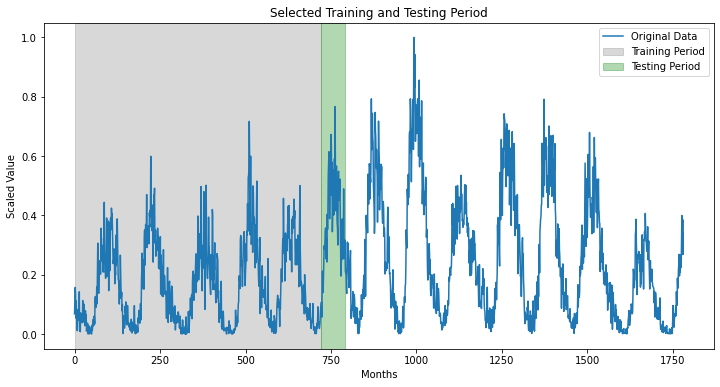

In [36]:
import matplotlib.pyplot as plt

# Filter the data starting from the year 1875
filtered_data = data[data['Year'] >= 1875]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Check if any values in the training and testing data are zero
train_zero_indexes = [i for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [i + train_size for i, value in enumerate(test_data) if value == 0]

train_num_zeros = len(train_zero_indexes)
test_num_zeros = len(test_zero_indexes)

if train_num_zeros > 0:
    print(f"Training data contains {train_num_zeros} zero values at the following indexes:")
    for index in train_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Training data does not contain any zero values.")

if test_num_zeros > 0:
    print(f"Testing data contains {test_num_zeros} zero values at the following indexes:")
    for index in test_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Testing data does not contain any zero values.")

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target_scaled, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Scaled Value')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data: 720 months
Testing data: 72 months
Training data contains 9 zero values at the following indexes:
Index: 43, Year: 1878, Month: 8
Index: 50, Year: 1879, Month: 3
Index: 315, Year: 1901, Month: 4
Index: 323, Year: 1901, Month: 12
Index: 325, Year: 1902, Month: 2
Index: 327, Year: 1902, Month: 4
Index: 445, Year: 1912, Month: 2
Index: 460, Year: 1913, Month: 5
Index: 461, Year: 1913, Month: 6
Testing data does not contain any zero values.


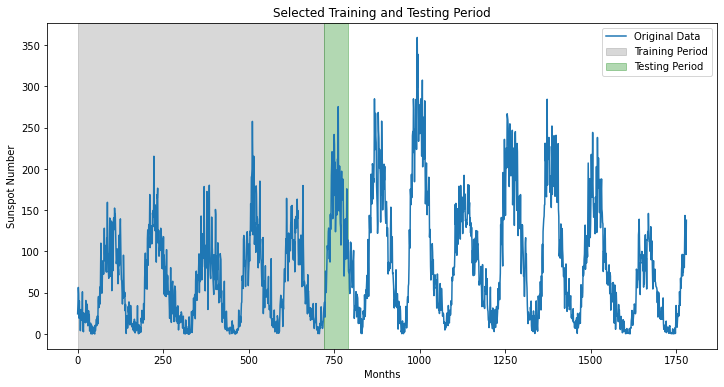

In [37]:
import matplotlib.pyplot as plt

# Filter the data starting from the year 1875
filtered_data = data[data['Year'] >= 1875]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Check if any values in the training and testing data are zero
train_zero_indexes = [i for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [i + train_size for i, value in enumerate(test_data) if value == 0]

train_num_zeros = len(train_zero_indexes)
test_num_zeros = len(test_zero_indexes)

if train_num_zeros > 0:
    print(f"Training data contains {train_num_zeros} zero values at the following indexes:")
    for index in train_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Training data does not contain any zero values.")

if test_num_zeros > 0:
    print(f"Testing data contains {test_num_zeros} zero values at the following indexes:")
    for index in test_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Testing data does not contain any zero values.")

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data: 720 months
Testing data: 72 months
Training data does not contain any zero values.
Testing data does not contain any zero values.


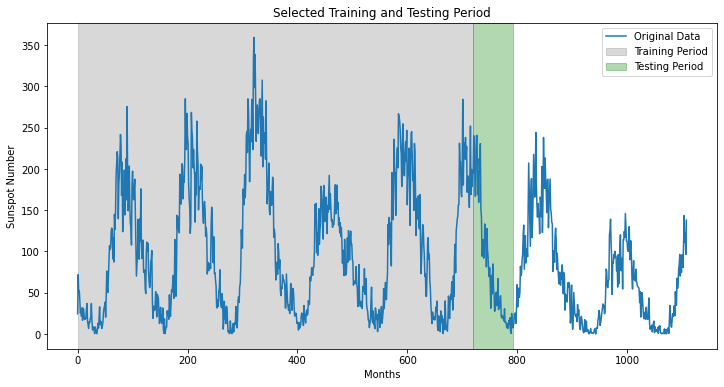

In [38]:
import matplotlib.pyplot as plt

# Filter the data starting from the year 1875
filtered_data = data[data['Year'] >= 1931]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Check if any values in the training and testing data are zero
train_zero_indexes = [i for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [i + train_size for i, value in enumerate(test_data) if value == 0]

train_num_zeros = len(train_zero_indexes)
test_num_zeros = len(test_zero_indexes)

if train_num_zeros > 0:
    print(f"Training data contains {train_num_zeros} zero values at the following indexes:")
    for index in train_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Training data does not contain any zero values.")

if test_num_zeros > 0:
    print(f"Testing data contains {test_num_zeros} zero values at the following indexes:")
    for index in test_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Testing data does not contain any zero values.")

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data: 720 months
Testing data: 72 months
Training data contains 9 zero values at the following indexes:
Index: 43, Year: 1878, Month: 8
Index: 50, Year: 1879, Month: 3
Index: 315, Year: 1901, Month: 4
Index: 323, Year: 1901, Month: 12
Index: 325, Year: 1902, Month: 2
Index: 327, Year: 1902, Month: 4
Index: 445, Year: 1912, Month: 2
Index: 460, Year: 1913, Month: 5
Index: 461, Year: 1913, Month: 6
Testing data does not contain any zero values.


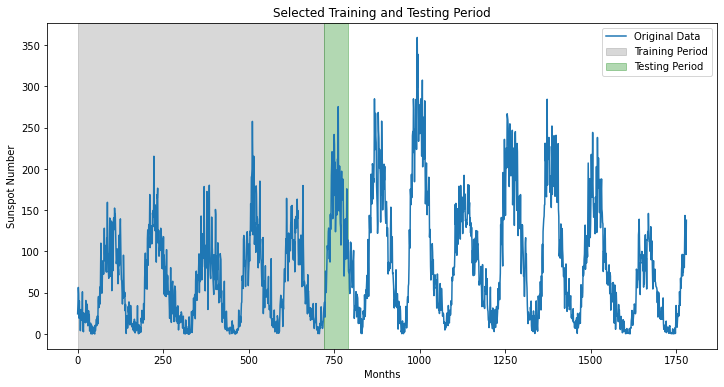

In [44]:
import matplotlib.pyplot as plt

# Filter the data starting from the year 1875
filtered_data = data[data['Year'] >= 1875]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Check if any values in the training and testing data are zero
train_zero_indexes = [i for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [i + train_size for i, value in enumerate(test_data) if value == 0]

train_num_zeros = len(train_zero_indexes)
test_num_zeros = len(test_zero_indexes)

if train_num_zeros > 0:
    print(f"Training data contains {train_num_zeros} zero values at the following indexes:")
    for index in train_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Training data does not contain any zero values.")

if test_num_zeros > 0:
    print(f"Testing data contains {test_num_zeros} zero values at the following indexes:")
    for index in test_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Testing data does not contain any zero values.")

# Extract the years and months for plotting
years = filtered_data['Year'].values
months = filtered_data['Month'].values

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()

C:\Users\Storm\AppData\Local\Temp/ipykernel_11280/3316728139.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Monthly Mean Total Sunspot Number'] = filtered_data['Monthly Mean Total Sunspot Number'].replace(0, np.nan)
C:\Users\Storm\AppData\Local\Temp/ipykernel_11280/3316728139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Monthly Mean Total Sunspot Number'].interpolate(method='linear', inplace=True)


Training data: 720 months
Testing data: 72 months
Training data does not contain any zero values.
Testing data does not contain any zero values.


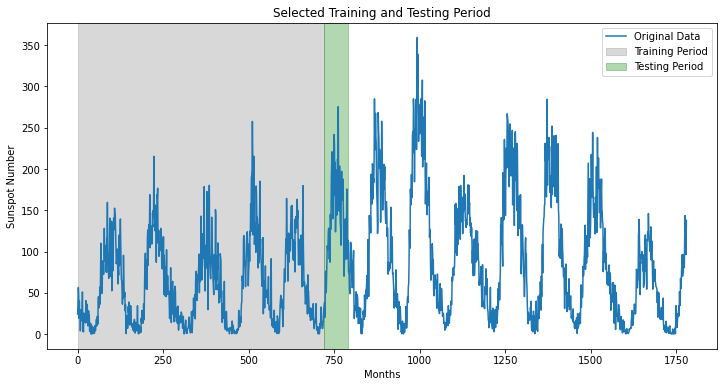

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Filter the data starting from the year 1875
filtered_data = data[data['Year'] >= 1875]

# Handle zero values with interpolation
filtered_data['Monthly Mean Total Sunspot Number'] = filtered_data['Monthly Mean Total Sunspot Number'].replace(0, np.nan)
filtered_data['Monthly Mean Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Print the selected months
print(f"Training data: {train_size} months")
print(f"Testing data: {test_size} months")

# Check if any values in the training and testing data are zero
train_zero_indexes = [i for i, value in enumerate(train_data) if np.isnan(value)]
test_zero_indexes = [i + train_size for i, value in enumerate(test_data) if np.isnan(value)]

train_num_zeros = len(train_zero_indexes)
test_num_zeros = len(test_zero_indexes)

if train_num_zeros > 0:
    print(f"Training data contains {train_num_zeros} zero values at the following indexes:")
    for index in train_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Training data does not contain any zero values.")

if test_num_zeros > 0:
    print(f"Testing data contains {test_num_zeros} zero values at the following indexes:")
    for index in test_zero_indexes:
        year = filtered_data['Year'].values[index]
        month = filtered_data['Month'].values[index]
        print(f"Index: {index}, Year: {year}, Month: {month}")

else:
    print("Testing data does not contain any zero values.")

# Extract the years and months for plotting
years = filtered_data['Year'].values
months = filtered_data['Month'].values

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(target, label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()



Training data:
Number of zero values: 0
Zero value indexes (Year, Month):

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


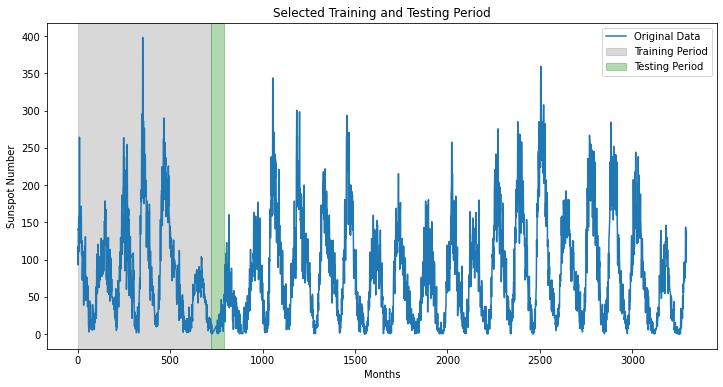

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number']

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data.loc[filtered_data['Monthly Mean Total Sunspot Number'] == 0, 'Monthly Mean Total Sunspot Number'] = np.nan
filtered_data['Monthly Mean Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("Training data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Monthly Mean Total Sunspot Number'], label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data:
Number of zero values: 0
Zero value indexes (Year, Month):

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


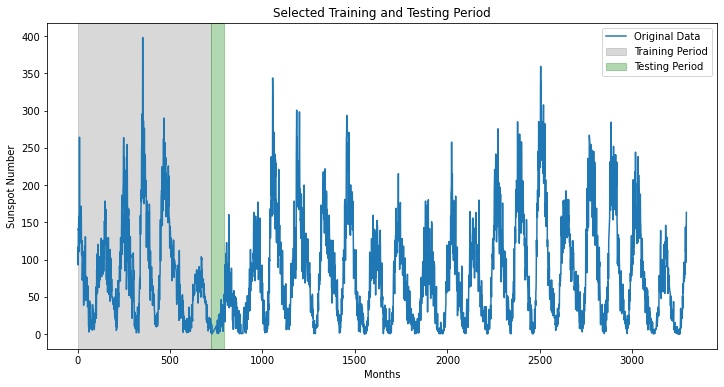

In [50]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmtotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number']

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data.loc[filtered_data['Monthly Mean Total Sunspot Number'] == 0, 'Monthly Mean Total Sunspot Number'] = np.nan
filtered_data['Monthly Mean Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("Training data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Monthly Mean Total Sunspot Number'], label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data:
Number of zero values: 6
Zero value indexes (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


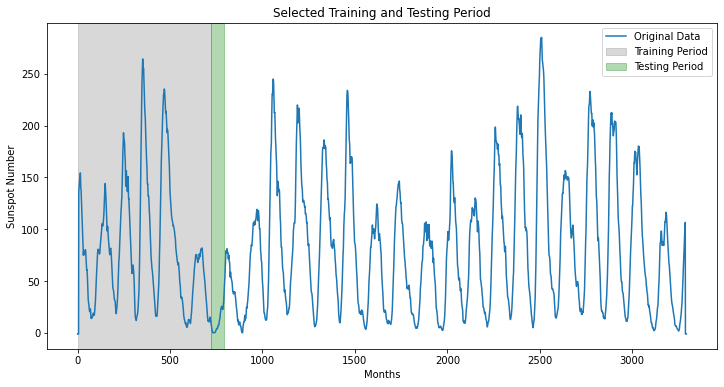

In [53]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("Training data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Missing values before treatment:
Number of missing values: 0
Missing value indexes (Year, Month):

Missing values after treatment:
Number of missing values: 0
Missing value indexes (Year, Month):

Training data:
Number of zero values: 6
Zero value indexes (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


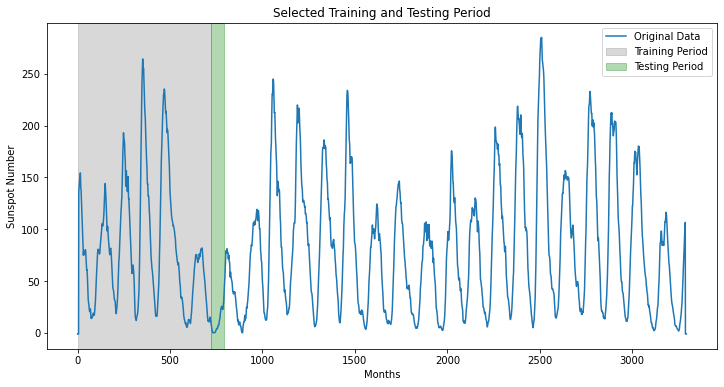

In [55]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Check for missing values before treatment
missing_indexes_before = data[data['13-Month Smoothed Monthly Total Sunspot Number'].isnull()].index.tolist()
print("Missing values before treatment:")
print(f"Number of missing values: {len(missing_indexes_before)}")
print("Missing value indexes (Year, Month):")
for index in missing_indexes_before:
    print(data.loc[index, ['Year', 'Month']].values)

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Check for missing values after treatment
missing_indexes_after = filtered_data[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].isnull()].index.tolist()
print("\nMissing values after treatment:")
print(f"Number of missing values: {len(missing_indexes_after)}")
print("Missing value indexes (Year, Month):")
for index in missing_indexes_after:
    print(filtered_data.loc[index, ['Year', 'Month']].values)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("\nTraining data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data:
Number of zero values: 6
Zero value indexes (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


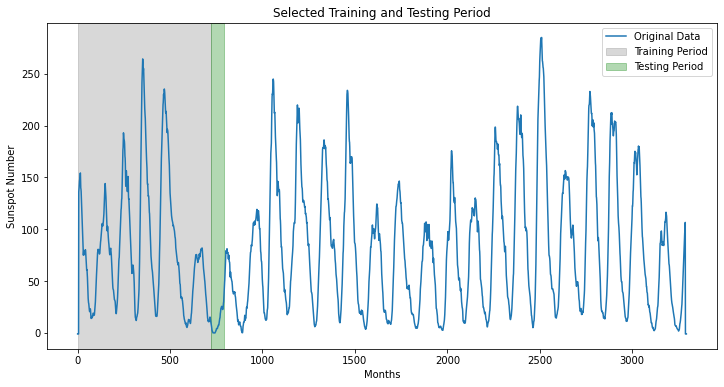

In [57]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("Training data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Visualize the selected months
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
plt.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
plt.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.title('Selected Training and Testing Period')
plt.legend()
plt.show()


Training data:
Number of zero values: 6
Zero value indexes (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


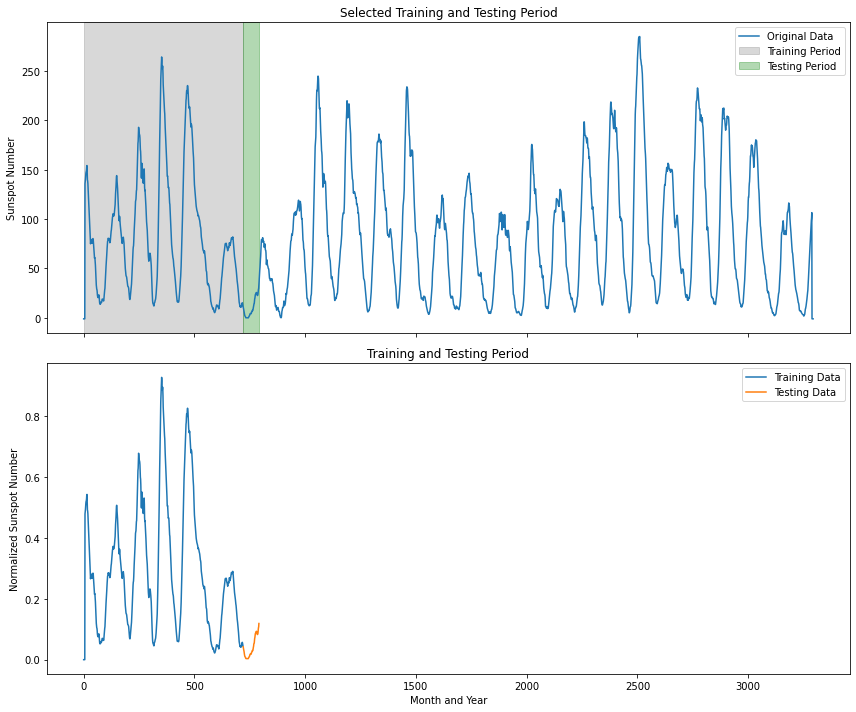

In [61]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("Training data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Visualize the selected months
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

ax2.plot(train_data, label='Training Data')
ax2.plot(range(train_size, train_size+test_size), test_data, label='Testing Data')
ax2.set_xlabel('Month and Year')
ax2.set_ylabel('Normalized Sunspot Number')
ax2.set_title('Training and Testing Period')
ax2.legend()

plt.tight_layout()
plt.show()


Training data:
Number of zero values: 6
Zero value indexes (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


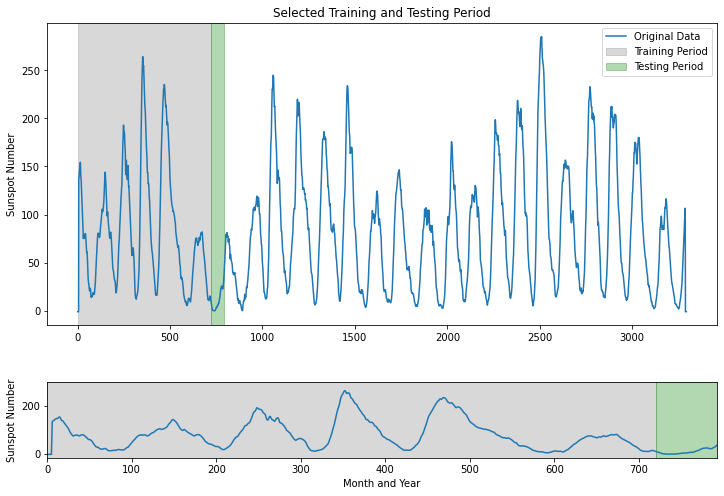

In [73]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io
import matplotlib.gridspec as gridspec

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("Training data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Create the figure and gridspec layout
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1])

# First plot (Full data)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

# Second plot (Zoomed-in version)
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax2.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax2.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax2.set_ylabel('Sunspot Number')
ax2.set_xlabel('Month and Year')
ax2.set_xlim([0, train_size+test_size])
ax2.set_ylim(ax1.get_ylim())  # Use the same y-axis scale as the first plot

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

plt.show()


Training data:
Number of zero values: 6
Zero value indexes (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


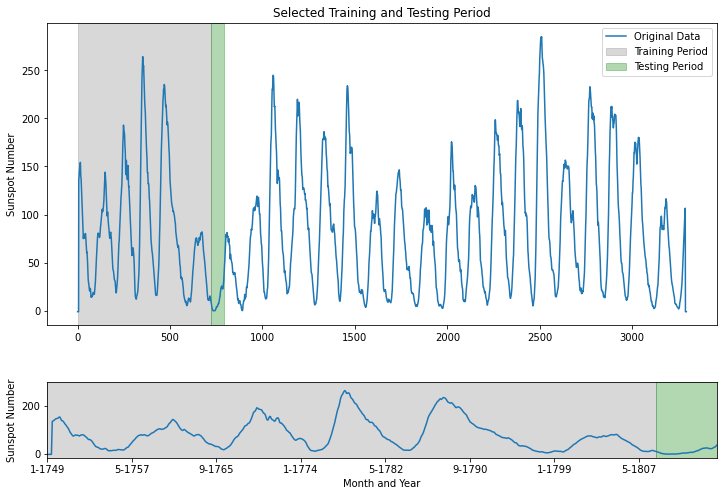

In [74]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("Training data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Create the figure and gridspec layout
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1])

# First plot (Full data)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

# Second plot (Zoomed-in version)
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax2.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax2.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax2.set_ylabel('Sunspot Number')
ax2.set_xlabel('Month and Year')
ax2.set_xlim([0, train_size+test_size])
ax2.set_ylim(ax1.get_ylim())  # Use the same y-axis scale as the first plot

# Format the x-axis tick labels with month and year
def format_month_year(x, pos):
    month = int(x) % 12 + 1
    year = int(x / 12) + filtered_data['Year'].min()
    return f'{month}-{year}'

ax2.xaxis.set_major_formatter(FuncFormatter(format_month_year))

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

plt.show()


Training data:
Number of zero values: 6
Zero value indexes (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)

Testing data:
Number of zero values: 0
Zero value indexes (Year, Month):


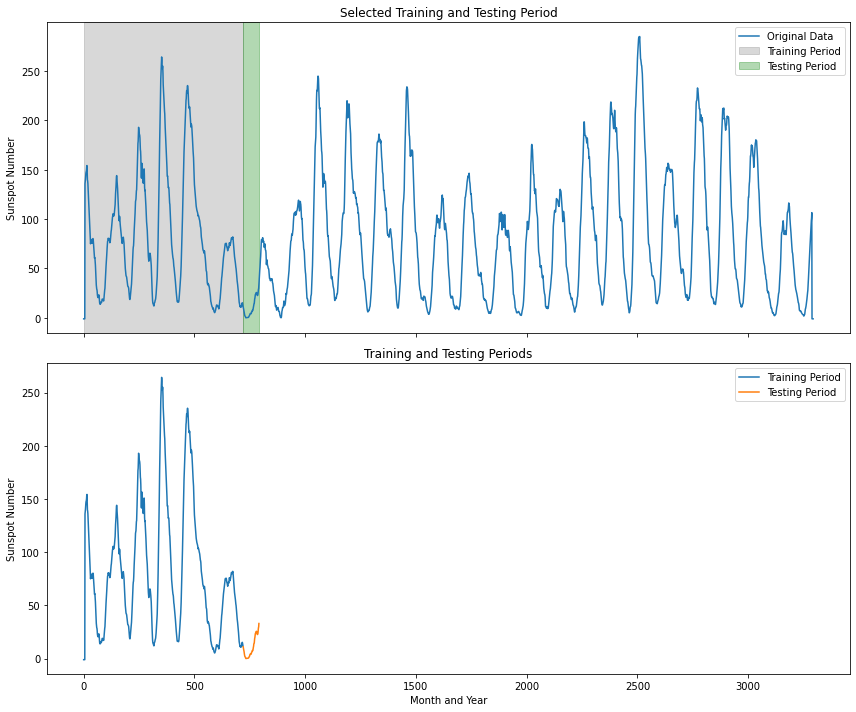

In [79]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check if any values in the training and testing data are zero
train_zero_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Print the number of zero values and their corresponding indexes
print("Training data:")
print(f"Number of zero values: {len(train_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in train_zero_indexes:
    print(index)

print("\nTesting data:")
print(f"Number of zero values: {len(test_zero_indexes)}")
print("Zero value indexes (Year, Month):")
for index in test_zero_indexes:
    print(index)

# Visualize the selected months
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# First plot - Original Data with Training and Testing Periods
ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

# Second plot - Training and Testing Periods
training_data = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].iloc[:train_size]
testing_data = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].iloc[train_size:train_size+test_size]

ax2.plot(training_data, label='Training Period')
ax2.plot(testing_data, label='Testing Period')
ax2.set_xlabel('Month and Year')
ax2.set_ylabel('Sunspot Number')
ax2.set_title('Training and Testing Periods')
ax2.legend()

plt.tight_layout()
plt.show()


Zero values before treatment:
Number of zero values in training data: 0
Zero value indexes in training data (Year, Month):
Number of zero values in testing data: 10
Zero value indexes in testing data (Year, Month):
(734, 1810, 3)
(735, 1810, 4)
(736, 1810, 5)
(737, 1810, 6)
(738, 1810, 7)
(739, 1810, 8)
(740, 1810, 9)
(741, 1810, 10)
(742, 1810, 11)
(743, 1810, 12)

Zero values after treatment:
Number of zero values in training data: 6
Zero value indexes in training data (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)
Number of zero values in testing data: 0
Zero value indexes in testing data (Year, Month):

Missing values in the training data:
Number of missing values: 0
Missing value indexes in the training data (Year, Month):

Missing values in the testing data:
Number of missing values: 0
Missing value indexes in the testing data (Year, Month):


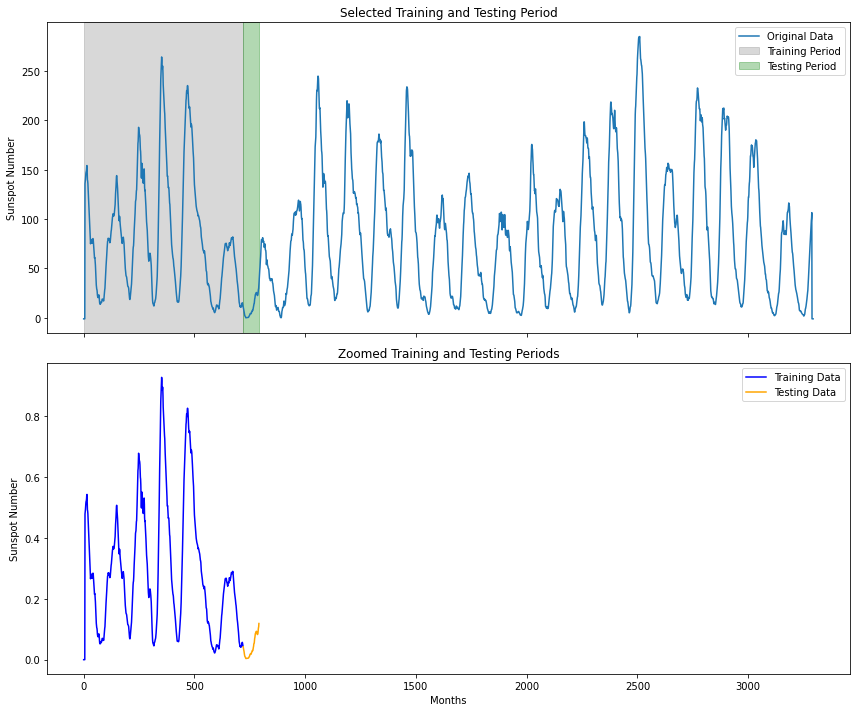

In [85]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Check for zero values before treatment
train_zero_indexes_before = [(i, data['Year'][i], data['Month'][i]) for i, value in enumerate(target[:train_size]) if value == 0]
test_zero_indexes_before = [(i+train_size, data['Year'][i+train_size], data['Month'][i+train_size]) for i, value in enumerate(target[train_size:train_size+test_size]) if value == 0]

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check for zero values after treatment
train_zero_indexes_after = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes_after = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Check for missing values in the training and testing data
train_missing_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if pd.isnull(value)]
test_missing_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if pd.isnull(value)]

# Print the number of zero values and their corresponding indexes before and after treatment
print("Zero values before treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_before)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_before:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_before)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_before:
    print(index)

print("\nZero values after treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_after)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_after:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_after)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_after:
    print(index)

# Print the number of missing values and their corresponding indexes in the training and testing data
print("\nMissing values in the training data:")
print(f"Number of missing values: {len(train_missing_indexes)}")
print("Missing value indexes in the training data (Year, Month):")
for index in train_missing_indexes:
    print(index)
print("\nMissing values in the testing data:")
print(f"Number of missing values: {len(test_missing_indexes)}")
print("Missing value indexes in the testing data (Year, Month):")
for index in test_missing_indexes:
    print(index)

# Visualize the selected months
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

ax2.plot(range(train_size), train_data, label='Training Data', color='blue')
ax2.plot(range(train_size, train_size+test_size), test_data, label='Testing Data', color='orange')
ax2.set_xlabel('Months')
ax2.set_ylabel('Sunspot Number')
ax2.set_title('Zoomed Training and Testing Periods')
ax2.legend()

plt.tight_layout()
plt.show()


Zero values before treatment:
Number of zero values in training data: 0
Zero value indexes in training data (Year, Month):
Number of zero values in testing data: 10
Zero value indexes in testing data (Year, Month):
(734, 1810, 3)
(735, 1810, 4)
(736, 1810, 5)
(737, 1810, 6)
(738, 1810, 7)
(739, 1810, 8)
(740, 1810, 9)
(741, 1810, 10)
(742, 1810, 11)
(743, 1810, 12)

Zero values after treatment:
Number of zero values in training data: 6
Zero value indexes in training data (Year, Month):
(0, 1749, 1)
(1, 1749, 2)
(2, 1749, 3)
(3, 1749, 4)
(4, 1749, 5)
(5, 1749, 6)
Number of zero values in testing data: 0
Zero value indexes in testing data (Year, Month):

Missing values in the training data:
Number of missing values: 0
Missing value indexes in the training data (Year, Month):

Missing values in the testing data:
Number of missing values: 0
Missing value indexes in the testing data (Year, Month):


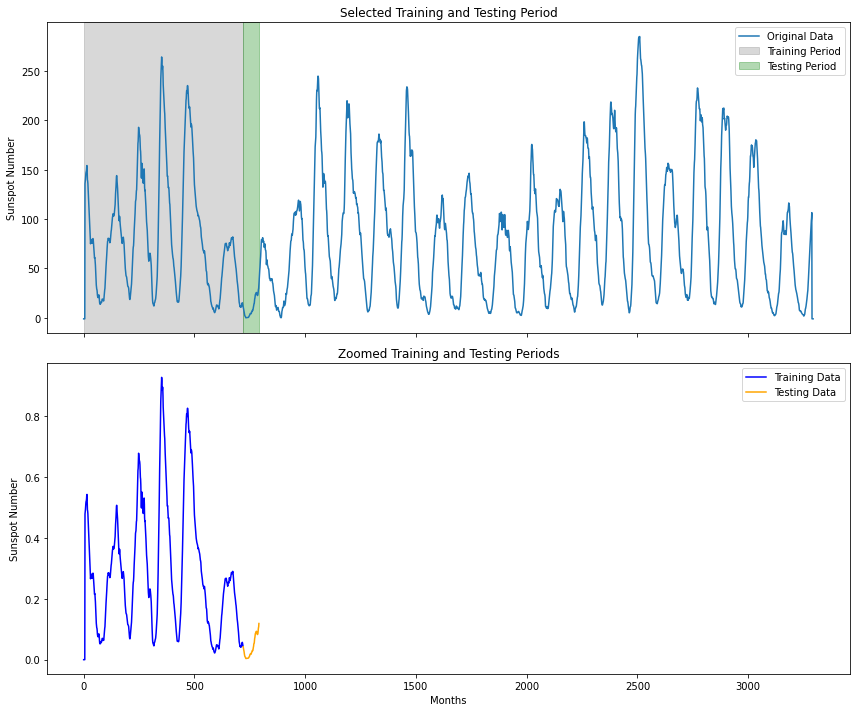

In [86]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = data['13-Month Smoothed Monthly Total Sunspot Number']

# Check for zero values before treatment
train_zero_indexes_before = [(i, data['Year'][i], data['Month'][i]) for i, value in enumerate(target[:train_size]) if value == 0]
test_zero_indexes_before = [(i+train_size, data['Year'][i+train_size], data['Month'][i+train_size]) for i, value in enumerate(target[train_size:train_size+test_size]) if value == 0]

# Treat zero values with interpolation
filtered_data = data.copy()
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check for zero values after treatment
train_zero_indexes_after = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes_after = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Check for missing values in the training and testing data
train_missing_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if pd.isnull(value)]
test_missing_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if pd.isnull(value)]

# Print the number of zero values and their corresponding indexes before and after treatment
print("Zero values before treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_before)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_before:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_before)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_before:
    print(index)

print("\nZero values after treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_after)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_after:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_after)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_after:
    print(index)

# Print the number of missing values and their corresponding indexes in the training and testing data
print("\nMissing values in the training data:")
print(f"Number of missing values: {len(train_missing_indexes)}")
print("Missing value indexes in the training data (Year, Month):")
for index in train_missing_indexes:
    print(index)
print("\nMissing values in the testing data:")
print(f"Number of missing values: {len(test_missing_indexes)}")
print("Missing value indexes in the testing data (Year, Month):")
for index in test_missing_indexes:
    print(index)

# Visualize the selected months
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

ax2.plot(range(train_size), train_data, label='Training Data', color='blue')
ax2.plot(range(train_size, train_size+test_size), test_data, label='Testing Data', color='orange')
ax2.set_xlabel('Months')
ax2.set_ylabel('Sunspot Number')
ax2.set_title('Zoomed Training and Testing Periods')
ax2.legend()

plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)]

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number']

# Check for zero values before treatment
train_zero_indexes_before = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(target[:train_size]) if value == 0]
test_zero_indexes_before = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(target[train_size:train_size+test_size]) if value == 0]

# Treat zero values with interpolation
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Define the training and testing sizes
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

# Split the data into training and testing sets
train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check for zero values after treatment
train_zero_indexes_after = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes_after = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Check for missing values in the training and testing data
train_missing_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if pd.isnull(value)]
test_missing_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if pd.isnull(value)]


# Print the number of zero values and their corresponding indexes before and after treatment
print("Zero values before treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_before)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_before:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_before)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_before:
    print(index)

print("\nZero values after treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_after)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_after:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_after)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_after:
    print(index)

# Print the number of missing values and their corresponding indexes in the training and testing data
print("\nMissing values in the training data:")
print(f"Number of missing values: {len(train_missing_indexes)}")
print("Missing value indexes in the training data (Year, Month):")
for index in train_missing_indexes:
    print(index)
print("\nMissing values in the testing data:")
print(f"Number of missing values: {len(test_missing_indexes)}")
print("Missing value indexes in the testing data (Year, Month):")
for index in test_missing_indexes:
    print(index)

# Visualize the selected months
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

ax2.plot(range(train_size), train_data, label='Training Data', color='blue')
ax2.plot(range(train_size, train_size+test_size), test_data, label='Testing Data', color='orange')
ax2.set_xlabel('Months')
ax2.set_ylabel('Sunspot Number')
ax2.set_title('Zoomed Training and Testing Periods')
ax2.legend()

plt.tight_layout()
plt.show()


NameError: name 'train_size' is not defined

C:\Users\Storm\AppData\Local\Temp/ipykernel_9944/1842195214.py:25: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_zero_indexes_before = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(target[:train_size]) if value == 0]
C:\Users\Storm\AppData\Local\Temp/ipykernel_9944/1842195214.py:26: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test_zero_indexes_before = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train

Zero values before treatment:
Number of zero values in training data: 0
Zero value indexes in training data (Year, Month):
Number of zero values in testing data: 0
Zero value indexes in testing data (Year, Month):

Zero values after treatment:
Number of zero values in training data: 0
Zero value indexes in training data (Year, Month):
Number of zero values in testing data: 0
Zero value indexes in testing data (Year, Month):

Missing values in the training data:
Number of missing values: 0
Missing value indexes in the training data (Year, Month):

Missing values in the testing data:
Number of missing values: 0
Missing value indexes in the testing data (Year, Month):


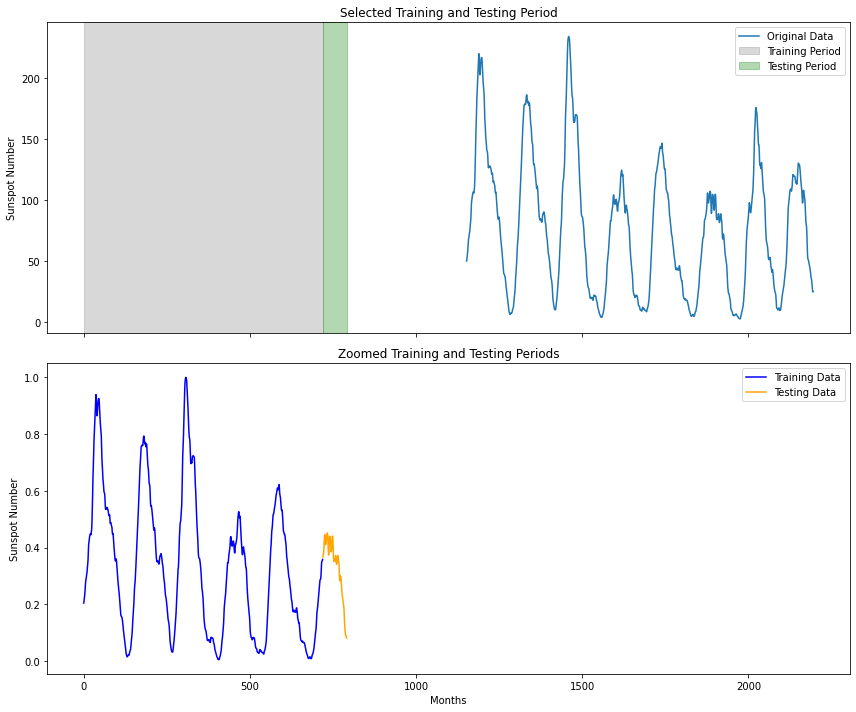

In [3]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io
  
            
# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)]

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number']

# Define the training and testing sizes
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

# Check for zero values before treatment
train_zero_indexes_before = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(target[:train_size]) if value == 0]
test_zero_indexes_before = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(target[train_size:train_size+test_size]) if value == 0]

# Treat zero values with interpolation
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check for zero values after treatment
train_zero_indexes_after = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes_after = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Check for missing values in the training and testing data
train_missing_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if pd.isnull(value)]
test_missing_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if pd.isnull(value)]

# Print the number of zero values and their corresponding indexes before and after treatment
print("Zero values before treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_before)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_before:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_before)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_before:
    print(index)

print("\nZero values after treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_after)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_after:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_after)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_after:
    print(index)

# Print the number of missing values and their corresponding indexes in the training and testing data
print("\nMissing values in the training data:")
print(f"Number of missing values: {len(train_missing_indexes)}")
print("Missing value indexes in the training data (Year, Month):")
for index in train_missing_indexes:
    print(index)
print("\nMissing values in the testing data:")
print(f"Number of missing values: {len(test_missing_indexes)}")
print("Missing value indexes in the testing data (Year, Month):")
for index in test_missing_indexes:
    print(index)

# Visualize the selected months
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

ax2.plot(range(train_size), train_data, label='Training Data', color='blue')
ax2.plot(range(train_size, train_size+test_size), test_data, label='Testing Data', color='orange')
ax2.set_xlabel('Months')
ax2.set_ylabel('Sunspot Number')
ax2.set_title('Zoomed Training and Testing Periods')
ax2.legend()

plt.tight_layout()
plt.show()


Zero values before treatment:
Number of zero values in training data: 0
Zero value indexes in training data (Year, Month):
Number of zero values in testing data: 0
Zero value indexes in testing data (Year, Month):

Zero values after treatment:
Number of zero values in training data: 0
Zero value indexes in training data (Year, Month):
Number of zero values in testing data: 0
Zero value indexes in testing data (Year, Month):

Missing values in the training data:
Number of missing values: 0
Missing value indexes in the training data (Year, Month):

Missing values in the testing data:
Number of missing values: 0
Missing value indexes in the testing data (Year, Month):


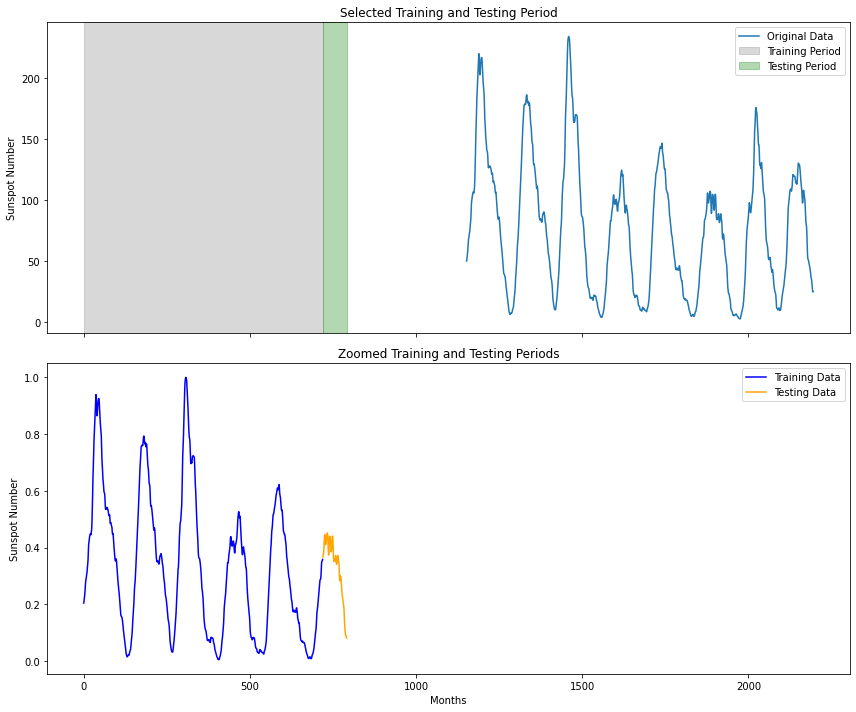

In [4]:

import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number']

# Define the training and testing sizes
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

# Check for zero values before treatment
train_zero_indexes_before = [(i, filtered_data.loc[i, 'Year'], filtered_data.loc[i, 'Month']) for i in range(train_size) if target.iloc[i] == 0]
test_zero_indexes_before = [(i+train_size, filtered_data.loc[i+train_size, 'Year'], filtered_data.loc[i+train_size, 'Month']) for i in range(test_size) if target.iloc[i+train_size] == 0]

# Treat zero values with interpolation
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check for zero values after treatment
train_zero_indexes_after = [(i, filtered_data.loc[i, 'Year'], filtered_data.loc[i, 'Month']) for i in range(train_size) if train_data[i] == 0]
test_zero_indexes_after = [(i+train_size, filtered_data.loc[i+train_size, 'Year'], filtered_data.loc[i+train_size, 'Month']) for i in range(test_size) if test_data[i] == 0]

# Check for missing values in the training and testing data
train_missing_indexes = [(i, filtered_data.loc[i, 'Year'], filtered_data.loc[i, 'Month']) for i in range(train_size) if pd.isnull(train_data[i])]
test_missing_indexes = [(i+train_size, filtered_data.loc[i+train_size, 'Year'], filtered_data.loc[i+train_size, 'Month']) for i in range(test_size) if pd.isnull(test_data[i])]

# Print the number of zero values and their corresponding indexes before and after treatment
print("Zero values before treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_before)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_before:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_before)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_before:
    print(index)

print("\nZero values after treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_after)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_after:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_after)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_after:
    print(index)

# Print the number of missing values and their corresponding indexes in the training and testing data
print("\nMissing values in the training data:")
print(f"Number of missing values: {len(train_missing_indexes)}")
print("Missing value indexes in the training data (Year, Month):")
for index in train_missing_indexes:
    print(index)
print("\nMissing values in the testing data:")
print(f"Number of missing values: {len(test_missing_indexes)}")
print("Missing value indexes in the testing data (Year, Month):")
for index in test_missing_indexes:
    print(index)

# Visualize the selected months
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

ax2.plot(range(train_size), train_data, label='Training Data', color='blue')
ax2.plot(range(train_size, train_size+test_size), test_data, label='Testing Data', color='orange')
ax2.set_xlabel('Months')
ax2.set_ylabel('Sunspot Number')
ax2.set_title('Zoomed Training and Testing Periods')
ax2.legend()

plt.tight_layout()
plt.show()
      
      

C:\Users\Storm\AppData\Local\Temp/ipykernel_9944/3728554283.py:25: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_zero_indexes_before = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(target[:train_size]) if value == 0]
C:\Users\Storm\AppData\Local\Temp/ipykernel_9944/3728554283.py:26: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test_zero_indexes_before = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train

Zero values before treatment:
Number of zero values in training data: 0
Zero value indexes in training data (Year, Month):
Number of zero values in testing data: 0
Zero value indexes in testing data (Year, Month):

Zero values after treatment:
Number of zero values in training data: 0
Zero value indexes in training data (Year, Month):
Number of zero values in testing data: 0
Zero value indexes in testing data (Year, Month):

Missing values in the training data:
Number of missing values: 0
Missing value indexes in the training data (Year, Month):

Missing values in the testing data:
Number of missing values: 0
Missing value indexes in the testing data (Year, Month):


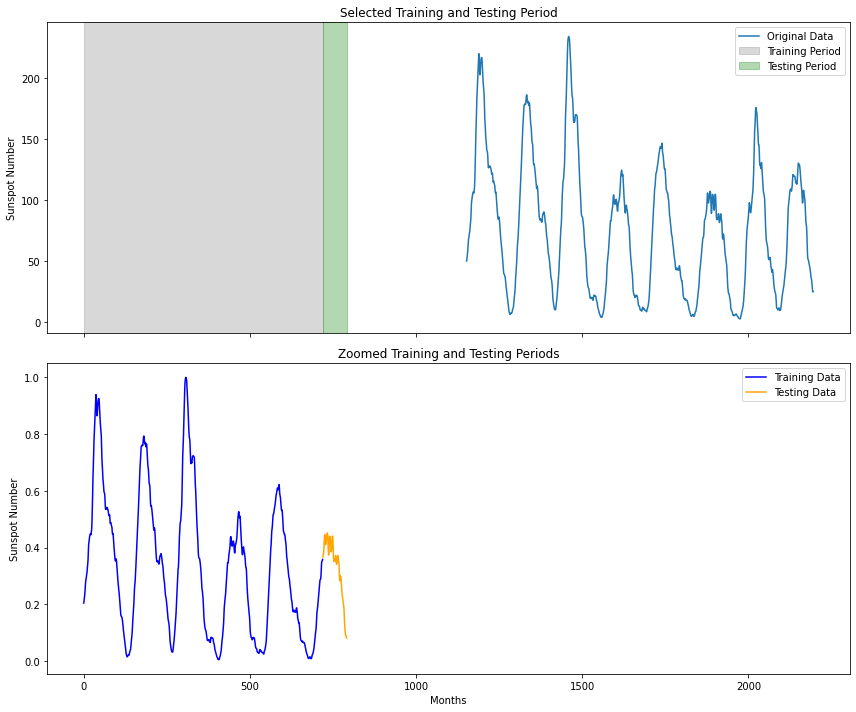

In [5]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import io

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)]

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number']

# Set the number of months for training and testing
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

# Check for zero values before treatment
train_zero_indexes_before = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(target[:train_size]) if value == 0]
test_zero_indexes_before = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(target[train_size:train_size+test_size]) if value == 0]

# Treat zero values with interpolation
filtered_data.loc[filtered_data['13-Month Smoothed Monthly Total Sunspot Number'] == 0, '13-Month Smoothed Monthly Total Sunspot Number'] = np.nan
filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].interpolate(method='linear', inplace=True)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Check for zero values after treatment
train_zero_indexes_after = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if value == 0]
test_zero_indexes_after = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if value == 0]

# Check for missing values in the training and testing data
train_missing_indexes = [(i, filtered_data['Year'][i], filtered_data['Month'][i]) for i, value in enumerate(train_data) if pd.isnull(value)]
test_missing_indexes = [(i+train_size, filtered_data['Year'][i+train_size], filtered_data['Month'][i+train_size]) for i, value in enumerate(test_data) if pd.isnull(value)]

# Print the number of zero values and their corresponding indexes before and after treatment
print("Zero values before treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_before)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_before:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_before)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_before:
    print(index)

print("\nZero values after treatment:")
print(f"Number of zero values in training data: {len(train_zero_indexes_after)}")
print("Zero value indexes in training data (Year, Month):")
for index in train_zero_indexes_after:
    print(index)
print(f"Number of zero values in testing data: {len(test_zero_indexes_after)}")
print("Zero value indexes in testing data (Year, Month):")
for index in test_zero_indexes_after:
    print(index)

# Print the number of missing values and their corresponding indexes in the training and testing data
print("\nMissing values in the training data:")
print(f"Number of missing values: {len(train_missing_indexes)}")
print("Missing value indexes in the training data (Year, Month):")
for index in train_missing_indexes:
    print(index)
print("\nMissing values in the testing data:")
print(f"Number of missing values: {len(test_missing_indexes)}")
print("Missing value indexes in the testing data (Year, Month):")
for index in test_missing_indexes:
    print(index)

# Visualize the selected months
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

ax1.plot(filtered_data['13-Month Smoothed Monthly Total Sunspot Number'], label='Original Data')
ax1.axvspan(0, train_size, color='gray', alpha=0.3, label='Training Period')
ax1.axvspan(train_size, train_size+test_size, color='green', alpha=0.3, label='Testing Period')
ax1.set_ylabel('Sunspot Number')
ax1.set_title('Selected Training and Testing Period')
ax1.legend()

ax2.plot(range(train_size), train_data, label='Training Data', color='blue')
ax2.plot(range(train_size, train_size+test_size), test_data, label='Testing Data', color='orange')
ax2.set_xlabel('Months')
ax2.set_ylabel('Sunspot Number')
ax2.set_title('Zoomed Training and Testing Periods')
ax2.legend()

plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': y_test.ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    start_time = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=100, batch_size=32, verbose=0)
    predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame({'True Value': y_test.ravel()})
df_forecasts = pd.DataFrame(all_predictions)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


LinearRegression RMSE: 0.01575
LinearRegression MAE: 0.01296
LinearRegression R-squared: 0.97716
LinearRegression Training Time: 0.12183 seconds
CPU Usage: 22.3 MHz
Memory Used: 19977.75390625 MB

SVR RMSE: 0.06257
SVR MAE: 0.06001
SVR R-squared: 0.63965
SVR Training Time: 0.01319 seconds
CPU Usage: 100.0 MHz
Memory Used: 19977.76171875 MB

AdaBoostRegressor RMSE: 0.01790
AdaBoostRegressor MAE: 0.01468
AdaBoostRegressor R-squared: 0.97052
AdaBoostRegressor Training Time: 0.13392 seconds
CPU Usage: 82.9 MHz
Memory Used: 19977.00390625 MB

RandomForestRegressor RMSE: 0.01817
RandomForestRegressor MAE: 0.01415
RandomForestRegressor R-squared: 0.96961
RandomForestRegressor Training Time: 0.27426 seconds
CPU Usage: 39.5 MHz
Memory Used: 19977.37890625 MB

GradientBoostingRegressor RMSE: 0.01655
GradientBoostingRegressor MAE: 0.01357
GradientBoostingRegressor R-squared: 0.97479
GradientBoostingRegressor Training Time: 0.09106 seconds
CPU Usage: 33.9 MHz
Memory Used: 19974.5 MB

3/3 [========

In [8]:
df_forecasts[0:30]

True Value  LinearRegression       SVR  AdaBoostRegressor  \
0     0.374082          0.367750  0.430761           0.374861   
1     0.381857          0.374216  0.435762           0.375246   
2     0.396976          0.381975  0.441611           0.385411   
3     0.425054          0.397062  0.452543           0.396752   
4     0.445788          0.425082  0.471499           0.419803   
5     0.443197          0.445773  0.484590           0.434278   
6     0.424190          0.443187  0.482988           0.430442   
7     0.410367          0.424220  0.470939           0.419803   
8     0.417279          0.410425  0.461783           0.410464   
9     0.425054          0.417322  0.466406           0.411111   
10    0.432397          0.425082  0.471499           0.419803   
11    0.445788          0.432410  0.476212           0.424735   
12    0.451836          0.445773  0.484590           0.434278   
13    0.448812          0.451808  0.488292           0.449842   
14    0.430670          0.448791  0.486447           0.434278   
15    0.391793          0.430686  0.475111           0.424735   
16    0.374082          0.391889  0.448858           0.393559   
17    0.386177          0.374216  0.435762           0.375246   
18    0.418575          0.386285  0.444792           0.385411   
19    0.440605          0.418616  0.467263           0.411111   
20    0.438445          0.440600  0.481377           0.430442   
21    0.433261          0.438445  0.480028           0.430442   
22    0.422030          0.433272  0.476760           0.429374   
23    0.399136          0.422064  0.469532           0.412545   
24    0.384881          0.399218  0.454060           0.401679   
25    0.395248          0.384992  0.443843           0.385411   
26    0.418575          0.395338  0.451322           0.393559   
27    0.439309          0.418616  0.467263           0.411111   
28    0.441037          0.439307  0.480569           0.430442   
29    0.424622          0.441031  0.481647           0.430442   

    RandomForestRegressor  GradientBoostingRegressor      LSTM  Stacked LSTM  \
0                0.362033                   0.362697  0.363488      0.363822   
1                0.381518                   0.375427  0.369960      0.370306   
2                0.385780                   0.388591  0.377734      0.378088   
3                0.386212                   0.396796  0.392874      0.393223   
4                0.410937                   0.416935  0.421076      0.421334   
5                0.452156                   0.446296  0.441968      0.442091   
6                0.423702                   0.432512  0.439354      0.439497   
7                0.411084                   0.416935  0.420207      0.420469   
8                0.408712                   0.407186  0.406311      0.406629   
9                0.429143                   0.420441  0.413256      0.413549   
10               0.410937                   0.416935  0.421076      0.421334   
11               0.429317                   0.435600  0.428469      0.428686   
12               0.452156                   0.446296  0.441968      0.442091   
13               0.447948                   0.446296  0.448072      0.448144   
14               0.446199                   0.446296  0.445020      0.445118   
15               0.436674                   0.435600  0.426729      0.426956   
16               0.383674                   0.389317  0.387680      0.388033   
17               0.381518                   0.375427  0.369960      0.370306   
18               0.375322                   0.388591  0.382056      0.382412   
19               0.430860                   0.420441  0.414559      0.414847   
20               0.434313                   0.432512  0.436740      0.436902   
21               0.418270                   0.432512  0.434563      0.434740   
22               0.449235                   0.438821  0.429339      0.429551   
23               0.420246                   0.419349  0.418034      

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil
import io
import requests
import tensorflow as tf


# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
#scaler = MinMaxScaler(feature_range=(0, 1))
#target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': y_test.ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

    

    
# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    model.compile(loss='mean_squared_error', optimizer='adam')
    start_time = time.time()
    model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=100, batch_size=32, verbose=0)

    predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions_1845_to_1931.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame({'True Value': y_test.ravel()})
df_forecasts = pd.DataFrame(all_predictions)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


LinearRegression RMSE: 3.64617
LinearRegression MAE: 2.99911
LinearRegression R-squared: 0.97716
LinearRegression Training Time: 0.00000 seconds
CPU Usage: 28.1 MHz
Memory Used: 18315.95703125 MB

SVR RMSE: 3.60537
SVR MAE: 2.90223
SVR R-squared: 0.97767
SVR Training Time: 0.03987 seconds
CPU Usage: 87.5 MHz
Memory Used: 18315.95703125 MB

AdaBoostRegressor RMSE: 3.85162
AdaBoostRegressor MAE: 3.11372
AdaBoostRegressor R-squared: 0.97452
AdaBoostRegressor Training Time: 0.05632 seconds
CPU Usage: 70.6 MHz
Memory Used: 18315.95703125 MB

RandomForestRegressor RMSE: 4.19875
RandomForestRegressor MAE: 3.29477
RandomForestRegressor R-squared: 0.96972
RandomForestRegressor Training Time: 0.14768 seconds
CPU Usage: 54.8 MHz
Memory Used: 18317.21484375 MB

GradientBoostingRegressor RMSE: 3.83890
GradientBoostingRegressor MAE: 3.14840
GradientBoostingRegressor R-squared: 0.97469
GradientBoostingRegressor Training Time: 0.03086 seconds
CPU Usage: 37.5 MHz
Memory Used: 18317.28125 MB

3/3 [=====

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil
import io
import requests
import tensorflow as tf


# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
#scaler = MinMaxScaler(feature_range=(0, 1))
#target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': y_test.ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

    

    
# Train and evaluate each deep learning model
for model, model_name in deep_learning_models:
    model.compile(loss='mean_squared_error', optimizer='adam')
    start_time = time.time()
    model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=100, batch_size=32, verbose=0)

    predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions_1931_to_2008.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame({'True Value': y_test.ravel()})
df_forecasts = pd.DataFrame(all_predictions)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


LinearRegression RMSE: 4.02865
LinearRegression MAE: 3.01036
LinearRegression R-squared: 0.99624
LinearRegression Training Time: 0.00275 seconds
CPU Usage: 30.7 MHz
Memory Used: 18245.28125 MB

SVR RMSE: 6.00749
SVR MAE: 4.94510
SVR R-squared: 0.99165
SVR Training Time: 0.02421 seconds
CPU Usage: 75.0 MHz
Memory Used: 18245.28125 MB

AdaBoostRegressor RMSE: 5.39745
AdaBoostRegressor MAE: 4.47076
AdaBoostRegressor R-squared: 0.99326
AdaBoostRegressor Training Time: 0.05713 seconds
CPU Usage: 63.2 MHz
Memory Used: 18245.28125 MB

RandomForestRegressor RMSE: 4.98902
RandomForestRegressor MAE: 3.34502
RandomForestRegressor R-squared: 0.99424
RandomForestRegressor Training Time: 0.12567 seconds
CPU Usage: 47.1 MHz
Memory Used: 18250.06640625 MB

GradientBoostingRegressor RMSE: 4.18607
GradientBoostingRegressor MAE: 2.97975
GradientBoostingRegressor R-squared: 0.99595
GradientBoostingRegressor Training Time: 0.03331 seconds
CPU Usage: 40.7 MHz
Memory Used: 18250.06640625 MB

3/3 [===========

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Define a dictionary to store the predictions
all_predictions = {'True Value': y_test.ravel()}

# Train and evaluate each model
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test).ravel()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    training_time = time.time() - start_time

    model_name = model.__class__.__name__
    all_predictions[model_name] = predictions

    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Define the deep learning models to be evaluated
deep_learning_models = [
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "LSTM"),
    (Sequential([LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True), LSTM(32), Dense(1)]), "Stacked LSTM"),
    (Sequential([Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])), Dense(1)]), "Bidirectional LSTM"),
    (Sequential([GRU(32, input_shape=(1, X_train.shape[1])), Dense(1)]), "GRU")
]

# Hyperparameter grids for the deep learning models
hyperparameter_grids = [
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [32, 64, 128], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]}
]

# Train and evaluate each deep learning model with hyperparameter tuning
for (model, model_name), hyperparameters in zip(deep_learning_models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train)
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)

    # Store the predictions of the best model
    all_predictions[model_name] = best_predictions

    # Print the best parameters and evaluation metrics
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(all_predictions)
df_predictions.to_csv('predictions_1845_to_1931.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame({'True Value': y_test.ravel()})
df_forecasts = pd.DataFrame(all_predictions)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


LinearRegression RMSE: 0.01575
LinearRegression MAE: 0.01296
LinearRegression R-squared: 0.97716
LinearRegression Training Time: 0.00236 seconds
CPU Usage: 30.5 MHz
Memory Used: 18537.8203125 MB

SVR RMSE: 0.06257
SVR MAE: 0.06001
SVR R-squared: 0.63965
SVR Training Time: 0.00325 seconds
CPU Usage: 87.5 MHz
Memory Used: 18537.71875 MB

AdaBoostRegressor RMSE: 0.01790
AdaBoostRegressor MAE: 0.01468
AdaBoostRegressor R-squared: 0.97052
AdaBoostRegressor Training Time: 0.06597 seconds
CPU Usage: 56.2 MHz
Memory Used: 18535.44140625 MB

RandomForestRegressor RMSE: 0.01817
RandomForestRegressor MAE: 0.01415
RandomForestRegressor R-squared: 0.96961
RandomForestRegressor Training Time: 0.15658 seconds
CPU Usage: 52.8 MHz
Memory Used: 18547.0625 MB

GradientBoostingRegressor RMSE: 0.01655
GradientBoostingRegressor MAE: 0.01357
GradientBoostingRegressor R-squared: 0.97479
GradientBoostingRegressor Training Time: 0.03790 seconds
CPU Usage: 43.8 MHz
Memory Used: 18544.41796875 MB



TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x000001B87F7C8BE0>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
#scaler = MinMaxScaler(feature_range=(0, 1))
#target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]

# Train and evaluate each model with hyperparameter tuning
for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

Best parameters for LinearRegression: {}
LinearRegression RMSE: 3.64617
LinearRegression MAE: 2.99911
LinearRegression R-squared: 0.97716
LinearRegression Training Time: 0.01875 seconds
CPU Usage: 24.1 MHz
Memory Used: 18965.28515625 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.001}
SVR RMSE: 3.60278
SVR MAE: 2.96804
SVR R-squared: 0.97770
SVR Training Time: 0.25171 seconds
CPU Usage: 83.2 MHz
Memory Used: 18970.9765625 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 4.07018
AdaBoostRegressor MAE: 3.39376
AdaBoostRegressor R-squared: 0.97154
AdaBoostRegressor Training Time: 1.95246 seconds
CPU Usage: 71.6 MHz
Memory Used: 18963.76171875 MB

Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 200}
RandomForestRegressor RMSE: 3.80354
RandomForestRegressor MAE: 3.15783
RandomForestRegressor R-squared: 0.97515
RandomForestRegressor Training Time: 1.33669 seconds
CPU Usage: 78.4 MHz
Memory Used: 18

In [4]:

###################################### NOT CORRECT PERIOD ################################

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
#scaler = MinMaxScaler(feature_range=(0, 1))
#target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, input_shape=(1, X_train.shape[1]))))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(GRU(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

deep_learning_models = [
    (KerasRegressor(build_fn=create_lstm_model), "LSTM"),
    (KerasRegressor(build_fn=create_stacked_lstm_model), "Stacked LSTM"),
    (KerasRegressor(build_fn=create_bidirectional_lstm_model), "Bidirectional LSTM"),
    (KerasRegressor(build_fn=create_gru_model), "GRU")
]

# Hyperparameter grids for the deep learning models
hyperparameter_grids = [
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [32, 64, 128], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]}
]

# Train and evaluate each deep learning model with hyperparameter tuning
for (model, model_name), hyperparameters in zip(deep_learning_models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train)
    training_time = time.time() - start_time

    # Get the best model and
    predictions = grid_search.best_estimator_.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store the predictions of the best model
    all_predictions[model_name] = predictions

    # Print the best parameters and evaluation metrics
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()


C:\Users\Storm\AppData\Local\Temp/ipykernel_15628/721879544.py:87: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  (KerasRegressor(build_fn=create_lstm_model), "LSTM"),
C:\Users\Storm\AppData\Local\Temp/ipykernel_15628/721879544.py:88: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  (KerasRegressor(build_fn=create_stacked_lstm_model), "Stacked LSTM"),
C:\Users\Storm\AppData\Local\Temp/ipykernel_15628/721879544.py:89: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  (KerasRegressor(build_fn=create_bidirectional_lstm_model), "Bidirectional LSTM"),
C:\Users\St

3/3 [==============================] - 1s 2ms/step


NameError: name 'all_predictions' is not defined

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scikeras.wrappers import KerasRegressor

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1875 to 1931)
filtered_data = data[(data['Year'] >= 1875) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, input_shape=(1, X_train.shape[1]))))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(GRU(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

deep_learning_models = [
    (create_lstm_model, "LSTM"),
    (create_stacked_lstm_model, "Stacked LSTM"),
    (create_bidirectional_lstm_model, "Bidirectional LSTM"),
    (create_gru_model, "GRU")
]

# Hyperparameter grids for the deep learning models
hyperparameter_grids = [
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [32, 64, 128], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]},
    {'units': [16, 32, 64], 'dropout': [0.2, 0.4, 0.6]}
]

# Train and evaluate each deep learning model with hyperparameter tuning
all_predictions = {}

for (create_model, model_name), hyperparameters in zip(deep_learning_models, hyperparameter_grids):
    # Create a grid search instance
    model = KerasRegressor(build_fn=create_model)
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train)
    training_time = time.time() - start_time

    # Get the best model and predictions
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store the predictions of the best model
    all_predictions[model_name] = predictions

    # Print the best parameters and evaluation metrics
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()


ImportError: cannot import name '_fit_context' from 'sklearn.base' (C:\Users\Storm\anaconda3\lib\site-packages\sklearn\base.py)

In [17]:
!pip install scikeras


  Using cached scikeras-0.11.0-py3-none-any.whl (27 kB)
     ---------------------------------------- 9.3/9.3 MB 120.1 kB/s eta 0:00:00
     ------------------------------------ 302.0/302.0 kB 190.5 kB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.19.1 requires scikit-learn<1.3.0,>=0.24.0, but you have scikit-learn 1.3.0 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


      Successfully uninstalled scikit-learn-0.24.2


In [19]:
pip install -U scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1875 to 1931)
filtered_data = data[(data['Year'] >= 1875) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', run_eagerly=True)
    return model

def create_stacked_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', run_eagerly=True)
    return model

def create_bidirectional_lstm_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, input_shape=(1, X_train.shape[1]))))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', run_eagerly=True)
    return model

def create_gru_model(units=32, dropout=0.2):
    model = Sequential()
    model.add(GRU(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', run_eagerly=True)
    return model

deep_learning_models = [
    (create_lstm_model, "LSTM"),
    (create_stacked_lstm_model, "Stacked LSTM"),
    (create_bidirectional_lstm_model, "Bidirectional LSTM"),
    (create_gru_model, "GRU")
]

# Hyperparameter grids for the deep learning models
hyperparameter_grids = [
    {'units': [32, 64, 128], 'dropout': [0.2, 0.4, 0.6], 'batch_size': [16, 32, 64]},
    {'units': [32, 64, 128], 'dropout': [0.2, 0.4, 0.6], 'batch_size': [16, 32, 64]},
    {'units': [32, 64, 128], 'dropout': [0.2, 0.4, 0.6], 'batch_size': [16, 32, 64]},
    {'units': [32, 64, 128], 'dropout': [0.2, 0.4, 0.6], 'batch_size': [16, 32, 64]}
]

# Train and evaluate each deep learning model with hyperparameter tuning
all_predictions = {}

for (create_model, model_name), hyperparameters in zip(deep_learning_models, hyperparameter_grids):
    # Create a grid search instance
    model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model)
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])), y_train)
    training_time = time.time() - start_time

    # Get the best model and predictions
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store the predictions of the best model
    all_predictions[model_name] = predictions

    # Print the best parameters and evaluation metrics
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()


In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import io
import requests
import time
import psutil

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the hyperparameters to tune
hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Perform GridSearchCV for Ridge Regression
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Get the best model and its predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Rescale the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

# Calculate the correct RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# Evaluate the best model
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print the best parameters and evaluation metrics
print(f"Best parameters for Ridge Regression: {grid_search.best_params_}")
print("Ridge Regression Results:")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R-squared: {r2:.5f}")
print(f"Training Time: {training_time:.5f} seconds")
print(f"CPU Usage: {psutil.cpu_percent()} MHz")
print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")


Best parameters for Ridge Regression: {'alpha': 0.001}
Ridge Regression Results:
RMSE: 83.71074
MAE: 80.50132
R-squared: -645089.12625
Training Time: 0.03369 seconds
CPU Usage: 32.6 MHz
Memory Used: 17563.94140625 MB


In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import io
import requests
import time
import psutil

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Train and evaluate Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_predictions = linear_reg.predict(X_test)
linear_reg_predictions = scaler.inverse_transform(linear_reg_predictions)

linear_reg_mse = mean_squared_error(y_test, linear_reg_predictions)
linear_reg_rmse = np.sqrt(linear_reg_mse)
linear_reg_mae = mean_absolute_error(y_test, linear_reg_predictions)
linear_reg_r2 = r2_score(y_test, linear_reg_predictions)

print("Linear Regression Results:")
print(f"RMSE: {linear_reg_rmse:.5f}")
print(f"MAE: {linear_reg_mae:.5f}")
print(f"R-squared: {linear_reg_r2:.5f}")

# Define the hyperparameters to tune for Lasso Regression
lasso_hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Perform GridSearchCV for Lasso Regression
lasso = Lasso()
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_hyperparameters, scoring='neg_mean_squared_error', cv=5)
lasso_start_time = time.time()
lasso_grid_search.fit(X_train, y_train)
lasso_training_time = time.time() - lasso_start_time

# Get the best Lasso model and its predictions
best_lasso_model = lasso_grid_search.best_estimator_
lasso_predictions = best_lasso_model.predict(X_test)
lasso_predictions = scaler.inverse_transform(lasso_predictions.reshape(-1, 1))  # Reshape predictions to 2D array

lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

print("\nLasso Regression Results:")
print(f"Best parameters for Lasso Regression: {lasso_grid_search.best_params_}")
print(f"RMSE: {lasso_rmse:.5f}")
print(f"MAE: {lasso_mae:.5f}")
print(f"R-squared: {lasso_r2:.5f}")
print(f"Training Time: {lasso_training_time:.5f} seconds")

# Define the hyperparameters to tune for Ridge Regression
ridge_hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Perform GridSearchCV for Ridge Regression
ridge = Ridge()
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_hyperparameters, scoring='neg_mean_squared_error', cv=5)
ridge_start_time = time.time()
ridge_grid_search.fit(X_train, y_train)
ridge_training_time = time.time() - ridge_start_time

# Get the best Ridge model and its predictions
best_ridge_model = ridge_grid_search.best_estimator_
ridge_predictions = best_ridge_model.predict(X_test)
ridge_predictions = scaler.inverse_transform(ridge_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print("\nRidge Regression Results:")
print(f"Best parameters for Ridge Regression: {ridge_grid_search.best_params_}")
print(f"RMSE: {ridge_rmse:.5f}")
print(f"MAE: {ridge_mae:.5f}")
print(f"R-squared: {ridge_r2:.5f}")
print(f"Training Time: {ridge_training_time:.5f} seconds")


Linear Regression Results:
RMSE: 83.71089
MAE: 80.50133
R-squared: -645091.44697

Lasso Regression Results:
Best parameters for Lasso Regression: {'alpha': 0.001}
RMSE: 83.60311
MAE: 80.49114
R-squared: -643431.25784
Training Time: 0.03577 seconds

Ridge Regression Results:
Best parameters for Ridge Regression: {'alpha': 0.001}
RMSE: 83.71074
MAE: 80.50132
R-squared: -645089.12625
Training Time: 0.02010 seconds


In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import io
import requests
import time
import psutil

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Train and evaluate Linear Regression
linear_reg = LinearRegression()
start_time = time.time()
linear_reg.fit(X_train, y_train)
training_time = time.time() - start_time

linear_reg_predictions = linear_reg.predict(X_test)
linear_reg_predictions = scaler.inverse_transform(linear_reg_predictions)

linear_reg_mse = mean_squared_error(y_test, linear_reg_predictions)
linear_reg_rmse = np.sqrt(linear_reg_mse)
linear_reg_mae = mean_absolute_error(y_test, linear_reg_predictions)
linear_reg_r2 = r2_score(y_test, linear_reg_predictions)

print("Linear Regression Results:")
print(f"RMSE: {linear_reg_rmse:.5f}")
print(f"MAE: {linear_reg_mae:.5f}")
print(f"R-squared: {linear_reg_r2:.5f}")
print(f"Training Time: {training_time:.5f} seconds")
print(f"CPU Usage: {psutil.cpu_percent()} MHz")
print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
print()

# Define the hyperparameters to tune for Lasso Regression
lasso_hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Perform GridSearchCV for Lasso Regression
lasso = Lasso()
start_time = time.time()
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_hyperparameters, scoring='neg_mean_squared_error', cv=5)
lasso_grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Get the best Lasso model and its predictions
best_lasso_model = lasso_grid_search.best_estimator_
lasso_predictions = best_lasso_model.predict(X_test)
lasso_predictions = scaler.inverse_transform(lasso_predictions.reshape(-1, 1))  # Reshape predictions to 2D array

lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

print("Lasso Regression Results:")
print(f"Best parameters for Lasso Regression: {lasso_grid_search.best_params_}")
print(f"RMSE: {lasso_rmse:.5f}")
print(f"MAE: {lasso_mae:.5f}")
print(f"R-squared: {lasso_r2:.5f}")
print(f"Training Time: {training_time:.5f} seconds")
print(f"CPU Usage: {psutil.cpu_percent()} MHz")
print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
print()


# Define the hyperparameters to tune for Ridge Regression
ridge_hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Perform GridSearchCV for Ridge Regression
ridge = Ridge()
start_time = time.time()
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_hyperparameters, scoring='neg_mean_squared_error', cv=5)
ridge_grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Get the best Ridge model and its predictions
best_ridge_model = ridge_grid_search.best_estimator_
ridge_predictions = best_ridge_model.predict(X_test)
ridge_predictions = scaler.inverse_transform(ridge_predictions)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print("Ridge Regression Results:")
print(f"Best parameters for Ridge Regression: {ridge_grid_search.best_params_}")
print(f"RMSE: {ridge_rmse:.5f}")
print(f"MAE: {ridge_mae:.5f}")
print(f"R-squared: {ridge_r2:.5f}")
print(f"Training Time: {training_time:.5f} seconds")
print(f"CPU Usage: {psutil.cpu_percent()} MHz")
print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
print()


Linear Regression Results:
RMSE: 83.71089
MAE: 80.50133
R-squared: -645091.44697
Training Time: 0.00000 seconds
CPU Usage: 27.6 MHz
Memory Used: 17515.1875 MB

Lasso Regression Results:
Best parameters for Lasso Regression: {'alpha': 0.001}
RMSE: 83.60311
MAE: 80.49114
R-squared: -643431.25784
Training Time: 0.04021 seconds
CPU Usage: 88.5 MHz
Memory Used: 17514.16796875 MB

Ridge Regression Results:
Best parameters for Ridge Regression: {'alpha': 0.001}
RMSE: 83.71074
MAE: 80.50132
R-squared: -645089.12625
Training Time: 0.02978 seconds
CPU Usage: 50.0 MHz
Memory Used: 17513.55078125 MB



In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import io
import requests
import time
import psutil
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number',
                'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size + test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Fit and evaluate Exponential Smoothing (ETS)
ets_model = ExponentialSmoothing(X_train)
start_time = time.time()
ets_model_fit = ets_model.fit()
training_time = time.time() - start_time

ets_predictions = ets_model_fit.forecast(test_size)  # Forecast the same length as test data

# Rescale the predictions back to the original scale
predictions = scaler.inverse_transform(ets_predictions.reshape(-1, 1)).flatten()

# Calculate the evaluation metrics
mse = mean_squared_error(y_test, predictions[:-1])  # Exclude the last predicted value
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions[:-1])
r2 = r2_score(y_test, predictions[:-1])

# Print the results
print("Exponential Smoothing (ETS) Results:")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R-squared: {r2:.5f}")
print(f"Training Time: {training_time:.5f} seconds")
print(f"CPU Usage: {psutil.cpu_percent()} MHz")
print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")


Exponential Smoothing (ETS) Results:
RMSE: 84.06592
MAE: 84.06585
R-squared: -650574.81154
Training Time: 0.00399 seconds
CPU Usage: 29.3 MHz
Memory Used: 17554.2734375 MB


C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import io
import requests
import time
import psutil
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number',
                'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size + test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the hyperparameters to tune for Exponential Smoothing
trend_params = ['add', 'mul', None]

best_rmse = np.inf
best_ets_model = None

for trend in trend_params:
    ets_model = ExponentialSmoothing(X_train, trend=trend)
    ets_model_fit = ets_model.fit()

    ets_predictions = ets_model_fit.forecast(test_size)  # Forecast the same length as test data
    predictions = scaler.inverse_transform(ets_predictions.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test, predictions[:-1])  # Exclude the last predicted value
    rmse = np.sqrt(mse)

    if rmse < best_rmse:
        best_rmse = rmse
        best_ets_model = ets_model_fit

# Rescale the predictions back to the original scale
best_predictions = scaler.inverse_transform(best_ets_model.forecast(test_size).reshape(-1, 1)).flatten()

# Calculate the evaluation metrics
best_mse = mean_squared_error(y_test, best_predictions[:-1])
best_rmse = np.sqrt(best_mse)
best_mae = mean_absolute_error(y_test, best_predictions[:-1])
best_r2 = r2_score(y_test, best_predictions[:-1])

# Print the results
print("Exponential Smoothing (ETS) Results:")
print(f"Best parameters for ETS: trend = {best_ets_model.trend}")
print(f"RMSE: {best_rmse:.5f}")
print(f"MAE: {best_mae:.5f}")
print(f"R-squared: {best_r2:.5f}")
print(f"CPU Usage: {psutil.cpu_percent()} MHz")
print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")


Exponential Smoothing (ETS) Results:
Best parameters for ETS: trend = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import io
import requests
import time
import psutil
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number',
                'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size + test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the hyperparameters to tune for Exponential Smoothing
trend_params = ['add', 'mul', None]
seasonal_params = [None]  # Assuming no known seasonality
damping_params = [False, True]

best_rmse = np.inf
best_ets_model = None

for trend in trend_params:
    for seasonal in seasonal_params:
        for damping in damping_params:
            ets_model = ExponentialSmoothing(X_train, trend=trend, seasonal=seasonal, damping=damping)
            ets_model_fit = ets_model.fit()

            ets_predictions = ets_model_fit.forecast(test_size)  # Forecast the same length as test data
            predictions = scaler.inverse_transform(ets_predictions.reshape(-1, 1)).flatten()

            mse = mean_squared_error(y_test, predictions[:-1])  # Exclude the last predicted value
            rmse = np.sqrt(mse)

            if rmse < best_rmse:
                best_rmse = rmse
                best_ets_model = ets_model_fit

# Rescale the predictions back to the original scale
best_predictions = scaler.inverse_transform(best_ets_model.forecast(test_size).reshape(-1, 1)).flatten()

# Calculate the evaluation metrics
best_mse = mean_squared_error(y_test, best_predictions[:-1])
best_rmse = np.sqrt(best_mse)
best_mae = mean_absolute_error(y_test, best_predictions[:-1])
best_r2 = r2_score(y_test, best_predictions[:-1])

# Print the results
print("Exponential Smoothing (ETS) Results:")
print(f"Best parameters for ETS: trend = {best_ets_model.trend}, seasonal = {best_ets_model.seasonal}, damping = {best_ets_model.damping}")
print(f"RMSE: {best_rmse:.5f}")
print(f"MAE: {best_mae:.5f}")
print(f"R-squared: {best_r2:.5f}")
print(f"CPU Usage: {psutil.cpu_percent()} MHz")
print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")


TypeError: __init__() got an unexpected keyword argument 'damping'

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]

# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)

# Print the evaluation metrics for the combined model
model_name = 'Combined Model'
print(f"{model_name} RMSE: {combined_rmse:.5f}")
print(f"{model_name} MAE: {combined_mae:.5f}")
print(f"{model_name} R-squared: {combined_r2:.5f}")


C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Best parameters for LinearRegression: {}
LinearRegression RMSE: 3.64617
LinearRegression MAE: 2.99911
LinearRegression R-squared: 0.97716
LinearRegression Training Time: 3.05261 seconds
CPU Usage: 22.1 MHz
Memory Used: 7680.55859375 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.001}
SVR RMSE: 3.60278
SVR MAE: 2.96804
SVR R-squared: 0.97770
SVR Training Time: 2.66946 seconds
CPU Usage: 73.9 MHz
Memory Used: 7848.86328125 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 4.07018
AdaBoostRegressor MAE: 3.39376
AdaBoostRegressor R-squared: 0.97154
AdaBoostRegressor Training Time: 2.28448 seconds
CPU Usage: 78.4 MHz
Memory Used: 7870.17578125 MB

Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 200}
RandomForestRegressor RMSE: 3.80354
RandomForestRegressor MAE: 3.15783
RandomForestRegressor R-squared: 0.97515
RandomForestRegressor Training Time: 3.15116 seconds
CPU Usage: 86.2 MHz
Memory Used: 7882

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import GRU
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]

# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)

    # Print the best parameters and evaluation metrics
    model_name = model._class.__name_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)

# Compute harmonic mean and geometric mean of the predictions
harmonic_mean_predictions = hmean(best_model_predictions)
geometric_mean_predictions = gmean(best_model_predictions)

# Compute evaluation metrics for harmonic mean predictions
harmonic_mean_mse = mean_squared_error(y_test, harmonic_mean_predictions)
harmonic_mean_rmse = np.sqrt(harmonic_mean_mse)
harmonic_mean_mae = mean_absolute_error(y_test, harmonic_mean_predictions)
harmonic_mean_r2 = r2_score(y_test, harmonic_mean_predictions)

# Compute evaluation metrics for geometric mean predictions
geometric_mean_mse = mean_squared_error(y_test, geometric_mean_predictions)
geometric_mean_rmse = np.sqrt(geometric_mean_mse)
geometric_mean_mae = mean_absolute_error(y_test, geometric_mean_predictions)
geometric_mean_r2 = r2_score(y_test, geometric_mean_predictions)

# Print the evaluation metrics for the combined model
model_name = 'Combined Model'
print(f"{model_name} RMSE: {combined_rmse:.5f}")
print(f"{model_name} MAE: {combined_mae:.5f}")
print(f"{model_name} R-squared: {combined_r2:.5f}")
print()

# Print the evaluation metrics for the harmonic mean predictions
model_name = 'Harmonic Mean Model'
print(f"{model_name} RMSE: {harmonic_mean_rmse:.5f}")
print(f"{model_name} MAE: {harmonic_mean_mae:.5f}")
print(f"{model_name} R-squared: {harmonic_mean_r2:.5f}")
print()

# Print the evaluation metrics for the geometric mean predictions
model_name = 'Geometric Mean Model'
print(f"{model_name} RMSE: {geometric_mean_rmse:.5f}")
print(f"{model_name} MAE: {geometric_mean_mae:.5f}")
print(f"{model_name} R-squared: {geometric_mean_r2:.5f}")

C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Storm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


AttributeError: 'LinearRegression' object has no attribute '_class'

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import hmean, gmean
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]

# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)

# Compute harmonic mean and geometric mean of the predictions
harmonic_mean_predictions = hmean(best_model_predictions)
geometric_mean_predictions = gmean(best_model_predictions)

# Compute evaluation metrics for harmonic mean predictions
harmonic_mean_mse = mean_squared_error(y_test, harmonic_mean_predictions)
harmonic_mean_rmse = np.sqrt(harmonic_mean_mse)
harmonic_mean_mae = mean_absolute_error(y_test, harmonic_mean_predictions)
harmonic_mean_r2 = r2_score(y_test, harmonic_mean_predictions)

# Compute evaluation metrics for geometric mean predictions
geometric_mean_mse = mean_squared_error(y_test, geometric_mean_predictions)
geometric_mean_rmse = np.sqrt(geometric_mean_mse)
geometric_mean_mae = mean_absolute_error(y_test, geometric_mean_predictions)
geometric_mean_r2 = r2_score(y_test, geometric_mean_predictions)

# Print the evaluation metrics for the combined model
model_name = 'Combined Model'
print(f"{model_name} RMSE: {combined_rmse:.5f}")
print(f"{model_name} MAE: {combined_mae:.5f}")
print(f"{model_name} R-squared: {combined_r2:.5f}")
print()

# Print the evaluation metrics for the harmonic mean predictions
model_name = 'Harmonic Mean Model'
print(f"{model_name} RMSE: {harmonic_mean_rmse:.5f}")
print(f"{model_name} MAE: {harmonic_mean_mae:.5f}")
print(f"{model_name} R-squared: {harmonic_mean_r2:.5f}")
print()

# Print the evaluation metrics for the geometric mean predictions
model_name = 'Geometric Mean Model'
print(f"{model_name} RMSE: {geometric_mean_rmse:.5f}")
print(f"{model_name} MAE: {geometric_mean_mae:.5f}")
print(f"{model_name} R-squared: {geometric_mean_r2:.5f}")


Best parameters for LinearRegression: {}
LinearRegression RMSE: 3.64617
LinearRegression MAE: 2.99911
LinearRegression R-squared: 0.97716
LinearRegression Training Time: 3.24597 seconds
CPU Usage: 15.5 MHz
Memory Used: 7475.05078125 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.001}
SVR RMSE: 3.60278
SVR MAE: 2.96804
SVR R-squared: 0.97770
SVR Training Time: 3.52292 seconds
CPU Usage: 41.3 MHz
Memory Used: 7544.10546875 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 4.07018
AdaBoostRegressor MAE: 3.39376
AdaBoostRegressor R-squared: 0.97154
AdaBoostRegressor Training Time: 2.77598 seconds
CPU Usage: 70.6 MHz
Memory Used: 7562.46875 MB

Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 100}
RandomForestRegressor RMSE: 3.78786
RandomForestRegressor MAE: 3.13836
RandomForestRegressor R-squared: 0.97535
RandomForestRegressor Training Time: 2.50509 seconds
CPU Usage: 76.9 MHz
Memory Used: 7577.48

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import hmean, gmean
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]

# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)
median_predictions = np.median(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)

# Compute evaluation metrics for the median model
median_mse = mean_squared_error(y_test, median_predictions)
median_rmse = np.sqrt(median_mse)
median_mae = mean_absolute_error(y_test, median_predictions)
median_r2 = r2_score(y_test, median_predictions)

# Compute harmonic mean and geometric mean of the predictions
harmonic_mean_predictions = hmean(best_model_predictions)
geometric_mean_predictions = gmean(best_model_predictions)

# Compute evaluation metrics for harmonic mean predictions
harmonic_mean_mse = mean_squared_error(y_test, harmonic_mean_predictions)
harmonic_mean_rmse = np.sqrt(harmonic_mean_mse)
harmonic_mean_mae = mean_absolute_error(y_test, harmonic_mean_predictions)
harmonic_mean_r2 = r2_score(y_test, harmonic_mean_predictions)

# Compute evaluation metrics for geometric mean predictions
geometric_mean_mse = mean_squared_error(y_test, geometric_mean_predictions)
geometric_mean_rmse = np.sqrt(geometric_mean_mse)
geometric_mean_mae = mean_absolute_error(y_test, geometric_mean_predictions)
geometric_mean_r2 = r2_score(y_test, geometric_mean_predictions)

# Compute voting mean of the predictions
voting_regressor = VotingRegressor(estimators=[(model.__class__.__name__, model) for model in models])
voting_regressor.fit(X_train, y_train.ravel())
voting_predictions = voting_regressor.predict(X_test)

# Compute evaluation metrics for voting predictions
voting_mse = mean_squared_error(y_test, voting_predictions)
voting_rmse = np.sqrt(voting_mse)
voting_mae = mean_absolute_error(y_test, voting_predictions)
voting_r2 = r2_score(y_test, voting_predictions)

# Print the evaluation metrics for the combined model
model_name = 'Combined Model'
print(f"{model_name} RMSE: {combined_rmse:.5f}")
print(f"{model_name} MAE: {combined_mae:.5f}")
print(f"{model_name} R-squared: {combined_r2:.5f}")
print()

# Print the evaluation metrics for the median model
model_name = 'Median Model'
print(f"{model_name} RMSE: {median_rmse:.5f}")
print(f"{model_name} MAE: {median_mae:.5f}")
print(f"{model_name} R-squared: {median_r2:.5f}")
print()

# Print the evaluation metrics for the harmonic mean predictions
model_name = 'Harmonic Mean Model'
print(f"{model_name} RMSE: {harmonic_mean_rmse:.5f}")
print(f"{model_name} MAE: {harmonic_mean_mae:.5f}")
print(f"{model_name} R-squared: {harmonic_mean_r2:.5f}")
print()

# Print the evaluation metrics for the geometric mean predictions
model_name = 'Geometric Mean Model'
print(f"{model_name} RMSE: {geometric_mean_rmse:.5f}")
print(f"{model_name} MAE: {geometric_mean_mae:.5f}")
print(f"{model_name} R-squared: {geometric_mean_r2:.5f}")
print()

# Print the evaluation metrics for the voting predictions
model_name = 'Voting Model'
print(f"{model_name} RMSE: {voting_rmse:.5f}")
print(f"{model_name} MAE: {voting_mae:.5f}")
print(f"{model_name} R-squared: {voting_r2:.5f}")
print()


Best parameters for LinearRegression: {}
LinearRegression RMSE: 3.64617
LinearRegression MAE: 2.99911
LinearRegression R-squared: 0.97716
LinearRegression Training Time: 1.89782 seconds
CPU Usage: 13.2 MHz
Memory Used: 8082.58203125 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.001}
SVR RMSE: 3.60278
SVR MAE: 2.96804
SVR R-squared: 0.97770
SVR Training Time: 2.89501 seconds
CPU Usage: 73.6 MHz
Memory Used: 8232.69921875 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 4.07018
AdaBoostRegressor MAE: 3.39376
AdaBoostRegressor R-squared: 0.97154
AdaBoostRegressor Training Time: 1.83645 seconds
CPU Usage: 63.8 MHz
Memory Used: 8253.4453125 MB

Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 200}
RandomForestRegressor RMSE: 3.80354
RandomForestRegressor MAE: 3.15783
RandomForestRegressor R-squared: 0.97515
RandomForestRegressor Training Time: 1.64475 seconds
CPU Usage: 65.0 MHz
Memory Used: 8258.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import hmean, gmean
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1845 to 1931)
filtered_data = data[(data['Year'] >= 1845) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 840  # Number of months for training
test_size = 84  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]


# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def calculate_smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))


# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []
best_model_smapes = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)
    smape_value = calculate_smape(y_test, best_predictions)
    best_model_smapes.append(smape_value)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} SMAPE: {smape_value:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)
median_predictions = np.median(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)
combined_smape = calculate_smape(y_test, combined_predictions)

# Compute evaluation metrics for the median model
median_mse = mean_squared_error(y_test, median_predictions)
median_rmse = np.sqrt(median_mse)
median_mae = mean_absolute_error(y_test, median_predictions)
median_r2 = r2_score(y_test, median_predictions)
median_smape = calculate_smape(y_test, median_predictions)

# Compute harmonic mean and geometric mean of the predictions
harmonic_mean_predictions = hmean(best_model_predictions)
geometric_mean_predictions = gmean(best_model_predictions)

# Compute evaluation metrics for harmonic mean predictions
harmonic_mean_mse = mean_squared_error(y_test, harmonic_mean_predictions)
harmonic_mean_rmse = np.sqrt(harmonic_mean_mse)
harmonic_mean_mae = mean_absolute_error(y_test, harmonic_mean_predictions)
harmonic_mean_r2 = r2_score(y_test, harmonic_mean_predictions)
harmonic_mean_smape = calculate_smape(y_test, harmonic_mean_predictions)

# Compute evaluation metrics for geometric mean predictions
geometric_mean_mse = mean_squared_error(y_test, geometric_mean_predictions)
geometric_mean_rmse = np.sqrt(geometric_mean_mse)
geometric_mean_mae = mean_absolute_error(y_test, geometric_mean_predictions)
geometric_mean_r2 = r2_score(y_test, geometric_mean_predictions)
geometric_mean_smape = calculate_smape(y_test, geometric_mean_predictions)

# Print the evaluation metrics for the combined model
model_name = 'Combined Model'
print(f"{model_name} RMSE: {combined_rmse:.5f}")
print(f"{model_name} MAE: {combined_mae:.5f}")
print(f"{model_name} R-squared: {combined_r2:.5f}")
print(f"{model_name} SMAPE: {combined_smape:.5f}")
print()

# Print the evaluation metrics for the median model
model_name = 'Median Model'
print(f"{model_name} RMSE: {median_rmse:.5f}")
print(f"{model_name} MAE: {median_mae:.5f}")
print(f"{model_name} R-squared: {median_r2:.5f}")
print(f"{model_name} SMAPE: {median_smape:.5f}")
print()

# Print the evaluation metrics for the harmonic mean predictions
model_name = 'Harmonic Mean Model'
print(f"{model_name} RMSE: {harmonic_mean_rmse:.5f}")
print(f"{model_name} MAE: {harmonic_mean_mae:.5f}")
print(f"{model_name} R-squared: {harmonic_mean_r2:.5f}")
print(f"{model_name} SMAPE: {harmonic_mean_smape:.5f}")
print()

# Print the evaluation metrics for the geometric mean predictions
model_name = 'Geometric Mean Model'
print(f"{model_name} RMSE: {geometric_mean_rmse:.5f}")
print(f"{model_name} MAE: {geometric_mean_mae:.5f}")
print(f"{model_name} R-squared: {geometric_mean_r2:.5f}")
print(f"{model_name} SMAPE: {geometric_mean_smape:.5f}")


Best parameters for LinearRegression: {}
LinearRegression RMSE: 4.53111
LinearRegression MAE: 3.62270
LinearRegression R-squared: 0.98694
LinearRegression SMAPE: 0.46582
LinearRegression Training Time: 0.02833 seconds
CPU Usage: 19.7 MHz
Memory Used: 7235.21484375 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.01}
SVR RMSE: 4.55706
SVR MAE: 3.55286
SVR R-squared: 0.98679
SVR SMAPE: 0.46715
SVR Training Time: 0.64054 seconds
CPU Usage: 82.1 MHz
Memory Used: 7239.2265625 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 4.83411
AdaBoostRegressor MAE: 3.84473
AdaBoostRegressor R-squared: 0.98514
AdaBoostRegressor SMAPE: 0.47214
AdaBoostRegressor Training Time: 2.68656 seconds
CPU Usage: 74.4 MHz
Memory Used: 7227.9609375 MB

Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 50}
RandomForestRegressor RMSE: 4.68202
RandomForestRegressor MAE: 3.62563
RandomForestRegressor R-squared: 0.98606
RandomFore

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import hmean, gmean
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 840  # Number of months for training
test_size = 84  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]


# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def calculate_smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))


# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []
best_model_smapes = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)
    smape_value = calculate_smape(y_test, best_predictions)
    best_model_smapes.append(smape_value)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} SMAPE: {smape_value:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)
median_predictions = np.median(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)
combined_smape = calculate_smape(y_test, combined_predictions)

# Compute evaluation metrics for the median model
median_mse = mean_squared_error(y_test, median_predictions)
median_rmse = np.sqrt(median_mse)
median_mae = mean_absolute_error(y_test, median_predictions)
median_r2 = r2_score(y_test, median_predictions)
median_smape = calculate_smape(y_test, median_predictions)

# Compute harmonic mean and geometric mean of the predictions
harmonic_mean_predictions = hmean(best_model_predictions)
geometric_mean_predictions = gmean(best_model_predictions)

# Compute evaluation metrics for harmonic mean predictions
harmonic_mean_mse = mean_squared_error(y_test, harmonic_mean_predictions)
harmonic_mean_rmse = np.sqrt(harmonic_mean_mse)
harmonic_mean_mae = mean_absolute_error(y_test, harmonic_mean_predictions)
harmonic_mean_r2 = r2_score(y_test, harmonic_mean_predictions)
harmonic_mean_smape = calculate_smape(y_test, harmonic_mean_predictions)

# Compute evaluation metrics for geometric mean predictions
geometric_mean_mse = mean_squared_error(y_test, geometric_mean_predictions)
geometric_mean_rmse = np.sqrt(geometric_mean_mse)
geometric_mean_mae = mean_absolute_error(y_test, geometric_mean_predictions)
geometric_mean_r2 = r2_score(y_test, geometric_mean_predictions)
geometric_mean_smape = calculate_smape(y_test, geometric_mean_predictions)

# Print the evaluation metrics for the combined model
model_name = 'Combined Model'
print(f"{model_name} RMSE: {combined_rmse:.5f}")
print(f"{model_name} MAE: {combined_mae:.5f}")
print(f"{model_name} R-squared: {combined_r2:.5f}")
print(f"{model_name} SMAPE: {combined_smape:.5f}")
print()

# Print the evaluation metrics for the median model
model_name = 'Median Model'
print(f"{model_name} RMSE: {median_rmse:.5f}")
print(f"{model_name} MAE: {median_mae:.5f}")
print(f"{model_name} R-squared: {median_r2:.5f}")
print(f"{model_name} SMAPE: {median_smape:.5f}")
print()

# Print the evaluation metrics for the harmonic mean predictions
model_name = 'Harmonic Mean Model'
print(f"{model_name} RMSE: {harmonic_mean_rmse:.5f}")
print(f"{model_name} MAE: {harmonic_mean_mae:.5f}")
print(f"{model_name} R-squared: {harmonic_mean_r2:.5f}")
print(f"{model_name} SMAPE: {harmonic_mean_smape:.5f}")
print()

# Print the evaluation metrics for the geometric mean predictions
model_name = 'Geometric Mean Model'
print(f"{model_name} RMSE: {geometric_mean_rmse:.5f}")
print(f"{model_name} MAE: {geometric_mean_mae:.5f}")
print(f"{model_name} R-squared: {geometric_mean_r2:.5f}")
print(f"{model_name} SMAPE: {geometric_mean_smape:.5f}")
print()


Best parameters for LinearRegression: {}
LinearRegression RMSE: 3.26000
LinearRegression MAE: 2.71881
LinearRegression R-squared: 0.99690
LinearRegression SMAPE: 0.83592
LinearRegression Training Time: 2.91779 seconds
CPU Usage: 33.3 MHz
Memory Used: 6890.390625 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.1}
SVR RMSE: 3.00136
SVR MAE: 2.45326
SVR R-squared: 0.99738
SVR SMAPE: 0.83531
SVR Training Time: 3.35768 seconds
CPU Usage: 91.7 MHz
Memory Used: 7096.25 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 5.05176
AdaBoostRegressor MAE: 4.23550
AdaBoostRegressor R-squared: 0.99257
AdaBoostRegressor SMAPE: 0.82374
AdaBoostRegressor Training Time: 2.39611 seconds
CPU Usage: 89.8 MHz
Memory Used: 7165.84765625 MB

Best parameters for RandomForestRegressor: {'max_depth': 10, 'n_estimators': 200}
RandomForestRegressor RMSE: 4.26267
RandomForestRegressor MAE: 3.16680
RandomForestRegressor R-squared: 0.99471
RandomForestReg

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import hmean, gmean
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1875 to 1931)
filtered_data = data[(data['Year'] >= 1875) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

if X_test.shape[0] == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []
best_model_smapes = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)
    smape_val = smape(y_test, best_predictions)
    best_model_smapes.append(smape_val)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} SMAPE: {smape_val:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)
median_predictions = np.median(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)
combined_smape = smape(y_test, combined_predictions)

# Compute evaluation metrics for the median model
median_mse = mean_squared_error(y_test, median_predictions)
median_rmse = np.sqrt(median_mse)
median_mae = mean_absolute_error(y_test, median_predictions)
median_r2 = r2_score(y_test, median_predictions)
median_smape = smape(y_test, median_predictions)

# Compute harmonic mean and geometric mean of the predictions
harmonic_mean_predictions = hmean(best_model_predictions)
geometric_mean_predictions = gmean(best_model_predictions)

# Compute evaluation metrics for harmonic mean predictions
harmonic_mean_mse = mean_squared_error(y_test, harmonic_mean_predictions)
harmonic_mean_rmse = np.sqrt(harmonic_mean_mse)
harmonic_mean_mae = mean_absolute_error(y_test, harmonic_mean_predictions)
harmonic_mean_r2 = r2_score(y_test, harmonic_mean_predictions)
harmonic_mean_smape = smape(y_test, harmonic_mean_predictions)

# Compute evaluation metrics for geometric mean predictions
geometric_mean_mse = mean_squared_error(y_test, geometric_mean_predictions)
geometric_mean_rmse = np.sqrt(geometric_mean_mse)
geometric_mean_mae = mean_absolute_error(y_test, geometric_mean_predictions)
geometric_mean_r2 = r2_score(y_test, geometric_mean_predictions)
geometric_mean_smape = smape(y_test, geometric_mean_predictions)

# Prepare the data for the evaluation metrics table
metrics_data = {
    'Model': [model.__class__.__name__ for model in models] + ['Combined Model', 'Median Model', 'Harmonic Mean Model', 'Geometric Mean Model'],
    'RMSE': [np.nan] * len(models) + [combined_rmse, median_rmse, harmonic_mean_rmse, geometric_mean_rmse],
    'MAE': [np.nan] * len(models) + [combined_mae, median_mae, harmonic_mean_mae, geometric_mean_mae],
    'R-squared': [np.nan] * len(models) + [combined_r2, median_r2, harmonic_mean_r2, geometric_mean_r2],
    'SMAPE': best_model_smapes + [combined_smape, median_smape, harmonic_mean_smape, geometric_mean_smape],
    'Training Time (seconds)': [np.nan] * (len(models) + 4),
    'CPU Usage (MHz)': [np.nan] * (len(models) + 4),
    'Memory Used (MB)': [np.nan] * (len(models) + 4)
}

# Populate the DataFrame with training time, CPU usage, and memory usage
for idx, model_name in enumerate(models):
    metrics_data['Training Time (seconds)'][idx] = np.nan
    metrics_data['CPU Usage (MHz)'][idx] = np.nan
    metrics_data['Memory Used (MB)'][idx] = np.nan

metrics_data['Training Time (seconds)'][-4] = training_time
metrics_data['Training Time (seconds)'][-3] = np.nan
metrics_data['Training Time (seconds)'][-2] = np.nan
metrics_data['Training Time (seconds)'][-1] = np.nan

metrics_data['CPU Usage (MHz)'][-4] = psutil.cpu_percent()
metrics_data['CPU Usage (MHz)'][-3] = np.nan
metrics_data['CPU Usage (MHz)'][-2] = np.nan
metrics_data['CPU Usage (MHz)'][-1] = np.nan

metrics_data['Memory Used (MB)'][-4] = psutil.virtual_memory().used / 1024 / 1024
metrics_data['Memory Used (MB)'][-3] = np.nan
metrics_data['Memory Used (MB)'][-2] = np.nan
metrics_data['Memory Used (MB)'][-1] = np.nan

# Save the evaluation metrics to a CSV file
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('evaluation_metrics.csv', index=False)


Best parameters for LinearRegression: {}
LinearRegression RMSE: 3.13103
LinearRegression MAE: 2.42164
LinearRegression R-squared: 0.99388
LinearRegression SMAPE: 0.74425
LinearRegression Training Time: 0.01491 seconds
CPU Usage: 16.0 MHz
Memory Used: 11517.9765625 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.01}
SVR RMSE: 3.17681
SVR MAE: 2.39597
SVR R-squared: 0.99370
SVR SMAPE: 0.74813
SVR Training Time: 0.67824 seconds
CPU Usage: 25.0 MHz
Memory Used: 11524.54296875 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 3.86729
AdaBoostRegressor MAE: 3.01800
AdaBoostRegressor R-squared: 0.99066
AdaBoostRegressor SMAPE: 0.75647
AdaBoostRegressor Training Time: 4.77938 seconds
CPU Usage: 16.3 MHz
Memory Used: 11515.1640625 MB

Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 200}
RandomForestRegressor RMSE: 3.38741
RandomForestRegressor MAE: 2.63805
RandomForestRegressor R-squared: 0.99283
Random

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import hmean, gmean
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1875 to 1931)
filtered_data = data[(data['Year'] >= 1875) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

if X_test.shape[0] == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []
best_model_smapes = []
best_model_mses = []
best_model_rmses = []
best_model_maes = []
best_model_r2s = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)
    smape_val = smape(y_test, best_predictions)

    best_model_smapes.append(smape_val)
    best_model_mses.append(mse)
    best_model_rmses.append(rmse)
    best_model_maes.append(mae)
    best_model_r2s.append(r2)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} SMAPE: {smape_val:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)
median_predictions = np.median(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)
combined_smape = smape(y_test, combined_predictions)

# Compute evaluation metrics for the median model
median_mse = mean_squared_error(y_test, median_predictions)
median_rmse = np.sqrt(median_mse)
median_mae = mean_absolute_error(y_test, median_predictions)
median_r2 = r2_score(y_test, median_predictions)
median_smape = smape(y_test, median_predictions)

# Compute harmonic mean and geometric mean of the predictions
harmonic_mean_predictions = hmean(best_model_predictions)
geometric_mean_predictions = gmean(best_model_predictions)

# Compute evaluation metrics for harmonic mean predictions
harmonic_mean_mse = mean_squared_error(y_test, harmonic_mean_predictions)
harmonic_mean_rmse = np.sqrt(harmonic_mean_mse)
harmonic_mean_mae = mean_absolute_error(y_test, harmonic_mean_predictions)
harmonic_mean_r2 = r2_score(y_test, harmonic_mean_predictions)
harmonic_mean_smape = smape(y_test, harmonic_mean_predictions)

# Compute evaluation metrics for geometric mean predictions
geometric_mean_mse = mean_squared_error(y_test, geometric_mean_predictions)
geometric_mean_rmse = np.sqrt(geometric_mean_mse)
geometric_mean_mae = mean_absolute_error(y_test, geometric_mean_predictions)
geometric_mean_r2 = r2_score(y_test, geometric_mean_predictions)
geometric_mean_smape = smape(y_test, geometric_mean_predictions)

# Prepare the data for the evaluation metrics table
metrics_data = {
    'Model': [model.__class__.__name__ for model in models] + ['Combined Model', 'Median Model', 'Harmonic Mean Model', 'Geometric Mean Model'],
    'RMSE': best_model_rmses + [combined_rmse, median_rmse, harmonic_mean_rmse, geometric_mean_rmse],
    'MAE': best_model_maes + [combined_mae, median_mae, harmonic_mean_mae, geometric_mean_mae],
    'R-squared': best_model_r2s + [combined_r2, median_r2, harmonic_mean_r2, geometric_mean_r2],
    'SMAPE': best_model_smapes + [combined_smape, median_smape, harmonic_mean_smape, geometric_mean_smape],
    'Training Time (seconds)': [np.nan] * len(models) + [training_time] * 4,
    'CPU Usage (MHz)': [np.nan] * len(models) + [psutil.cpu_percent()] * 4,
    'Memory Used (MB)': [np.nan] * len(models) + [psutil.virtual_memory().used / 1024 / 1024] * 4
}

# Save the evaluation metrics to a CSV file
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('evaluation_metrics.csv', index=False)


Best parameters for LinearRegression: {}
LinearRegression RMSE: 3.13103
LinearRegression MAE: 2.42164
LinearRegression R-squared: 0.99388
LinearRegression SMAPE: 0.74425
LinearRegression Training Time: 0.01057 seconds
CPU Usage: 10.1 MHz
Memory Used: 12180.03515625 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.01}
SVR RMSE: 3.17681
SVR MAE: 2.39597
SVR R-squared: 0.99370
SVR SMAPE: 0.74813
SVR Training Time: 1.05532 seconds
CPU Usage: 22.8 MHz
Memory Used: 12192.16796875 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 3.86729
AdaBoostRegressor MAE: 3.01800
AdaBoostRegressor R-squared: 0.99066
AdaBoostRegressor SMAPE: 0.75647
AdaBoostRegressor Training Time: 8.57248 seconds
CPU Usage: 16.9 MHz
Memory Used: 12189.4765625 MB

Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 200}
RandomForestRegressor RMSE: 3.38741
RandomForestRegressor MAE: 2.63805
RandomForestRegressor R-squared: 0.99283
Rando

# CORRECTED CODE

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import hmean, gmean
import time
import psutil
import io
import requests
import tensorflow as tf

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1875 to 1931)
filtered_data = data[(data['Year'] >= 1875) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

if X_test.shape[0] == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Define the regression models to be evaluated
models = [
    LinearRegression(),
    SVR(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Hyperparameter grids for the regression models
hyperparameter_grids = [
    {},
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
]

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Train and evaluate each model with hyperparameter tuning
best_model_predictions = []
best_model_smapes = []
best_model_mses = []
best_model_rmses = []
best_model_maes = []
best_model_r2s = []
training_times = []
cpu_usages = []
memory_usages = []

for model, hyperparameters in zip(models, hyperparameter_grids):
    # Create a grid search instance
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=1)

    # Fit the grid search to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time

    # Get the best model and its predictions
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test).ravel()

    # Append the best predictions to the list
    best_model_predictions.append(best_predictions)

    # Compute evaluation metrics for the best model
    mse = mean_squared_error(y_test, best_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)
    smape_val = smape(y_test, best_predictions)

    best_model_smapes.append(smape_val)
    best_model_mses.append(mse)
    best_model_rmses.append(rmse)
    best_model_maes.append(mae)
    best_model_r2s.append(r2)

    # Print the best parameters and evaluation metrics
    model_name = model.__class__.__name__
    cpu_usage = psutil.cpu_percent()
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} RMSE: {rmse:.5f}")
    print(f"{model_name} MAE: {mae:.5f}")
    print(f"{model_name} R-squared: {r2:.5f}")
    print(f"{model_name} SMAPE: {smape_val:.5f}")
    print(f"{model_name} Training Time: {training_time:.5f} seconds")
    print(f"CPU Usage: {cpu_usage:.1f} MHz")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
    print()

    # Append training time, CPU usage, and memory usage to lists
    training_times.append(training_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)

# Combine the predictions of the best models
combined_predictions = np.mean(best_model_predictions, axis=0)
median_predictions = np.median(best_model_predictions, axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)
combined_smape = smape(y_test, combined_predictions)

# Compute evaluation metrics for the median model
median_mse = mean_squared_error(y_test, median_predictions)
median_rmse = np.sqrt(median_mse)
median_mae = mean_absolute_error(y_test, median_predictions)
median_r2 = r2_score(y_test, median_predictions)
median_smape = smape(y_test, median_predictions)

# Compute harmonic mean and geometric mean of the predictions
harmonic_mean_predictions = hmean(best_model_predictions)
geometric_mean_predictions = gmean(best_model_predictions)

# Compute evaluation metrics for harmonic mean predictions
harmonic_mean_mse = mean_squared_error(y_test, harmonic_mean_predictions)
harmonic_mean_rmse = np.sqrt(harmonic_mean_mse)
harmonic_mean_mae = mean_absolute_error(y_test, harmonic_mean_predictions)
harmonic_mean_r2 = r2_score(y_test, harmonic_mean_predictions)
harmonic_mean_smape = smape(y_test, harmonic_mean_predictions)

# Compute evaluation metrics for geometric mean predictions
geometric_mean_mse = mean_squared_error(y_test, geometric_mean_predictions)
geometric_mean_rmse = np.sqrt(geometric_mean_mse)
geometric_mean_mae = mean_absolute_error(y_test, geometric_mean_predictions)
geometric_mean_r2 = r2_score(y_test, geometric_mean_predictions)
geometric_mean_smape = smape(y_test, geometric_mean_predictions)

# Prepare the data for the evaluation metrics table
metrics_data = {
    'Model': [model.__class__.__name__ for model in models] + ['Combined Model', 'Median Model', 'Harmonic Mean Model', 'Geometric Mean Model'],
    'RMSE': best_model_rmses + [combined_rmse, median_rmse, harmonic_mean_rmse, geometric_mean_rmse],
    'MAE': best_model_maes + [combined_mae, median_mae, harmonic_mean_mae, geometric_mean_mae],
    'R-squared': best_model_r2s + [combined_r2, median_r2, harmonic_mean_r2, geometric_mean_r2],
    'SMAPE': best_model_smapes + [combined_smape, median_smape, harmonic_mean_smape, geometric_mean_smape],
    'Training Time (seconds)': training_times + [None] * 4,
    'CPU Usage (MHz)': cpu_usages + [None] * 4,
    'Memory Used (MB)': memory_usages + [None] * 4
}

# Save the evaluation metrics to a CSV file
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('evaluation_metrics.csv', index=False)


Best parameters for LinearRegression: {}
LinearRegression RMSE: 3.13103
LinearRegression MAE: 2.42164
LinearRegression R-squared: 0.99388
LinearRegression SMAPE: 0.74425
LinearRegression Training Time: 0.01091 seconds
CPU Usage: 7.4 MHz
Memory Used: 12758.41015625 MB

Best parameters for SVR: {'C': 10, 'epsilon': 0.01}
SVR RMSE: 3.17681
SVR MAE: 2.39597
SVR R-squared: 0.99370
SVR SMAPE: 0.74813
SVR Training Time: 1.03958 seconds
CPU Usage: 22.4 MHz
Memory Used: 12762.81640625 MB

Best parameters for AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostRegressor RMSE: 3.86729
AdaBoostRegressor MAE: 3.01800
AdaBoostRegressor R-squared: 0.99066
AdaBoostRegressor SMAPE: 0.75647
AdaBoostRegressor Training Time: 8.60732 seconds
CPU Usage: 17.4 MHz
Memory Used: 12747.26953125 MB

Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 200}
RandomForestRegressor RMSE: 3.38741
RandomForestRegressor MAE: 2.63805
RandomForestRegressor R-squared: 0.99283
Rando

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests
from scipy.stats import hmean, gmean

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1875 to 1941)
filtered_data = data[(data['Year'] >= 1875) & (data['Year'] <= 1941)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model(units, learning_rate, batch_size):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model(units, learning_rate, batch_size):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model(units, learning_rate, batch_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units), input_shape=(1, X_train.shape[1])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model(units, learning_rate, batch_size):
    model = Sequential()
    model.add(GRU(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters for each model
hyperparameters = {
    'LSTM': {'units': [19], 'learning_rate': [0.001], 'batch_size': [8]},
    'Stacked LSTM': {'units': [19], 'learning_rate': [0.001], 'batch_size': [8]},
    'Bidirectional LSTM': {'units': [19], 'learning_rate': [0.001], 'batch_size': [8]},
    'GRU': {'units': [19], 'learning_rate': [0.001], 'batch_size': [8]}
}

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values for each model
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics for each model
eval_metrics = {}

# Train and evaluate each deep learning model with hyperparameter tuning
for model_name, params in hyperparameters.items():
    best_rmse = np.inf
    best_model = None

    for units in params['units']:
        for learning_rate in params['learning_rate']:
            for batch_size in params['batch_size']:
                if model_name == 'LSTM':
                    model = create_lstm_model(units, learning_rate, batch_size)
                elif model_name == 'Stacked LSTM':
                    model = create_stacked_lstm_model(units, learning_rate, batch_size)
                elif model_name == 'Bidirectional LSTM':
                    model = create_bidirectional_lstm_model(units, learning_rate, batch_size)
                elif model_name == 'GRU':
                    model = create_gru_model(units, learning_rate, batch_size)

                start_time = time.time()
                history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                    y_train,
                                    epochs=100,
                                    batch_size=batch_size,
                                    verbose=0)
                training_time = time.time() - start_time

                predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)
                smape_val = smape(y_test, predictions)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model

                print(f"Model: {model_name} (Units: {units}, Learning Rate: {learning_rate}, Batch Size: {batch_size})")
                print(f"RMSE: {rmse:.5f}")
                print(f"MAE: {mae:.5f}")
                print(f"R-squared: {r2:.5f}")
                print(f"SMAPE: {smape_val:.5f}")
                print(f"Training Time: {training_time:.5f} seconds")
                print(f"CPU Usage: {psutil.cpu_percent()} MHz")
                print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
                print()

    # Store the predictions in the dictionary
    model_data[model_name] = best_model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    # Include evaluation metrics in the eval metrics dictionary
    eval_metrics[model_name] = {
        'RMSE': best_rmse,
        'MAE': mae,
        'R-squared': r2,
        'SMAPE': smape_val,
        'Training Time (seconds)': training_time,
        'CPU Usage (MHz)': psutil.cpu_percent(),
        'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
    }

# Combine the predictions of the best models
combined_predictions = np.mean(list(model_data.values()), axis=0)
median_predictions = np.median(list(model_data.values()), axis=0)

# Compute evaluation metrics for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)
combined_smape = smape(y_test, combined_predictions)

# Compute evaluation metrics for the median model
median_mse = mean_squared_error(y_test, median_predictions)
median_rmse = np.sqrt(median_mse)
median_mae = mean_absolute_error(y_test, median_predictions)
median_r2 = r2_score(y_test, median_predictions)
median_smape = smape(y_test, median_predictions)

# Prepare the data for the evaluation metrics table
metrics_data = {
    'Model': list(hyperparameters.keys()) + ['Combined Model', 'Median Model'],
    'RMSE': [eval_metrics[model]['RMSE'] for model in hyperparameters.keys()] + [combined_rmse, median_rmse],
    'MAE': [eval_metrics[model]['MAE'] for model in hyperparameters.keys()] + [combined_mae, median_mae],
    'R-squared': [eval_metrics[model]['R-squared'] for model in hyperparameters.keys()] + [combined_r2, median_r2],
    'SMAPE': [eval_metrics[model]['SMAPE'] for model in hyperparameters.keys()] + [combined_smape, median_smape],
    'Training Time (seconds)': [eval_metrics[model]['Training Time (seconds)'] for model in hyperparameters.keys()] + [None, None],
    'CPU Usage (MHz)': [eval_metrics[model]['CPU Usage (MHz)'] for model in hyperparameters.keys()] + [None, None],
    'Memory Used (MB)': [eval_metrics[model]['Memory Used (MB)'] for model in hyperparameters.keys()] + [None, None]
}

# Save the evaluation metrics to a CSV file
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('DL1_eval_metrics_792_Months_1875_to_1941.csv', index=False)


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
#scaler = MinMaxScaler(feature_range=(0, 1))
#target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 840  # Number of months for training
test_size = 84  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model():
    model = Sequential()
    model.add(GRU(32, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

deep_learning_models = [
    (create_lstm_model, 'LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_stacked_lstm_model, 'Stacked LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_bidirectional_lstm_model, 'Bidirectional LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_gru_model, 'GRU', {'epochs': [50, 100, 200], 'batch_size': [32, 64]})
]

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Train and evaluate each deep learning model with hyperparameter tuning
for create_model, model_name, hyperparameters in deep_learning_models:
    best_rmse = np.inf
    best_model = None

    for epoch in hyperparameters['epochs']:
        for batch_size in hyperparameters['batch_size']:
            model = create_model()
            start_time = time.time()
            history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                y_train,
                                epochs=epoch,
                                batch_size=batch_size,
                                verbose=0)
            training_time = time.time() - start_time

            predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            smape_val = smape(y_test, predictions)

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model

            print(f"{model_name} (Epochs: {epoch}, Batch Size: {batch_size})")
            print(f"{model_name} RMSE: {rmse:.5f}")
            print(f"{model_name} MAE: {mae:.5f}")
            print(f"{model_name} R-squared: {r2:.5f}")
            print(f"{model_name} SMAPE: {smape_val:.5f}")
            print(f"{model_name} Training Time: {training_time:.5f} seconds")
            print(f"CPU Usage: {psutil.cpu_percent()} MHz")
            print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
            print()

    # Predict using the best model
    predictions = best_model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    print(f"Best {model_name} Model (RMSE: {best_rmse:.5f})")
    print(f"Best parameters for {model_name}: Epochs={best_model.epochs}, Batch Size={best_model.batch_size}")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(predictions, columns=[model_name])
df_predictions.to_csv('predictions_1931_to_2008.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(predictions, columns=[model_name])

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


3/3 [==============================] - 0s 2ms/step
LSTM (Epochs: 50, Batch Size: 32)
LSTM RMSE: 73.27170
LSTM MAE: 51.09812
LSTM R-squared: -0.56351
LSTM SMAPE: 0.85862
LSTM Training Time: 5.55872 seconds
CPU Usage: 14.5 MHz
Memory Used: 10556.05859375 MB

3/3 [==============================] - 0s 2ms/step
LSTM (Epochs: 50, Batch Size: 64)
LSTM RMSE: 83.14582
LSTM MAE: 61.24819
LSTM R-squared: -1.01331
LSTM SMAPE: 0.96287
LSTM Training Time: 4.11759 seconds
CPU Usage: 25.2 MHz
Memory Used: 10587.0234375 MB

3/3 [==============================] - 0s 2ms/step
LSTM (Epochs: 100, Batch Size: 32)
LSTM RMSE: 54.83707
LSTM MAE: 34.78675
LSTM R-squared: 0.12425
LSTM SMAPE: 0.78631
LSTM Training Time: 8.26019 seconds
CPU Usage: 26.9 MHz
Memory Used: 10598.28125 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Epochs: 100, Batch Size: 64)
LSTM RMSE: 71.97947
LSTM MAE: 49.87221
LSTM R-squared: -0.50885
LSTM SMAPE: 0.84407
LSTM Training Time: 5.81536 seconds
CPU Usage: 27.6 MHz
Memory 

AttributeError: 'Sequential' object has no attribute 'epochs'

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target_scaled[:train_size]
test_data = target_scaled[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model():
    model = Sequential()
    model.add(GRU(32, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

deep_learning_models = [
    (create_lstm_model, 'LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_stacked_lstm_model, 'Stacked LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_bidirectional_lstm_model, 'Bidirectional LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_gru_model, 'GRU', {'epochs': [50, 100, 200], 'batch_size': [32, 64]})
]

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Train and evaluate each deep learning model with hyperparameter tuning
for create_model, model_name, hyperparameters in deep_learning_models:
    best_rmse = np.inf
    best_model = None
    best_epoch = 0
    best_batch_size = 0

    for epoch in hyperparameters['epochs']:
        for batch_size in hyperparameters['batch_size']:
            model = create_model()
            start_time = time.time()
            history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                y_train,
                                epochs=epoch,
                                batch_size=batch_size,
                                verbose=0)
            training_time = time.time() - start_time

            predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            smape_val = smape(y_test, predictions)

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_epoch = epoch
                best_batch_size = batch_size

            print(f"{model_name} (Epochs: {epoch}, Batch Size: {batch_size})")
            print(f"{model_name} RMSE: {rmse:.5f}")
            print(f"{model_name} MAE: {mae:.5f}")
            print(f"{model_name} R-squared: {r2:.5f}")
            print(f"{model_name} SMAPE: {smape_val:.5f}")
            print(f"{model_name} Training Time: {training_time:.5f} seconds")
            print(f"CPU Usage: {psutil.cpu_percent()} MHz")
            print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
            print()

    # Predict using the best model
    predictions = best_model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    print(f"Best {model_name} Model (RMSE: {best_rmse:.5f})")
    print(f"Best parameters for {model_name}: Epochs={best_epoch}, Batch Size={best_batch_size}")
    print()

# Save predictions to a CSV file
df_predictions = pd.DataFrame(predictions, columns=[model_name])
df_predictions.to_csv('predictions_1931_to_2008.csv', index=False)

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(predictions, columns=[model_name])

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


3/3 [==============================] - 1s 4ms/step
LSTM (Epochs: 50, Batch Size: 32)
LSTM RMSE: 0.01345
LSTM MAE: 0.01112
LSTM R-squared: 0.99665
LSTM SMAPE: 0.90796
LSTM Training Time: 6.21525 seconds
CPU Usage: 10.1 MHz
Memory Used: 10618.28125 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Epochs: 50, Batch Size: 64)
LSTM RMSE: 0.01347
LSTM MAE: 0.01117
LSTM R-squared: 0.99664
LSTM SMAPE: 0.90673
LSTM Training Time: 6.20715 seconds
CPU Usage: 22.3 MHz
Memory Used: 10603.55859375 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Epochs: 100, Batch Size: 32)
LSTM RMSE: 0.01212
LSTM MAE: 0.00953
LSTM R-squared: 0.99728
LSTM SMAPE: 0.91656
LSTM Training Time: 12.95675 seconds
CPU Usage: 34.1 MHz
Memory Used: 10472.31640625 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Epochs: 100, Batch Size: 64)
LSTM RMSE: 0.01266
LSTM MAE: 0.01029
LSTM R-squared: 0.99703
LSTM SMAPE: 0.91142
LSTM Training Time: 8.99837 seconds
CPU Usage: 25.9 MHz
Memory Used: 104

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model():
    model = Sequential()
    model.add(GRU(32, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

deep_learning_models = [
    (create_lstm_model, 'LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_stacked_lstm_model, 'Stacked LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_bidirectional_lstm_model, 'Bidirectional LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_gru_model, 'GRU', {'epochs': [50, 100, 200], 'batch_size': [32, 64]})
]

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Train and evaluate each deep learning model with hyperparameter tuning
for create_model, model_name, hyperparameters in deep_learning_models:
    best_rmse = np.inf
    best_model = None
    best_epoch = 0
    best_batch_size = 0

    for epoch in hyperparameters['epochs']:
        for batch_size in hyperparameters['batch_size']:
            model = create_model()
            start_time = time.time()
            history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                y_train,
                                epochs=epoch,
                                batch_size=batch_size,
                                verbose=0)
            training_time = time.time() - start_time

            predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            smape_val = smape(y_test, predictions)

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_epoch = epoch
                best_batch_size = batch_size

            print(f"{model_name} (Epochs: {epoch}, Batch Size: {batch_size})")
            print(f"{model_name} RMSE: {rmse:.5f}")
            print(f"{model_name} MAE: {mae:.5f}")
            print(f"{model_name} R-squared: {r2:.5f}")
            print(f"{model_name} SMAPE: {smape_val:.5f}")
            print(f"{model_name} Training Time: {training_time:.5f} seconds")
            print(f"CPU Usage: {psutil.cpu_percent()} MHz")
            print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
            print()

    # Predict using the best model
    predictions = best_model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    print(f"Best {model_name} Model (RMSE: {best_rmse:.5f})")
    print(f"Best parameters for {model_name}: Epochs={best_epoch}, Batch Size={best_batch_size}")
    print()

    # Store the predictions in the dictionary
    model_forecasts[model_name] = predictions

# Save forecasts to a CSV file
df_forecasts = pd.DataFrame(model_forecasts)
df_forecasts.to_csv('forecasts_1931_to_2008.csv', index=False)

# Compute evaluation metrics for each model
eval_metrics = {}
for model_name, predictions in model_forecasts.items():
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    smape_val = smape(y_test, predictions)

    eval_metrics[model_name] = {'RMSE': rmse, 'MAE': mae, 'R-squared': r2, 'SMAPE': smape_val}

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('eval_metrics_1931_to_2008.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_forecasts)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


3/3 [==============================] - 1s 3ms/step
LSTM (Epochs: 50, Batch Size: 32)
LSTM RMSE: 79.37264
LSTM MAE: 52.00998
LSTM R-squared: -0.45778
LSTM SMAPE: 0.87330
LSTM Training Time: 7.79639 seconds
CPU Usage: 18.5 MHz
Memory Used: 10576.50390625 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Epochs: 50, Batch Size: 64)
LSTM RMSE: 87.24315
LSTM MAE: 60.42180
LSTM R-squared: -0.76122
LSTM SMAPE: 0.93950
LSTM Training Time: 6.73051 seconds
CPU Usage: 24.1 MHz
Memory Used: 10566.65234375 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Epochs: 100, Batch Size: 32)
LSTM RMSE: 63.40066
LSTM MAE: 38.16932
LSTM R-squared: 0.06988
LSTM SMAPE: 0.83161
LSTM Training Time: 11.98350 seconds
CPU Usage: 35.9 MHz
Memory Used: 10595.7578125 MB

3/3 [==============================] - 1s 6ms/step
LSTM (Epochs: 100, Batch Size: 64)
LSTM RMSE: 80.55388
LSTM MAE: 53.15602
LSTM R-squared: -0.50149
LSTM SMAPE: 0.88109
LSTM Training Time: 8.52999 seconds
CPU Usage: 34.0 MHz
Mem

# Corrected code

In [9]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(32), input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model():
    model = Sequential()
    model.add(GRU(32, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

deep_learning_models = [
    (create_lstm_model, 'LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_stacked_lstm_model, 'Stacked LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_bidirectional_lstm_model, 'Bidirectional LSTM', {'epochs': [50, 100, 200], 'batch_size': [32, 64]}),
    (create_gru_model, 'GRU', {'epochs': [50, 100, 200], 'batch_size': [32, 64]})
]

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values for each model
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics for each model
eval_metrics = {}

# Train and evaluate each deep learning model with hyperparameter tuning
for create_model, model_name, hyperparameters in deep_learning_models:
    best_rmse = np.inf
    best_model = None
    best_epoch = 0
    best_batch_size = 0

    for epoch in hyperparameters['epochs']:
        for batch_size in hyperparameters['batch_size']:
            model = create_model()
            start_time = time.time()
            history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                y_train,
                                epochs=epoch,
                                batch_size=batch_size,
                                verbose=0)
            training_time = time.time() - start_time

            predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            smape_val = smape(y_test, predictions)

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_epoch = epoch
                best_batch_size = batch_size

            print(f"{model_name} (Epochs: {epoch}, Batch Size: {batch_size})")
            print(f"{model_name} RMSE: {rmse:.5f}")
            print(f"{model_name} MAE: {mae:.5f}")
            print(f"{model_name} R-squared: {r2:.5f}")
            print(f"{model_name} SMAPE: {smape_val:.5f}")
            print(f"{model_name} Training Time: {training_time:.5f} seconds")
            print(f"CPU Usage: {psutil.cpu_percent()} MHz")
            print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
            print()

            # Store the predictions in the dictionary
            model_data[f"{model_name} (Epochs: {epoch}, Batch Size: {batch_size})"] = predictions

            # Include training time, CPU usage, and memory usage in the eval metrics dictionary
            eval_metrics[model_name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R-squared': r2,
                'SMAPE': smape_val,
                'Training Time (seconds)': training_time,
                'CPU Usage (MHz)': psutil.cpu_percent(),
                'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
            }

    print(f"Best {model_name} Model (RMSE: {best_rmse:.5f})")
    print(f"Best parameters for {model_name}: Epochs={best_epoch}, Batch Size={best_batch_size}")
    print()

# Save forecasts to a CSV file
df_data = pd.DataFrame(model_data)
df_data.to_csv('forecasts_1931_to_2008.csv', index=False)

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('eval_metrics_1931_to_2008.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_data)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


3/3 [==============================] - 1s 4ms/step
LSTM (Epochs: 50, Batch Size: 32)
LSTM RMSE: 80.13258
LSTM MAE: 52.78034
LSTM R-squared: -0.48583
LSTM SMAPE: 0.87764
LSTM Training Time: 7.88839 seconds
CPU Usage: 21.2 MHz
Memory Used: 10926.390625 MB

3/3 [==============================] - 1s 2ms/step
LSTM (Epochs: 50, Batch Size: 64)
LSTM RMSE: 88.61539
LSTM MAE: 61.87791
LSTM R-squared: -0.81706
LSTM SMAPE: 0.95990
LSTM Training Time: 6.77754 seconds
CPU Usage: 27.5 MHz
Memory Used: 10927.16015625 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Epochs: 100, Batch Size: 32)
LSTM RMSE: 65.10614
LSTM MAE: 39.50176
LSTM R-squared: 0.01917
LSTM SMAPE: 0.82891
LSTM Training Time: 11.74017 seconds
CPU Usage: 39.9 MHz
Memory Used: 10915.7734375 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Epochs: 100, Batch Size: 64)
LSTM RMSE: 79.31638
LSTM MAE: 51.93470
LSTM R-squared: -0.45571
LSTM SMAPE: 0.87513
LSTM Training Time: 8.11587 seconds
CPU Usage: 30.2 MHz
Memor

# Best code

In [11]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(units), input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model(units, dropout_rate):
    model = Sequential()
    model.add(GRU(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters for each model
hyperparameters = {
    'LSTM': {'units': [32, 64, 128], 'dropout_rate': [0.0, 0.2, 0.4]},
    'Stacked LSTM': {'units': [32, 64, 128], 'dropout_rate': [0.0, 0.2, 0.4]},
    'Bidirectional LSTM': {'units': [32, 64, 128], 'dropout_rate': [0.0, 0.2, 0.4]},
    'GRU': {'units': [32, 64, 128], 'dropout_rate': [0.0, 0.2, 0.4]}
}

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values for each model
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics for each model
eval_metrics = {}

# Train and evaluate each deep learning model with hyperparameter tuning
for model_name, params in hyperparameters.items():
    best_rmse = np.inf
    best_model = None
    best_units = 0
    best_dropout_rate = 0

    for units in params['units']:
        for dropout_rate in params['dropout_rate']:
            if model_name == 'LSTM':
                model = create_lstm_model(units, dropout_rate)
            elif model_name == 'Stacked LSTM':
                model = create_stacked_lstm_model(units, dropout_rate)
            elif model_name == 'Bidirectional LSTM':
                model = create_bidirectional_lstm_model(units, dropout_rate)
            elif model_name == 'GRU':
                model = create_gru_model(units, dropout_rate)

            start_time = time.time()
            history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                y_train,
                                epochs=100,
                                batch_size=32,
                                verbose=0)
            training_time = time.time() - start_time

            predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            smape_val = smape(y_test, predictions)

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_units = units
                best_dropout_rate = dropout_rate

            print(f"Model: {model_name} (Units: {units}, Dropout Rate: {dropout_rate})")
            print(f"RMSE: {rmse:.5f}")
            print(f"MAE: {mae:.5f}")
            print(f"R-squared: {r2:.5f}")
            print(f"SMAPE: {smape_val:.5f}")
            print(f"Training Time: {training_time:.5f} seconds")
            print(f"CPU Usage: {psutil.cpu_percent()} MHz")
            print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
            print()

    # Store the predictions in the dictionary
    model_data[f"{model_name} (Units: {best_units}, Dropout Rate: {best_dropout_rate})"] = best_model.predict(
        X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    # Include evaluation metrics in the eval metrics dictionary
    eval_metrics[model_name] = {
        'RMSE': best_rmse,
        'MAE': mae,
        'R-squared': r2,
        'SMAPE': smape_val,
        'Training Time (seconds)': training_time,
        'CPU Usage (MHz)': psutil.cpu_percent(),
        'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
    }

# Save forecasts to a CSV file
df_data = pd.DataFrame(model_data)
df_data.to_csv('forecasts_1931_to_2008.csv', index=False)

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('eval_metrics_1931_to_2008.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_data)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


3/3 [==============================] - 1s 3ms/step
Model: LSTM (Units: 32, Dropout Rate: 0.0)
RMSE: 64.28841
MAE: 38.78412
R-squared: 0.04365
SMAPE: 0.83144
Training Time: 11.81268 seconds
CPU Usage: 23.4 MHz
Memory Used: 10971.28125 MB

3/3 [==============================] - 1s 8ms/step
Model: LSTM (Units: 32, Dropout Rate: 0.2)
RMSE: 64.25586
MAE: 38.95146
R-squared: 0.04462
SMAPE: 0.83194
Training Time: 12.24175 seconds
CPU Usage: 41.6 MHz
Memory Used: 11032.37890625 MB

3/3 [==============================] - 0s 5ms/step
Model: LSTM (Units: 32, Dropout Rate: 0.4)
RMSE: 64.84713
MAE: 39.69889
R-squared: 0.02696
SMAPE: 0.86030
Training Time: 9.55420 seconds
CPU Usage: 32.3 MHz
Memory Used: 11006.51171875 MB

3/3 [==============================] - 0s 5ms/step
Model: LSTM (Units: 64, Dropout Rate: 0.0)
RMSE: 42.95177
MAE: 23.37696
R-squared: 0.57311
SMAPE: 0.84531
Training Time: 10.30380 seconds
CPU Usage: 31.9 MHz
Memory Used: 11036.2109375 MB

3/3 [==============================] - 0s

3/3 [==============================] - 0s 5ms/step
Model: GRU (Units: 128, Dropout Rate: 0.0)
RMSE: 10.87574
MAE: 5.77404
R-squared: 0.97263
SMAPE: 0.89633
Training Time: 11.27831 seconds
CPU Usage: 43.4 MHz
Memory Used: 12204.80078125 MB

3/3 [==============================] - 1s 3ms/step
Model: GRU (Units: 128, Dropout Rate: 0.2)
RMSE: 11.22885
MAE: 6.51914
R-squared: 0.97082
SMAPE: 0.89845
Training Time: 12.73209 seconds
CPU Usage: 47.4 MHz
Memory Used: 12225.49609375 MB

3/3 [==============================] - 0s 4ms/step
Model: GRU (Units: 128, Dropout Rate: 0.4)
RMSE: 12.33008
MAE: 7.64268
R-squared: 0.96482
SMAPE: 0.89580
Training Time: 9.76963 seconds
CPU Usage: 38.0 MHz
Memory Used: 12199.83203125 MB

3/3 [==============================] - 0s 4ms/step
True Values and Forecasts:
    True Value  True Value  LSTM (Units: 128, Dropout Rate: 0.2)  \
0        204.4       204.4                            155.508896   
1        203.9       203.9                            155.604248   

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the deep learning models to be evaluated
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_stacked_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_bidirectional_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(units), input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model(units, dropout_rate):
    model = Sequential()
    model.add(GRU(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters for each model
hyperparameters = {
    'LSTM': {'units': [8, 16, 32, 64, 128], 'dropout_rate': [0.0, 0.2, 0.4], 'learning_rate': [0.001, 0.01, 0.1]},
    'Stacked LSTM': {'units': [8, 16, 32, 64, 128], 'dropout_rate': [0.0, 0.2, 0.4], 'learning_rate': [0.001, 0.01, 0.1]},
    'Bidirectional LSTM': {'units': [8, 16, 32, 64, 128], 'dropout_rate': [0.0, 0.2, 0.4], 'learning_rate': [0.001, 0.01, 0.1]},
    'GRU': {'units': [8, 16, 32, 64, 128], 'dropout_rate': [0.0, 0.2, 0.4], 'learning_rate': [0.001, 0.01, 0.1]}
}

# Compute SMAPE (Symmetric Mean Absolute Percentage Error) for the models
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values for each model
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics for each model
eval_metrics = {}

# Train and evaluate each deep learning model with hyperparameter tuning
for model_name, params in hyperparameters.items():
    best_rmse = np.inf
    best_model = None
    best_units = 0
    best_dropout_rate = 0
    best_learning_rate = 0

    for units in params['units']:
        for dropout_rate in params['dropout_rate']:
            for learning_rate in params['learning_rate']:
                if model_name == 'LSTM':
                    model = create_lstm_model(units, dropout_rate)
                elif model_name == 'Stacked LSTM':
                    model = create_stacked_lstm_model(units, dropout_rate)
                elif model_name == 'Bidirectional LSTM':
                    model = create_bidirectional_lstm_model(units, dropout_rate)
                elif model_name == 'GRU':
                    model = create_gru_model(units, dropout_rate)

                model.optimizer.lr = learning_rate

                start_time = time.time()
                history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                    y_train,
                                    epochs=100,
                                    batch_size=32,
                                    verbose=0)
                training_time = time.time() - start_time

                predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)
                smape_val = smape(y_test, predictions)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_units = units
                    best_dropout_rate = dropout_rate
                    best_learning_rate = learning_rate

                print(f"Model: {model_name} (Units: {units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate})")
                print(f"RMSE: {rmse:.5f}")
                print(f"MAE: {mae:.5f}")
                print(f"R-squared: {r2:.5f}")
                print(f"SMAPE: {smape_val:.5f}")
                print(f"Training Time: {training_time:.5f} seconds")
                print(f"CPU Usage: {psutil.cpu_percent()} MHz")
                print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
                print()

    # Store the predictions in the dictionary
    model_data[f"{model_name} (Units: {best_units}, Dropout Rate: {best_dropout_rate}, Learning Rate: {best_learning_rate})"] = best_model.predict(
        X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

    # Include evaluation metrics and best hyperparameters in the eval metrics dictionary
    eval_metrics[model_name] = {
        'Best Units': best_units,
        'Best Dropout Rate': best_dropout_rate,
        'Best Learning Rate': best_learning_rate,
        'RMSE': best_rmse,
        'MAE': mae,
        'R-squared': r2,
        'SMAPE': smape_val,
        'Training Time (seconds)': training_time,
        'CPU Usage (MHz)': psutil.cpu_percent(),
        'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
    }

# Save forecasts to a CSV file
df_data = pd.DataFrame(model_data)
df_data.to_csv('forecasts_1931_to_2008.csv', index=False)

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('eval_metrics_1931_to_2008.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_data)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


In [12]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the LSTM model
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters for LSTM model
hyperparameters = {
    'LSTM': {
        'units': [8, 32, 64, 128, 256],
        'dropout_rate': [0.0, 0.2, 0.4, 0.6, 0.8],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'batch_size': [8, 16, 32, 64, 128]
    }
}

# Compute SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics
eval_metrics = {}

# Train and evaluate the LSTM model with hyperparameter tuning
best_rmse = np.inf
best_model = None
best_units = 0
best_dropout_rate = 0
best_learning_rate = 0
best_batch_size = 0

for units in hyperparameters['LSTM']['units']:
    for dropout_rate in hyperparameters['LSTM']['dropout_rate']:
        for learning_rate in hyperparameters['LSTM']['learning_rate']:
            for batch_size in hyperparameters['LSTM']['batch_size']:
                model = create_lstm_model(units, dropout_rate)
                model.optimizer.lr = learning_rate

                start_time = time.time()
                history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                    y_train,
                                    epochs=100,
                                    batch_size=batch_size,
                                    verbose=0)
                training_time = time.time() - start_time

                predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)
                smape_val = smape(y_test, predictions)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_units = units
                    best_dropout_rate = dropout_rate
                    best_learning_rate = learning_rate
                    best_batch_size = batch_size

                print(f"LSTM (Units: {units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Batch Size: {batch_size})")
                print(f"RMSE: {rmse:.5f}")
                print(f"MAE: {mae:.5f}")
                print(f"R-squared: {r2:.5f}")
                print(f"SMAPE: {smape_val:.5f}")
                print(f"Training Time: {training_time:.5f} seconds")
                print(f"CPU Usage: {psutil.cpu_percent()} MHz")
                print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
                print()

# Store the predictions in the dictionary
model_data[f"LSTM (Units: {best_units}, Dropout Rate: {best_dropout_rate}, Learning Rate: {best_learning_rate}, Batch Size: {best_batch_size})"] = best_model.predict(
    X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

# Include evaluation metrics and best hyperparameters in the eval metrics dictionary
eval_metrics['LSTM'] = {
    'Best Units': best_units,
    'Best Dropout Rate': best_dropout_rate,
    'Best Learning Rate': best_learning_rate,
    'Best Batch Size': best_batch_size,
    'RMSE': best_rmse,
    'MAE': mae,
    'R-squared': r2,
    'SMAPE': smape_val,
    'Training Time (seconds)': training_time,
    'CPU Usage (MHz)': psutil.cpu_percent(),
    'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
}

# Save forecasts to a CSV file
df_data = pd.DataFrame(model_data)
df_data.to_csv('lstm_forecasts_1931_to_2008.csv', index=False)

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('lstm_eval_metrics_1931_to_2008.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_data)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


3/3 [==============================] - 1s 6ms/step
LSTM (Units: 8, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 66.84576
MAE: 39.97266
R-squared: -0.03395
SMAPE: 0.84024
Training Time: 34.01222 seconds
CPU Usage: 21.5 MHz
Memory Used: 14685.8046875 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 8, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 16)
RMSE: 85.08506
MAE: 57.69545
R-squared: -0.67516
SMAPE: 0.92074
Training Time: 19.51617 seconds
CPU Usage: 30.3 MHz
Memory Used: 14679.78125 MB

3/3 [==============================] - 1s 6ms/step
LSTM (Units: 8, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 32)
RMSE: 90.21188
MAE: 63.35051
R-squared: -0.88312
SMAPE: 0.98708
Training Time: 11.84560 seconds
CPU Usage: 30.1 MHz
Memory Used: 14684.50390625 MB

3/3 [==============================] - 1s 6ms/step
LSTM (Units: 8, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 64)
RMSE: 96.10568
MAE: 70.27607
R-squared: -1.13721
SMAPE: 1.20321
T

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 8, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 16)
RMSE: 18.67178
MAE: 12.89096
R-squared: 0.91933
SMAPE: 0.87948
Training Time: 18.69492 seconds
CPU Usage: 28.2 MHz
Memory Used: 14864.53515625 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 8, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 32)
RMSE: 32.06429
MAE: 16.82953
R-squared: 0.76210
SMAPE: 0.85104
Training Time: 11.99310 seconds
CPU Usage: 38.1 MHz
Memory Used: 14914.25 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 8, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 64)
RMSE: 55.25416
MAE: 31.43234
R-squared: 0.29355
SMAPE: 0.83903
Training Time: 8.80741 seconds
CPU Usage: 34.9 MHz
Memory Used: 14919.44140625 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 8, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 128)
RMSE: 76.68965
MAE: 48.86511
R-squared: -0.36089
SMAPE: 0.85794
Training 

3/3 [==============================] - 1s 10ms/step
LSTM (Units: 8, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 32)
RMSE: 48.28069
MAE: 42.40492
R-squared: 0.46062
SMAPE: 0.79777
Training Time: 12.12036 seconds
CPU Usage: 30.8 MHz
Memory Used: 15076.10546875 MB

3/3 [==============================] - 1s 10ms/step
LSTM (Units: 8, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 64)
RMSE: 36.74714
MAE: 31.26522
R-squared: 0.68754
SMAPE: 0.79453
Training Time: 8.44077 seconds
CPU Usage: 40.8 MHz
Memory Used: 15079.8046875 MB

3/3 [==============================] - 1s 5ms/step
LSTM (Units: 8, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 128)
RMSE: 46.95098
MAE: 39.05384
R-squared: 0.48992
SMAPE: 0.77830
Training Time: 6.31602 seconds
CPU Usage: 27.4 MHz
Memory Used: 15078.60546875 MB

3/3 [==============================] - 1s 7ms/step
LSTM (Units: 8, Dropout Rate: 0.4, Learning Rate: 0.2, Batch Size: 8)
RMSE: 70.03414
MAE: 63.05367
R-squared: -0.13493
SMAPE: 0.79690
Training

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 8, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 64)
RMSE: 70.58817
MAE: 63.64790
R-squared: -0.15296
SMAPE: 0.79975
Training Time: 8.30784 seconds
CPU Usage: 22.5 MHz
Memory Used: 15336.1171875 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 8, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 128)
RMSE: 66.07182
MAE: 57.95662
R-squared: -0.01014
SMAPE: 0.77370
Training Time: 6.28572 seconds
CPU Usage: 21.6 MHz
Memory Used: 15335.3515625 MB

3/3 [==============================] - 1s 9ms/step
LSTM (Units: 8, Dropout Rate: 0.6, Learning Rate: 0.3, Batch Size: 8)
RMSE: 69.76744
MAE: 62.77306
R-squared: -0.12630
SMAPE: 0.79560
Training Time: 34.47586 seconds
CPU Usage: 27.0 MHz
Memory Used: 15373.98046875 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 8, Dropout Rate: 0.6, Learning Rate: 0.3, Batch Size: 16)
RMSE: 70.13581
MAE: 63.16521
R-squared: -0.13823
SMAPE: 0.79744
Training

3/3 [==============================] - 1s 5ms/step
LSTM (Units: 8, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 128)
RMSE: 68.21747
MAE: 61.06774
R-squared: -0.07682
SMAPE: 0.78779
Training Time: 4.40235 seconds
CPU Usage: 28.6 MHz
Memory Used: 15331.453125 MB

3/3 [==============================] - 0s 9ms/step
LSTM (Units: 32, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 15.61749
MAE: 9.44130
R-squared: 0.94356
SMAPE: 0.87285
Training Time: 26.43579 seconds
CPU Usage: 31.3 MHz
Memory Used: 15389.97265625 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 32, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 16)
RMSE: 42.82829
MAE: 23.23496
R-squared: 0.57556
SMAPE: 0.85827
Training Time: 14.12144 seconds
CPU Usage: 30.2 MHz
Memory Used: 15390.3359375 MB

3/3 [==============================] - 0s 8ms/step
LSTM (Units: 32, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 32)
RMSE: 63.82999
MAE: 38.45733
R-squared: 0.05724
SMAPE: 0.83036
Tra

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 32, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 8)
RMSE: 14.13937
MAE: 8.59790
R-squared: 0.95374
SMAPE: 0.87979
Training Time: 23.39662 seconds
CPU Usage: 45.6 MHz
Memory Used: 16550.234375 MB

3/3 [==============================] - 1s 2ms/step
LSTM (Units: 32, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 16)
RMSE: 5.79715
MAE: 3.57424
R-squared: 0.99222
SMAPE: 0.89370
Training Time: 15.68687 seconds
CPU Usage: 57.1 MHz
Memory Used: 15712.01953125 MB

3/3 [==============================] - 1s 5ms/step
LSTM (Units: 32, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 32)
RMSE: 6.45783
MAE: 4.44812
R-squared: 0.99035
SMAPE: 0.89669
Training Time: 9.53005 seconds
CPU Usage: 47.8 MHz
Memory Used: 15744.11328125 MB

3/3 [==============================] - 1s 7ms/step
LSTM (Units: 32, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 64)
RMSE: 17.78153
MAE: 8.43255
R-squared: 0.92684
SMAPE: 0.88354
Training T

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 32, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 16)
RMSE: 69.84449
MAE: 62.85372
R-squared: -0.12879
SMAPE: 0.79597
Training Time: 15.31087 seconds
CPU Usage: 42.8 MHz
Memory Used: 15995.86328125 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 32, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 32)
RMSE: 31.70802
MAE: 27.35144
R-squared: 0.76736
SMAPE: 0.79551
Training Time: 7.86420 seconds
CPU Usage: 26.9 MHz
Memory Used: 15997.02734375 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 32, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 64)
RMSE: 31.04253
MAE: 26.11228
R-squared: 0.77702
SMAPE: 0.79543
Training Time: 5.94615 seconds
CPU Usage: 26.6 MHz
Memory Used: 16001.90625 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 32, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 128)
RMSE: 19.84859
MAE: 13.05034
R-squared: 0.90884
SMAPE: 0.88395
Trainin

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 32, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 32)
RMSE: 68.16953
MAE: 61.14454
R-squared: -0.07530
SMAPE: 0.79357
Training Time: 9.26702 seconds
CPU Usage: 45.3 MHz
Memory Used: 16217.47265625 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 32, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 64)
RMSE: 68.59560
MAE: 61.95080
R-squared: -0.08879
SMAPE: 0.79542
Training Time: 7.33727 seconds
CPU Usage: 45.5 MHz
Memory Used: 16233.22265625 MB

3/3 [==============================] - 1s 6ms/step
LSTM (Units: 32, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 128)
RMSE: 53.29963
MAE: 47.57974
R-squared: 0.34265
SMAPE: 0.78866
Training Time: 5.32563 seconds
CPU Usage: 46.0 MHz
Memory Used: 16223.93359375 MB

3/3 [==============================] - 1s 2ms/step
LSTM (Units: 32, Dropout Rate: 0.6, Learning Rate: 0.3, Batch Size: 8)
RMSE: 69.95050
MAE: 62.96359
R-squared: -0.13222
SMAPE: 0.79647
Trai

3/3 [==============================] - 0s 5ms/step
LSTM (Units: 32, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 64)
RMSE: 69.59835
MAE: 62.59352
R-squared: -0.12085
SMAPE: 0.79477
Training Time: 5.85954 seconds
CPU Usage: 31.0 MHz
Memory Used: 16385.50390625 MB

3/3 [==============================] - 0s 8ms/step
LSTM (Units: 32, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 128)
RMSE: 68.81475
MAE: 61.73907
R-squared: -0.09575
SMAPE: 0.79082
Training Time: 4.38265 seconds
CPU Usage: 30.8 MHz
Memory Used: 16392.63671875 MB

3/3 [==============================] - 0s 8ms/step
LSTM (Units: 64, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 3.69759
MAE: 2.61223
R-squared: 0.99684
SMAPE: 0.89593
Training Time: 24.45921 seconds
CPU Usage: 29.7 MHz
Memory Used: 16349.7890625 MB

3/3 [==============================] - 0s 9ms/step
LSTM (Units: 64, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 16)
RMSE: 17.02735
MAE: 9.26617
R-squared: 0.93291
SMAPE: 0.88611
Trai

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 64, Dropout Rate: 0.2, Learning Rate: 0.001, Batch Size: 128)
RMSE: 78.33422
MAE: 51.04660
R-squared: -0.41988
SMAPE: 0.86338
Training Time: 7.90181 seconds
CPU Usage: 49.1 MHz
Memory Used: 13541.48828125 MB

3/3 [==============================] - 0s 5ms/step
LSTM (Units: 64, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 8)
RMSE: 8.44917
MAE: 6.13498
R-squared: 0.98348
SMAPE: 0.87503
Training Time: 26.94632 seconds
CPU Usage: 31.2 MHz
Memory Used: 12721.109375 MB

3/3 [==============================] - 0s 9ms/step
LSTM (Units: 64, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 16)
RMSE: 6.53583
MAE: 5.23814
R-squared: 0.99012
SMAPE: 0.88976
Training Time: 14.41777 seconds
CPU Usage: 29.9 MHz
Memory Used: 12721.35546875 MB

3/3 [==============================] - 0s 5ms/step
LSTM (Units: 64, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 32)
RMSE: 7.58094
MAE: 5.68067
R-squared: 0.98670
SMAPE: 0.89401
Trainin

3/3 [==============================] - 0s 4ms/step
LSTM (Units: 64, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 8)
RMSE: 44.19307
MAE: 37.96315
R-squared: 0.54808
SMAPE: 0.78806
Training Time: 25.09878 seconds
CPU Usage: 28.7 MHz
Memory Used: 12958.29296875 MB

3/3 [==============================] - 0s 4ms/step
LSTM (Units: 64, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 16)
RMSE: 47.54138
MAE: 43.35616
R-squared: 0.47701
SMAPE: 0.80018
Training Time: 14.34437 seconds
CPU Usage: 24.9 MHz
Memory Used: 12970.65234375 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 64, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 32)
RMSE: 25.56779
MAE: 22.49079
R-squared: 0.84874
SMAPE: 0.81973
Training Time: 8.59075 seconds
CPU Usage: 22.7 MHz
Memory Used: 12976.11328125 MB

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 64, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 64)
RMSE: 23.76607
MAE: 19.16218
R-squared: 0.86930
SMAPE: 0.80276
Traini

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 64, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 16)
RMSE: 70.57602
MAE: 63.63521
R-squared: -0.15256
SMAPE: 0.79969
Training Time: 13.96919 seconds
CPU Usage: 27.9 MHz
Memory Used: 13062.34765625 MB

3/3 [==============================] - 0s 6ms/step
LSTM (Units: 64, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 32)
RMSE: 70.54658
MAE: 63.60439
R-squared: -0.15160
SMAPE: 0.79954
Training Time: 9.59051 seconds
CPU Usage: 27.6 MHz
Memory Used: 13081.93359375 MB

3/3 [==============================] - 0s 8ms/step
LSTM (Units: 64, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 64)
RMSE: 70.50409
MAE: 63.55977
R-squared: -0.15021
SMAPE: 0.79933
Training Time: 6.37062 seconds
CPU Usage: 28.9 MHz
Memory Used: 13096.90234375 MB

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 64, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 128)
RMSE: 51.71169
MAE: 47.07787
R-squared: 0.38123
SMAPE: 0.80114
Tr

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 64, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 32)
RMSE: 69.94195
MAE: 62.95477
R-squared: -0.13195
SMAPE: 0.79643
Training Time: 14.58234 seconds
CPU Usage: 30.9 MHz
Memory Used: 13322.84375 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 64, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 64)
RMSE: 70.43234
MAE: 63.48401
R-squared: -0.14787
SMAPE: 0.79897
Training Time: 11.53625 seconds
CPU Usage: 30.2 MHz
Memory Used: 13337.171875 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 64, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 128)
RMSE: 68.19451
MAE: 61.04225
R-squared: -0.07609
SMAPE: 0.78768
Training Time: 7.44135 seconds
CPU Usage: 34.9 MHz
Memory Used: 13511.671875 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 128, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 2.46377
MAE: 1.75514
R-squared: 0.99860
SMAPE: 0.89375
Training

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 128, Dropout Rate: 0.2, Learning Rate: 0.001, Batch Size: 64)
RMSE: 41.04966
MAE: 23.07495
R-squared: 0.61009
SMAPE: 0.87709
Training Time: 16.30395 seconds
CPU Usage: 28.3 MHz
Memory Used: 13613.4921875 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 128, Dropout Rate: 0.2, Learning Rate: 0.001, Batch Size: 128)
RMSE: 61.20428
MAE: 37.83136
R-squared: 0.13321
SMAPE: 0.87396
Training Time: 10.35834 seconds
CPU Usage: 27.2 MHz
Memory Used: 13608.640625 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 128, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 8)
RMSE: 8.76297
MAE: 6.39274
R-squared: 0.98223
SMAPE: 0.89827
Training Time: 45.82163 seconds
CPU Usage: 29.4 MHz
Memory Used: 13674.87109375 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 128, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 16)
RMSE: 8.79183
MAE: 5.34526
R-squared: 0.98211
SMAPE: 0.90394
T

3/3 [==============================] - 1s 5ms/step
LSTM (Units: 128, Dropout Rate: 0.4, Learning Rate: 0.01, Batch Size: 128)
RMSE: 8.88350
MAE: 6.73366
R-squared: 0.98174
SMAPE: 0.89301
Training Time: 10.52548 seconds
CPU Usage: 25.2 MHz
Memory Used: 14153.7578125 MB

3/3 [==============================] - 1s 5ms/step
LSTM (Units: 128, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 8)
RMSE: 72.45308
MAE: 65.64059
R-squared: -0.21468
SMAPE: 0.80955
Training Time: 47.49757 seconds
CPU Usage: 28.7 MHz
Memory Used: 14154.00390625 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 128, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 16)
RMSE: 43.21092
MAE: 38.35646
R-squared: 0.56795
SMAPE: 0.79719
Training Time: 28.86180 seconds
CPU Usage: 30.5 MHz
Memory Used: 14190.2421875 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 128, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 32)
RMSE: 36.04215
MAE: 32.96852
R-squared: 0.69941
SMAPE: 0.81796
Tr

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 128, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 8)
RMSE: 74.30589
MAE: 67.52472
R-squared: -0.27760
SMAPE: 0.81862
Training Time: 48.16183 seconds
CPU Usage: 28.8 MHz
Memory Used: 14210.734375 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 128, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 16)
RMSE: 73.65494
MAE: 66.86498
R-squared: -0.25532
SMAPE: 0.81544
Training Time: 29.23410 seconds
CPU Usage: 29.8 MHz
Memory Used: 14214.609375 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 128, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 32)
RMSE: 55.07130
MAE: 49.72595
R-squared: 0.29822
SMAPE: 0.79083
Training Time: 20.21467 seconds
CPU Usage: 27.4 MHz
Memory Used: 14219.19140625 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 128, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 64)
RMSE: 42.28219
MAE: 35.44208
R-squared: 0.58632
SMAPE: 0.78999
Tra

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 128, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 16)
RMSE: 68.55190
MAE: 61.44501
R-squared: -0.08740
SMAPE: 0.78948
Training Time: 14.30379 seconds
CPU Usage: 34.2 MHz
Memory Used: 14710.89453125 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 128, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 32)
RMSE: 69.59401
MAE: 62.58886
R-squared: -0.12071
SMAPE: 0.79475
Training Time: 13.55513 seconds
CPU Usage: 38.5 MHz
Memory Used: 14822.15234375 MB

3/3 [==============================] - 1s 8ms/step
LSTM (Units: 128, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 64)
RMSE: 70.15131
MAE: 63.18211
R-squared: -0.13873
SMAPE: 0.79752
Training Time: 9.93496 seconds
CPU Usage: 22.8 MHz
Memory Used: 14786.30078125 MB

3/3 [==============================] - 0s 8ms/step
LSTM (Units: 128, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 128)
RMSE: 68.94272
MAE: 61.87796
R-squared: -0.09983
SMAPE: 0.79

3/3 [==============================] - 1s 6ms/step
LSTM (Units: 256, Dropout Rate: 0.2, Learning Rate: 0.001, Batch Size: 32)
RMSE: 8.16263
MAE: 5.83444
R-squared: 0.98458
SMAPE: 0.89700
Training Time: 39.09675 seconds
CPU Usage: 61.7 MHz
Memory Used: 15689.03125 MB

3/3 [==============================] - 1s 6ms/step
LSTM (Units: 256, Dropout Rate: 0.2, Learning Rate: 0.001, Batch Size: 64)
RMSE: 18.42047
MAE: 10.86978
R-squared: 0.92149
SMAPE: 0.89086
Training Time: 23.90173 seconds
CPU Usage: 47.9 MHz
Memory Used: 15730.3984375 MB

3/3 [==============================] - 1s 6ms/step
LSTM (Units: 256, Dropout Rate: 0.2, Learning Rate: 0.001, Batch Size: 128)
RMSE: 39.72632
MAE: 23.89879
R-squared: 0.63482
SMAPE: 0.92578
Training Time: 16.25307 seconds
CPU Usage: 57.0 MHz
Memory Used: 15707.3125 MB

3/3 [==============================] - 1s 4ms/step
LSTM (Units: 256, Dropout Rate: 0.2, Learning Rate: 0.01, Batch Size: 8)
RMSE: 13.84320
MAE: 10.69295
R-squared: 0.95566
SMAPE: 0.89076
Tra

3/3 [==============================] - 1s 5ms/step
LSTM (Units: 256, Dropout Rate: 0.4, Learning Rate: 0.01, Batch Size: 64)
RMSE: 4.46843
MAE: 3.42969
R-squared: 0.99538
SMAPE: 0.89229
Training Time: 24.03730 seconds
CPU Usage: 48.1 MHz
Memory Used: 15866.07421875 MB

3/3 [==============================] - 1s 8ms/step
LSTM (Units: 256, Dropout Rate: 0.4, Learning Rate: 0.01, Batch Size: 128)
RMSE: 6.88757
MAE: 4.47405
R-squared: 0.98902
SMAPE: 0.90392
Training Time: 16.57105 seconds
CPU Usage: 63.9 MHz
Memory Used: 15892.44921875 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 256, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 8)
RMSE: 46.73961
MAE: 41.68608
R-squared: 0.49450
SMAPE: 0.78185
Training Time: 4896.87095 seconds
CPU Usage: 66.4 MHz
Memory Used: 16131.3671875 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 256, Dropout Rate: 0.4, Learning Rate: 0.1, Batch Size: 16)
RMSE: 49.32840
MAE: 45.54296
R-squared: 0.43695
SMAPE: 0.80468
T

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 256, Dropout Rate: 0.6, Learning Rate: 0.1, Batch Size: 128)
RMSE: 24.19649
MAE: 20.81966
R-squared: 0.86453
SMAPE: 0.83121
Training Time: 11.09670 seconds
CPU Usage: 48.9 MHz
Memory Used: 16161.75390625 MB

3/3 [==============================] - 1s 9ms/step
LSTM (Units: 256, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 8)
RMSE: 67.44007
MAE: 60.13019
R-squared: -0.05241
SMAPE: 0.78359
Training Time: 82.70137 seconds
CPU Usage: 56.3 MHz
Memory Used: 16159.64453125 MB

3/3 [==============================] - 0s 4ms/step
LSTM (Units: 256, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 16)
RMSE: 72.87728
MAE: 66.07551
R-squared: -0.22895
SMAPE: 0.81165
Training Time: 51.85594 seconds
CPU Usage: 66.9 MHz
Memory Used: 16133.234375 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 256, Dropout Rate: 0.6, Learning Rate: 0.2, Batch Size: 32)
RMSE: 45.59500
MAE: 40.62622
R-squared: 0.51896
SMAPE: 0.79258


3/3 [==============================] - 1s 2ms/step
LSTM (Units: 256, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 8)
RMSE: 72.52864
MAE: 65.71888
R-squared: -0.21722
SMAPE: 0.80993
Training Time: 86.62175 seconds
CPU Usage: 59.8 MHz
Memory Used: 14560.28125 MB

3/3 [==============================] - 1s 3ms/step
LSTM (Units: 256, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 16)
RMSE: 67.71257
MAE: 60.47845
R-squared: -0.06093
SMAPE: 0.78520
Training Time: 46.62547 seconds
CPU Usage: 52.5 MHz
Memory Used: 14513.171875 MB

3/3 [==============================] - 1s 2ms/step
LSTM (Units: 256, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 32)
RMSE: 69.66017
MAE: 62.65957
R-squared: -0.12284
SMAPE: 0.79508
Training Time: 31.95664 seconds
CPU Usage: 53.5 MHz
Memory Used: 14435.36328125 MB

3/3 [==============================] - 1s 0s/step
LSTM (Units: 256, Dropout Rate: 0.8, Learning Rate: 0.3, Batch Size: 64)
RMSE: 62.90424
MAE: 56.63354
R-squared: 0.08439
SMAPE: 0.78468
Trai

In [13]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 840  # Number of months for training
test_size = 84  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the LSTM model
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters for LSTM model
hyperparameters = {
    'LSTM': {
        'units': [8, 32, 64, 128, 256],
        'dropout_rate': [0.0],
        'learning_rate': [0.001],
        'batch_size': [8]
    }
}

# Compute SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics
eval_metrics = {}

# Train and evaluate the LSTM model with hyperparameter tuning
best_rmse = np.inf
best_model = None
best_units = 0
best_dropout_rate = 0
best_learning_rate = 0
best_batch_size = 0

for units in hyperparameters['LSTM']['units']:
    for dropout_rate in hyperparameters['LSTM']['dropout_rate']:
        for learning_rate in hyperparameters['LSTM']['learning_rate']:
            for batch_size in hyperparameters['LSTM']['batch_size']:
                model = create_lstm_model(units, dropout_rate)
                model.optimizer.lr = learning_rate

                start_time = time.time()
                history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                    y_train,
                                    epochs=100,
                                    batch_size=batch_size,
                                    verbose=0)
                training_time = time.time() - start_time

                predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)
                smape_val = smape(y_test, predictions)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_units = units
                    best_dropout_rate = dropout_rate
                    best_learning_rate = learning_rate
                    best_batch_size = batch_size

                print(f"LSTM (Units: {units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Batch Size: {batch_size})")
                print(f"RMSE: {rmse:.5f}")
                print(f"MAE: {mae:.5f}")
                print(f"R-squared: {r2:.5f}")
                print(f"SMAPE: {smape_val:.5f}")
                print(f"Training Time: {training_time:.5f} seconds")
                print(f"CPU Usage: {psutil.cpu_percent()} MHz")
                print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
                print()

# Store the predictions in the dictionary
model_data[f"LSTM (Units: {best_units}, Dropout Rate: {best_dropout_rate}, Learning Rate: {best_learning_rate}, Batch Size: {best_batch_size})"] = best_model.predict(
    X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

# Include evaluation metrics and best hyperparameters in the eval metrics dictionary
eval_metrics['LSTM'] = {
    'Best Units': best_units,
    'Best Dropout Rate': best_dropout_rate,
    'Best Learning Rate': best_learning_rate,
    'Best Batch Size': best_batch_size,
    'RMSE': best_rmse,
    'MAE': mae,
    'R-squared': r2,
    'SMAPE': smape_val,
    'Training Time (seconds)': training_time,
    'CPU Usage (MHz)': psutil.cpu_percent(),
    'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
}

# Save forecasts to a CSV file
df_data = pd.DataFrame(model_data)
df_data.to_csv('lstm_forecasts_1931_to_2008_924intervals.csv', index=False)

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('lstm_eval_metrics_1931_to_2008_924intervals.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_data)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


3/3 [==============================] - 1s 4ms/step
LSTM (Units: 8, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 65.93308
MAE: 43.83035
R-squared: -0.26601
SMAPE: 0.80990
Training Time: 22.34352 seconds
CPU Usage: 24.0 MHz
Memory Used: 16829.05859375 MB

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 32, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 5.94215
MAE: 4.80082
R-squared: 0.98972
SMAPE: 0.82936
Training Time: 25.32565 seconds
CPU Usage: 23.5 MHz
Memory Used: 16941.61328125 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 64, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 5.46793
MAE: 4.82089
R-squared: 0.99129
SMAPE: 0.82895
Training Time: 24.14647 seconds
CPU Usage: 23.0 MHz
Memory Used: 16936.33984375 MB

3/3 [==============================] - 0s 3ms/step
LSTM (Units: 128, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 6.83501
MAE: 5.68668
R-squared: 0.98639
SMAPE: 0.84104
Train

In [14]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1854 to 1931)
filtered_data = data[(data['Year'] >= 1854) & (data['Year'] <= 1931)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 840  # Number of months for training
test_size = 84  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the LSTM model
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters for LSTM model
hyperparameters = {
    'LSTM': {
        'units': [8, 32, 64, 128, 256],
        'dropout_rate': [0.0],
        'learning_rate': [0.001],
        'batch_size': [8]
    }
}

# Compute SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics
eval_metrics = {}

# Train and evaluate the LSTM model with hyperparameter tuning
best_rmse = np.inf
best_model = None
best_units = 0
best_dropout_rate = 0
best_learning_rate = 0
best_batch_size = 0

for units in hyperparameters['LSTM']['units']:
    for dropout_rate in hyperparameters['LSTM']['dropout_rate']:
        for learning_rate in hyperparameters['LSTM']['learning_rate']:
            for batch_size in hyperparameters['LSTM']['batch_size']:
                model = create_lstm_model(units, dropout_rate)
                model.optimizer.lr = learning_rate

                start_time = time.time()
                history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                    y_train,
                                    epochs=100,
                                    batch_size=batch_size,
                                    verbose=0)
                training_time = time.time() - start_time

                predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)
                smape_val = smape(y_test, predictions)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_units = units
                    best_dropout_rate = dropout_rate
                    best_learning_rate = learning_rate
                    best_batch_size = batch_size

                print(f"LSTM (Units: {units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Batch Size: {batch_size})")
                print(f"RMSE: {rmse:.5f}")
                print(f"MAE: {mae:.5f}")
                print(f"R-squared: {r2:.5f}")
                print(f"SMAPE: {smape_val:.5f}")
                print(f"Training Time: {training_time:.5f} seconds")
                print(f"CPU Usage: {psutil.cpu_percent()} MHz")
                print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
                print()

# Store the predictions in the dictionary
model_data[f"LSTM (Units: {best_units}, Dropout Rate: {best_dropout_rate}, Learning Rate: {best_learning_rate}, Batch Size: {best_batch_size})"] = best_model.predict(
    X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

# Include evaluation metrics and best hyperparameters in the eval metrics dictionary
eval_metrics['LSTM'] = {
    'Best Units': best_units,
    'Best Dropout Rate': best_dropout_rate,
    'Best Learning Rate': best_learning_rate,
    'Best Batch Size': best_batch_size,
    'RMSE': best_rmse,
    'MAE': mae,
    'R-squared': r2,
    'SMAPE': smape_val,
    'Training Time (seconds)': training_time,
    'CPU Usage (MHz)': psutil.cpu_percent(),
    'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
}

# Save forecasts to a CSV file
df_data = pd.DataFrame(model_data)
df_data.to_csv('lstm_forecasts_1854_to_1931_924intervals.csv', index=False)

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('lstm_eval_metrics_1854_to_1931_924intervals.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_data)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


3/3 [==============================] - 0s 2ms/step
LSTM (Units: 8, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 41.97152
MAE: 34.85247
R-squared: -0.59880
SMAPE: 0.58989
Training Time: 18.75016 seconds
CPU Usage: 20.5 MHz
Memory Used: 16854.20703125 MB

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 32, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 4.06058
MAE: 3.28590
R-squared: 0.98504
SMAPE: 0.47865
Training Time: 20.70399 seconds
CPU Usage: 22.2 MHz
Memory Used: 16888.9375 MB

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 64, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 3.64247
MAE: 2.82014
R-squared: 0.98796
SMAPE: 0.47632
Training Time: 29.00995 seconds
CPU Usage: 22.7 MHz
Memory Used: 16937.98828125 MB

3/3 [==============================] - 0s 2ms/step
LSTM (Units: 128, Dropout Rate: 0.0, Learning Rate: 0.001, Batch Size: 8)
RMSE: 3.88624
MAE: 3.09026
R-squared: 0.98629
SMAPE: 0.47945
Training 

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1875 to 1941)
filtered_data = data[(data['Year'] >= 1875) & (data['Year'] <= 1941)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 840  # Number of months for training
test_size = 84  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the LSTM model
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters for LSTM model
hyperparameters = {
    'LSTM': {
        'units': [8, 32, 64, 128, 256],
        'dropout_rate': [0.0],
        'learning_rate': [0.001],
        'batch_size': [8, 12]
    }
}

# Compute SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics
eval_metrics = {}

# Train and evaluate the LSTM model with hyperparameter tuning
best_rmse = np.inf
best_model = None
best_units = 0
best_dropout_rate = 0
best_learning_rate = 0
best_batch_size = 0

for units in hyperparameters['LSTM']['units']:
    for dropout_rate in hyperparameters['LSTM']['dropout_rate']:
        for learning_rate in hyperparameters['LSTM']['learning_rate']:
            for batch_size in hyperparameters['LSTM']['batch_size']:
                model = create_lstm_model(units, dropout_rate)
                model.optimizer.lr = learning_rate

                start_time = time.time()
                history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                    y_train,
                                    epochs=100,
                                    batch_size=batch_size,
                                    verbose=0)
                training_time = time.time() - start_time

                predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)
                smape_val = smape(y_test, predictions)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_units = units
                    best_dropout_rate = dropout_rate
                    best_learning_rate = learning_rate
                    best_batch_size = batch_size

                print(f"LSTM (Units: {units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Batch Size: {batch_size})")
                print(f"RMSE: {rmse:.5f}")
                print(f"MAE: {mae:.5f}")
                print(f"R-squared: {r2:.5f}")
                print(f"SMAPE: {smape_val:.5f}")
                print(f"Training Time: {training_time:.5f} seconds")
                print(f"CPU Usage: {psutil.cpu_percent()} MHz")
                print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
                print()

# Store the predictions in the dictionary
model_data[f"LSTM (Units: {best_units}, Dropout Rate: {best_dropout_rate}, Learning Rate: {best_learning_rate}, Batch Size: {best_batch_size})"] = best_model.predict(
    X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

# Include evaluation metrics and best hyperparameters in the eval metrics dictionary
eval_metrics['LSTM'] = {
    'Best Units': best_units,
    'Best Dropout Rate': best_dropout_rate,
    'Best Learning Rate': best_learning_rate,
    'Best Batch Size': best_batch_size,
    'RMSE': best_rmse,
    'MAE': mae,
    'R-squared': r2,
    'SMAPE': smape_val,
    'Training Time (seconds)': training_time,
    'CPU Usage (MHz)': psutil.cpu_percent(),
    'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
}

# Save forecasts to a CSV file
df_data = pd.DataFrame(model_data)
df_data.to_csv('lstm_forecasts_1854_to_1931_924intervals.csv', index=False)

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('lstm_eval_metrics_1854_to_1931_924intervals.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_data)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import psutil
import io
import requests
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch the data from the website
url = 'https://www.sidc.be/SILSO/INFO/snmstotcsv.php'
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Decimal date', '13-Month Smoothed Monthly Total Sunspot Number', 'Standard deviation', 'Number of observations', 'Definitive/Provisional']

# Filter the data for the desired interval (1931 to 2008)
filtered_data = data[(data['Year'] >= 1931) & (data['Year'] <= 2008)].copy()

# Select the '13-Month Smoothed Monthly Total Sunspot Number' column as the target variable
target = filtered_data['13-Month Smoothed Monthly Total Sunspot Number'].values.reshape(-1, 1)

# Split the data into training and testing sets
train_size = 720  # Number of months for training
test_size = 72  # Number of months for testing

train_data = target[:train_size]
test_data = target[train_size:train_size+test_size]

# Split into input and output variables
X_train = train_data[:-1]
y_train = train_data[1:]
X_test = test_data[:-1]
y_test = test_data[1:]

# Define the LSTM model
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters for LSTM model
hyperparameters = {
    'LSTM': {
        'units': [8, 32, 64, 128, 256],
        'dropout_rate': [0.0, 0.2, 0.4, 0.6, 0.8],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'batch_size': [8, 16, 32, 64, 128]
    }
}

# Compute SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    return 2 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Create a dictionary to store the forecasts and actual values
model_data = {'True Value': y_test.ravel()}

# Create a dictionary to store the evaluation metrics
eval_metrics = {}

# Train and evaluate the LSTM model with hyperparameter tuning
best_rmse = np.inf
best_model = None
best_units = 0
best_dropout_rate = 0
best_learning_rate = 0
best_batch_size = 0

for units in hyperparameters['LSTM']['units']:
    for dropout_rate in hyperparameters['LSTM']['dropout_rate']:
        for learning_rate in hyperparameters['LSTM']['learning_rate']:
            for batch_size in hyperparameters['LSTM']['batch_size']:
                model = create_lstm_model(units, dropout_rate)
                model.optimizer.lr = learning_rate

                start_time = time.time()
                history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])),
                                    y_train,
                                    epochs=100,
                                    batch_size=batch_size,
                                    verbose=0)
                training_time = time.time() - start_time

                predictions = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)
                smape_val = smape(y_test, predictions)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_units = units
                    best_dropout_rate = dropout_rate
                    best_learning_rate = learning_rate
                    best_batch_size = batch_size

                print(f"LSTM (Units: {units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Batch Size: {batch_size})")
                print(f"RMSE: {rmse:.5f}")
                print(f"MAE: {mae:.5f}")
                print(f"R-squared: {r2:.5f}")
                print(f"SMAPE: {smape_val:.5f}")
                print(f"Training Time: {training_time:.5f} seconds")
                print(f"CPU Usage: {psutil.cpu_percent()} MHz")
                print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024} MB")
                print()

                # Visualize the predictions
                plt.figure(figsize=(10, 6))
                plt.plot(y_test, label='True Value')
                plt.plot(predictions, label='Predicted Value')
                plt.xlabel('Time')
                plt.ylabel('Sunspot Number')
                plt.title(f"LSTM (Units: {units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Batch Size: {batch_size})\nPredictions vs True Values")
                plt.legend()
                plt.show()

# Store the predictions in the dictionary
model_data[f"LSTM (Units: {best_units}, Dropout Rate: {best_dropout_rate}, Learning Rate: {best_learning_rate}, Batch Size: {best_batch_size})"] = best_model.predict(
    X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))).ravel()

# Include evaluation metrics and best hyperparameters in the eval metrics dictionary
eval_metrics['LSTM'] = {
    'Best Units': best_units,
    'Best Dropout Rate': best_dropout_rate,
    'Best Learning Rate': best_learning_rate,
    'Best Batch Size': best_batch_size,
    'RMSE': best_rmse,
    'MAE': mae,
    'R-squared': r2,
    'SMAPE': smape_val,
    'Training Time (seconds)': training_time,
    'CPU Usage (MHz)': psutil.cpu_percent(),
    'Memory Used (MB)': psutil.virtual_memory().used / 1024 / 1024
}

# Save forecasts to a CSV file
df_data = pd.DataFrame(model_data)
df_data.to_csv('lstm_forecasts_1931_to_2008.csv', index=False)

# Save evaluation metrics to a CSV file
df_metrics = pd.DataFrame(eval_metrics).T
df_metrics.to_csv('lstm_eval_metrics_1931_to_2008.csv')

# Print true values and forecasts in table format
df_true_values = pd.DataFrame(y_test, columns=['True Value'])
df_forecasts = pd.DataFrame(model_data)

print("True Values and Forecasts:")
print(pd.concat([df_true_values, df_forecasts], axis=1))

# Plotting evaluation metrics
plt.figure(figsize=(10, 6))
plt.bar(df_metrics.index, df_metrics['RMSE'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) for LSTM Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(df_metrics.index, df_metrics['MAE'])
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) for LSTM Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(df_metrics.index, df_metrics['R-squared'])
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('R-squared for LSTM Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(df_metrics.index, df_metrics['SMAPE'])
plt.xlabel('Model')
plt.ylabel('SMAPE')
plt.title('Symmetric Mean Absolute Percentage Error (SMAPE) for LSTM Models')
plt.xticks(rotation=45)
plt.show()

# Plotting best hyperparameters
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['Best Units'], label='Units')
plt.plot(df_metrics['Best Dropout Rate'], label='Dropout Rate')
plt.plot(df_metrics['Best Learning Rate'], label='Learning Rate')
plt.plot(df_metrics['Best Batch Size'], label='Batch Size')
plt.xlabel('Model')
plt.ylabel('Hyperparameter Value')
plt.title('Best Hyperparameters for LSTM Models')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting computations
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['Training Time (seconds)'], label='Training Time')
plt.plot(df_metrics['CPU Usage (MHz)'], label='CPU Usage')
plt.plot(df_metrics['Memory Used (MB)'], label='Memory Used')
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Computations for LSTM Models')
plt.legend()
plt.xticks(rotation=45)
plt.show()
